# al-38-BGA-ML-X-Morph-Cognition-y-IBS.ipynb

This ML-part is from our [IBS-distress](https://github.com/arvidl/ibs-distress) project ([notebook-2](`https://github.com/arvidl/ibs-distress/blob/main/notebooks/2-supervised-classification.ipynb`))

We are using the low-code machine learning tool PyCaret (https://pycaret.org) for the prediction **x**$_i \mapsto y_i$ in the analysis $y \approx f(X,\theta)$ of the BGA data. 

**X is based on recon-all longitudinal stream by Ben** (using BGA ids, cfr. first part of al-10-freesurfer-analysis.iynb)<br>

For obtaining $X$ and $y:<br>
>we use the `../../data/v1/data_v1_meta_X_y_Fullscale_RBANS_thr_86_78x15.csv` file (produced in the al-23-BGA notebook) <br> 
>
>where $X$ is the **eTIV-normalized morphometric measures**   (obtained with [FS 7.4.1](https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall)) for the 78 BGA subjects<br>
and $y$ is the **cognitive performance** INF(0), MED (1) or SUP (2) <br>

where INF = Inferior, MED = Medium, SUP = Superior cognitive performance on a given measure being the lowest 33%, middle 33% and top 33% of the population, respectively.

Using the `ibs` conda environment (Python 3.11.9 on Ubuntu 24.04)<br>
Using the `ibs-mac`conda environment (Python 3.10.4 on MacOS)


Arvid Lundervold 

Last updated: **2024-10-21**  


Problems with Pycaret 3.3.2 on MacOs - getting ModuleNotFoundError: No module named 'multiprocessing.resource_tracker'

one could try this in the ibs conda environment (provides pycaret 3.4.0)
```bash
pip install --upgrade pip
pip install git+https://github.com/pycaret/pycaret.git@master#egg=pycaret
```
WE WILL NOT DO THIS, but make a specific conda environment `ibs-mac` for MacOs.

## Import libraries

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pycaret
import ydata_profiling
from ydata_profiling import ProfileReport
import platform
import shutil
import warnings
import datetime
import pingouin as pg
import xgboost as xgb
from pycaret.classification import *
from pycaret.regression import *
from pycaret.clustering import *
from pycaret.anomaly import *
from sklearn.gaussian_process import GaussianProcessClassifier as gpc
from sklearn.gaussian_process.kernels import RBF

# import MLP from scikit-learn  
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

import shap

home = os.path.expanduser('~')

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10/11 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install')

OK, you are running on MacOS (Darwin Kernel Version 24.0.0: Tue Sep 24 23:36:30 PDT 2024; root:xnu-11215.1.12~1/RELEASE_X86_64)


In [4]:
# OPTIONAL: Extensive exploration using `ydata-profiling`

PROFILING = False

In [5]:
# Versions

print(f'seaborn: {sns.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pycaret: {pycaret.__version__}')
print(f'ydata_profiling: {ydata_profiling.__version__}')
print(f'pingouin: {pg.__version__}')
print(f'xgboost: {xgb.__version__}')
print(f'scikit-learn: {sklearn.__version__}')
print(f'shap: {shap.__version__}')
print(f'scikit-plot: {skplt.__version__}')

seaborn: 0.13.2
pandas: 2.1.4
pycaret: 3.3.2
ydata_profiling: v4.9.0
pingouin: 0.5.4
xgboost: 2.1.1
scikit-learn: 1.4.2
shap: 0.46.0
scikit-plot: 0.3.7


## Read data for prediction of INF/MED/SUP 

In [6]:
df_fs7 = pd.read_csv('../data/brain_psych_skrobisz_normalized_78x39.csv')


In [32]:
df_fs7

,Subject,Group,Sex,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,...,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol
0,BGA_046,IBS,M,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,...,0.768640,0.751595,0.156145,0.159040,0.315185,0.153765,0.154606,0.308371,0.041267,0.426121
1,BGA_047,IBS,F,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,...,0.795328,0.779682,0.186670,0.182754,0.369424,0.138873,0.133467,0.272339,0.040830,0.490546
2,BGA_048,IBS,F,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,...,0.784862,0.770637,0.169032,0.169407,0.338439,0.144619,0.144321,0.288940,0.047269,0.462151
3,BGA_050,IBS,F,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,...,0.812135,0.799750,0.169756,0.170035,0.339791,0.167488,0.167184,0.334672,0.043766,0.446639
4,BGA_051,IBS,M,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,...,0.780319,0.770575,0.163478,0.165213,0.328691,0.155381,0.156086,0.311467,0.040728,0.441274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,F,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,...,0.804698,0.787197,0.182882,0.181131,0.364013,0.145825,0.145517,0.291343,0.041865,0.476303
74,BGA_167,HC,F,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,...,0.745733,0.728237,0.162016,0.162432,0.324448,0.140996,0.138465,0.279461,0.039644,0.429210
75,BGA_168,HC,F,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,...,0.952974,0.935418,0.202942,0.205325,0.408267,0.184339,0.186245,0.370584,0.048317,0.542009
76,BGA_171,HC,M,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,...,0.814989,0.805052,0.184230,0.182054,0.366283,0.149310,0.144735,0.294046,0.045371,0.493229


In [7]:
df_fs7.describe()

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol
count,7.800000e+01,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,1.474885e+06,0.010762,0.037309,0.005308,0.002486,0.003651,0.001389,0.002942,0.001221,0.000433,...,0.793851,0.779703,0.169582,0.169535,0.339117,0.152415,0.151100,0.303515,0.042475,0.457284
std,1.539288e+05,0.001054,0.003574,0.000490,0.000313,0.000387,0.000123,0.000254,0.000123,0.000071,...,0.033271,0.034415,0.010216,0.010006,0.020138,0.009429,0.009843,0.019200,0.002913,0.026734
min,1.215809e+06,0.008647,0.030082,0.004016,0.001814,0.002812,0.001034,0.002341,0.000956,0.000273,...,0.718903,0.703756,0.152774,0.152168,0.305495,0.134529,0.132724,0.267749,0.036384,0.406023
25%,1.377170e+06,0.010152,0.034705,0.004947,0.002222,0.003359,0.001317,0.002767,0.001125,0.000385,...,0.776576,0.763065,0.162017,0.162533,0.324598,0.145924,0.144425,0.290072,0.040720,0.439040
50%,1.448416e+06,0.010778,0.037246,0.005370,0.002492,0.003626,0.001385,0.002955,0.001225,0.000437,...,0.787787,0.775638,0.169231,0.169324,0.338075,0.151963,0.151066,0.303078,0.042546,0.458599
75%,1.560284e+06,0.011297,0.039795,0.005648,0.002673,0.003881,0.001475,0.003098,0.001314,0.000486,...,0.812298,0.799609,0.176055,0.176292,0.352454,0.157149,0.156566,0.313646,0.044503,0.475005
max,1.888063e+06,0.013654,0.047473,0.006335,0.003170,0.004655,0.001724,0.003533,0.001591,0.000577,...,0.952974,0.935418,0.202942,0.205325,0.408267,0.184339,0.186245,0.370584,0.048317,0.542009


In [8]:
# Identify numeric columns
numeric_columns = df_fs7.select_dtypes(include=[np.number]).columns

# Drop eTIV column
numeric_columns = numeric_columns.drop('eTIV')

# Group by 'Group' and calculate mean and std for numeric columns only
grouped_stats = df_fs7.groupby('Sex')[numeric_columns].agg(['mean', 'std'])

# Format the data for LaTeX
latex_lines = []
for col in grouped_stats.columns.levels[0]:
    mean = grouped_stats[col, 'mean']
    std = grouped_stats[col, 'std']
    latex_lines.append(f"{col} & {mean['F']:.6f} $\\pm$ {std['F']:.6f} & {mean['M']:.6f} $\\pm$ {std['M']:.6f} \\\\")

# Construct the LaTeX table
latex_table = "\\begin{tabular}{lcc}\n"
latex_table += "\\toprule\n"
latex_table += "Feature & F & M \\\\\n"
latex_table += "\\midrule\n"
latex_table += "\n".join(latex_lines)
latex_table += "\n\\bottomrule\n"
latex_table += "\\end{tabular}"

print(latex_table)

\begin{tabular}{lcc}
\toprule
Feature & F & M \\
\midrule
Left-Cerebellum-White-Matter & 0.010767 $\pm$ 0.000988 & 0.010749 $\pm$ 0.001253 \\
Left-Cerebellum-Cortex & 0.037327 $\pm$ 0.003631 & 0.037256 $\pm$ 0.003495 \\
Left-Thalamus & 0.005342 $\pm$ 0.000498 & 0.005208 $\pm$ 0.000464 \\
Left-Caudate & 0.002527 $\pm$ 0.000310 & 0.002368 $\pm$ 0.000299 \\
Left-Putamen & 0.003697 $\pm$ 0.000400 & 0.003518 $\pm$ 0.000320 \\
Left-Pallidum & 0.001384 $\pm$ 0.000129 & 0.001401 $\pm$ 0.000107 \\
Left-Hippocampus & 0.002988 $\pm$ 0.000252 & 0.002807 $\pm$ 0.000213 \\
Left-Amygdala & 0.001229 $\pm$ 0.000123 & 0.001200 $\pm$ 0.000123 \\
Left-Accumbens-area & 0.000443 $\pm$ 0.000067 & 0.000404 $\pm$ 0.000076 \\
CSF & 0.000738 $\pm$ 0.000135 & 0.000710 $\pm$ 0.000108 \\
Right-Cerebellum-White-Matter & 0.010260 $\pm$ 0.000952 & 0.010126 $\pm$ 0.001032 \\
Right-Cerebellum-Cortex & 0.038295 $\pm$ 0.003695 & 0.038259 $\pm$ 0.003645 \\
Right-Thalamus & 0.005415 $\pm$ 0.000471 & 0.005322 $\pm$ 0.000449 

In [9]:
df_fs = df_fs7.copy()


## Read reduced dataset, rename columns, and inspect the data

In [10]:
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Subject                        78 non-null     object 
 1   Group                          78 non-null     object 
 2   Sex                            78 non-null     object 
 3   eTIV                           78 non-null     float64
 4   Left-Cerebellum-White-Matter   78 non-null     float64
 5   Left-Cerebellum-Cortex         78 non-null     float64
 6   Left-Thalamus                  78 non-null     float64
 7   Left-Caudate                   78 non-null     float64
 8   Left-Putamen                   78 non-null     float64
 9   Left-Pallidum                  78 non-null     float64
 10  Left-Hippocampus               78 non-null     float64
 11  Left-Amygdala                  78 non-null     float64
 12  Left-Accumbens-area            78 non-null     float

In [11]:
df_fs.columns

Index(['Subject', 'Group', 'Sex', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol'],
      dtype='object')

In [12]:
# Get Age from the file `BGA_merge_data_v1_78x80.csv`

df_age = pd.read_csv('../data/BGA_merge_data_v1_78x80.csv')


df_age_etc =  df_age[['Exam', 'Age', 'IBS_SSS', 'Fullscale_RBANS', 'Memory_Index','Visuoaspatial_Index',  'Verbalskills Index', 'Attention_Index', 'Recall_Index' ]]
# Rename column Exam to Subject
df_age_etc.rename(columns={'Exam': 'Subject'}, inplace=True)

# Merge df_age_only with df_fs
df_fs = pd.merge(df_fs7, df_age_etc, on='Subject')

df_fs


,Subject,Group,Sex,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,...,SubCortGrayVol,TotalGrayVol,Age,IBS_SSS,Fullscale_RBANS,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
0,BGA_046,IBS,M,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,...,0.041267,0.426121,38,195,100,80,102,93,97,86
1,BGA_047,IBS,F,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,...,0.040830,0.490546,19,325,116,109,107,97,115,126
2,BGA_048,IBS,F,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,...,0.047269,0.462151,34,326,95,83,84,113,103,100
3,BGA_050,IBS,F,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,...,0.043766,0.446639,44,357,87,86,97,90,98,86
4,BGA_051,IBS,M,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,...,0.040728,0.441274,38,293,100,105,90,97,108,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,F,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,...,0.041865,0.476303,19,56,93,89,90,118,108,82
74,BGA_167,HC,F,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,...,0.039644,0.429210,52,25,97,83,85,116,113,23
75,BGA_168,HC,F,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,...,0.048317,0.542009,50,21,100,100,103,107,86,104
76,BGA_171,HC,M,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,...,0.045371,0.493229,21,32,96,89,102,85,101,110


In [13]:
df_age.columns

Index(['Exam', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education', 'Memory_1raw',
       'Memory_Index', 'Visuospatialraw', 'Visuoaspatial_Index',
       'Verbalskillsraw', 'Verbalskills Index', 'Attentionraw',
       'Attention_Index', 'recallraw', 'Totalraw', 'Recall_Index', 'Sumindex',
       'Fullscale_RBANS', 'before_Left-Hippocampus',
       'before_Right-Hippocampus', 'before_Right-Lateral-Ventricle',
       'before_Left-Lateral-Ventricle', 'before_Right-Amygdala',
       'before_Left-Amygdala', 'before_EstimatedTotalIntraCranialVol',
       'after_Left-Hippocampus', 'after_Right-Hippocampus',
       'after_Right-Lateral-Ventricle', 'after_Left-Lateral-Ventricle',
       'after_Right-Amygdala', 'after_Left-Amygdala', 'after_BrainSeg',
       'Date_Time', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       '3rd-Ventricle', '4th-Ventricle', 'Bra

### Demographics ++

In [14]:
df_demographics = df_age.copy()

In [15]:
# Check the data types of the columns: 'Age' and 'IBS_SSS'
print(df_demographics[['Age', 'IBS_SSS']].dtypes)

Age         int64
IBS_SSS    object
dtype: object


In [20]:
# Convert the columns to numeric, coercing errors to NaN
df_demographics['Age'] = pd.to_numeric(df_demographics['Age'], errors='coerce')
df_demographics['IBS_SSS'] = pd.to_numeric(df_demographics['IBS_SSS'], errors='coerce')

In [21]:
df_demographics.columns

Index(['Exam', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education', 'Memory_1raw',
       'Memory_Index', 'Visuospatialraw', 'Visuoaspatial_Index',
       'Verbalskillsraw', 'Verbalskills Index', 'Attentionraw',
       'Attention_Index', 'recallraw', 'Totalraw', 'Recall_Index', 'Sumindex',
       'Fullscale_RBANS', 'before_Left-Hippocampus',
       'before_Right-Hippocampus', 'before_Right-Lateral-Ventricle',
       'before_Left-Lateral-Ventricle', 'before_Right-Amygdala',
       'before_Left-Amygdala', 'before_EstimatedTotalIntraCranialVol',
       'after_Left-Hippocampus', 'after_Right-Hippocampus',
       'after_Right-Lateral-Ventricle', 'after_Left-Lateral-Ventricle',
       'after_Right-Amygdala', 'after_Left-Amygdala', 'after_BrainSeg',
       'Date_Time', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       '3rd-Ventricle', '4th-Ventricle', 'Bra

In [24]:
df_demographics_rbans = df_demographics.copy()
df_demographics_rbans = df_demographics_rbans.drop(columns=['before_Left-Hippocampus',
       'before_Right-Hippocampus', 'before_Right-Lateral-Ventricle',
       'before_Left-Lateral-Ventricle', 'before_Right-Amygdala',
       'before_Left-Amygdala', 'before_EstimatedTotalIntraCranialVol',
       'after_Left-Hippocampus', 'after_Right-Hippocampus',
       'after_Right-Lateral-Ventricle', 'after_Left-Lateral-Ventricle',
       'after_Right-Amygdala', 'after_Left-Amygdala', 'after_BrainSeg',
       'Date_Time', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus',
       'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC',
       'Left-vessel', 'Left-choroid-plexus', 'Right-Lateral-Ventricle',
       'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
       'Right-vessel', 'Right-choroid-plexus', '5th-Ventricle',
       'WM-hypointensities', 'Left-WM-hypointensities',
       'Right-WM-hypointensities', 'non-WM-hypointensities',
       'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities',
       'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
       'CC_Mid_Anterior', 'CC_Anterior', 'eTIV', 'Memory_1raw', 'Visuospatialraw', 'Verbalskillsraw', 'Attentionraw','recallraw', 'Totalraw', 'Sumindex'])


In [25]:
df_demographics_rbans.columns

Index(['Exam', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education',
       'Memory_Index', 'Visuoaspatial_Index', 'Verbalskills Index',
       'Attention_Index', 'Recall_Index', 'Fullscale_RBANS'],
      dtype='object')

In [26]:
# Rename column names 
df_demographics_rbans.rename(columns={'Exam': 'Subject', 'Verbalskills Index': 'Verbalskills_Index', 'Visuoaspatial_Index': 'Visuospatial_Index'}, inplace=True)
df_demographics_rbans.columns


Index(['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education',
       'Memory_Index', 'Visuospatial_Index', 'Verbalskills_Index',
       'Attention_Index', 'Recall_Index', 'Fullscale_RBANS'],
      dtype='object')

In [27]:
df_demographics_rbans

,Subject,Group,IBS_SSS,Age,Gender,Education,Memory_Index,Visuospatial_Index,Verbalskills_Index,Attention_Index,Recall_Index,Fullscale_RBANS
0,BGA_046,IBS,195.0,38,M,12,80,102,93,97,86,100
1,BGA_047,IBS,325.0,19,F,13,109,107,97,115,126,116
2,BGA_048,IBS,326.0,34,F,13,83,84,113,103,100,95
3,BGA_050,IBS,357.0,44,F,18,86,97,90,98,86,87
4,BGA_051,IBS,293.0,38,M,18,105,90,97,108,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,56.0,19,F,,89,90,118,108,82,93
74,BGA_167,HC,25.0,52,F,,83,85,116,113,23,97
75,BGA_168,HC,21.0,50,F,,100,103,107,86,104,100
76,BGA_171,HC,32.0,21,M,,89,102,85,101,110,96


In [28]:
df_demographics_rbans.describe()

,IBS_SSS,Age,Memory_Index,Visuospatial_Index,Verbalskills_Index,Attention_Index,Recall_Index,Fullscale_RBANS
count,72.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,186.166667,35.384615,93.320513,95.782051,99.435897,96.474359,97.230769,95.128205
std,134.299644,11.395181,16.765374,11.189800,13.789314,15.908606,18.112149,13.936180
min,0.000000,19.000000,45.000000,64.000000,57.000000,68.000000,23.000000,55.000000
25%,32.750000,25.000000,83.000000,90.000000,90.000000,88.000000,86.000000,87.000000
50%,217.000000,33.500000,92.000000,96.000000,97.000000,97.000000,96.500000,95.000000
75%,281.000000,43.000000,107.250000,105.000000,113.000000,103.000000,108.000000,104.000000
max,418.000000,61.000000,128.000000,114.000000,130.000000,155.000000,139.000000,123.000000


In [45]:
# Merge df_fs with df_demographics_rbans
df_demographics_rbans_fs7 = pd.merge(df_fs.drop(columns=['Age', 'IBS_SSS', 'Sex']), df_demographics_rbans.drop(columns=['Group','Memory_Index', 'Visuospatial_Index', 'Verbalskills_Index',
       'Attention_Index', 'Recall_Index', 'Fullscale_RBANS']), on='Subject')
df_demographics_rbans_fs7


,Subject,Group,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,...,Fullscale_RBANS,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,IBS_SSS,Age,Gender,Education
0,BGA_046,IBS,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,...,100,80,102,93,97,86,195.0,38,M,12
1,BGA_047,IBS,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,...,116,109,107,97,115,126,325.0,19,F,13
2,BGA_048,IBS,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,0.003533,...,95,83,84,113,103,100,326.0,34,F,13
3,BGA_050,IBS,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,...,87,86,97,90,98,86,357.0,44,F,18
4,BGA_051,IBS,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,0.002864,...,100,105,90,97,108,100,293.0,38,M,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,0.002845,...,93,89,90,118,108,82,56.0,19,F,
74,BGA_167,HC,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,0.002759,...,97,83,85,116,113,23,25.0,52,F,
75,BGA_168,HC,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,0.003182,...,100,100,103,107,86,104,21.0,50,F,
76,BGA_171,HC,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,0.002967,...,96,89,102,85,101,110,32.0,21,M,


In [46]:
df_demographics_rbans_fs7.columns

Index(['Subject', 'Group', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'Fullscale_RBANS', 'Memory_Index',
       'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index',
       'Recall_Index', 'IBS_SSS', 'Age', 'Gender', 'Education'],
      dtype='object')

In [47]:
df_demographics_rbans_fs7.describe().T

,count,mean,std,min,25%,50%,75%,max
eTIV,78.0,1.474885e+06,153928.840484,1.215809e+06,1.377170e+06,1.448416e+06,1.560284e+06,1.888063e+06
Left-Cerebellum-White-Matter,78.0,1.076200e-02,0.001054,8.647242e-03,1.015243e-02,1.077838e-02,1.129687e-02,1.365434e-02
Left-Cerebellum-Cortex,78.0,3.730862e-02,0.003574,3.008196e-02,3.470547e-02,3.724610e-02,3.979467e-02,4.747275e-02
Left-Thalamus,78.0,5.307679e-03,0.000490,4.015864e-03,4.947000e-03,5.369929e-03,5.647868e-03,6.334723e-03
Left-Caudate,78.0,2.485910e-03,0.000313,1.813820e-03,2.222271e-03,2.491968e-03,2.672869e-03,3.169705e-03
Left-Putamen,78.0,3.650897e-03,0.000387,2.812394e-03,3.358667e-03,3.626083e-03,3.880776e-03,4.655418e-03
Left-Pallidum,78.0,1.388744e-03,0.000123,1.033969e-03,1.317441e-03,1.384625e-03,1.475025e-03,1.723574e-03
Left-Hippocampus,78.0,2.941966e-03,0.000254,2.341288e-03,2.766887e-03,2.954976e-03,3.097828e-03,3.533187e-03
Left-Amygdala,78.0,1.221333e-03,0.000123,9.564543e-04,1.125478e-03,1.225040e-03,1.314175e-03,1.591444e-03
Left-Accumbens-area,78.0,4.330288e-04,0.000071,2.726292e-04,3.850259e-04,4.373269e-04,4.863204e-04,5.769951e-04


In [48]:
# Save to disk
df_demographics_rbans_fs7.to_csv('/Users/arvid/GitHub/ibs-brain/data/demographics_fs7_rbans_78x48.csv', index=False)

In [50]:
def safe_median_iqr(x):
    x = pd.to_numeric(x, errors='coerce')
    median = x.median()
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return pd.Series({'median': median, 'iqr': iqr})

def safe_agg(group):
    age_stats = safe_median_iqr(group['Age'])
    ibs_sss_stats = safe_median_iqr(group['IBS_SSS'])
    gender_dist = group['Gender'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    age_missing = group['Age'].isna().sum()
    ibs_sss_missing = group['IBS_SSS'].isna().sum()
    
    return pd.Series({
        'Age_median': age_stats['median'],
        'Age_iqr': age_stats['iqr'],
        'IBS_SSS_median': ibs_sss_stats['median'],
        'IBS_SSS_iqr': ibs_sss_stats['iqr'],
        'Gender': gender_dist.to_dict(),
        'Group_size': len(group),
        'Age_missing': age_missing,
        'IBS_SSS_missing': ibs_sss_missing
    })

# Perform the groupby operation
result = df_demographics_rbans_fs7.groupby('Group').apply(safe_agg)

# Create LaTeX table
latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{lcccccc}\n\\hline\n"
latex_table += "Group & Age & IBS\\_SSS & Gender & N & Missing Age & Missing IBS\\_SSS \\\\\n"
latex_table += " & Median (IQR) & Median (IQR) & F/M (\\%) & & & \\\\\n\\hline\n"

# Create Markdown table
md_table = "| Group | Age | IBS_SSS | Gender | N | Missing Age | Missing IBS_SSS |\n"
md_table += "| --- | --- | --- | --- | --- | --- | --- |\n"
md_table += "| | Median (IQR) | Median (IQR) | F/M (%) | | | |\n"

for group in result.index:
    row = result.loc[group]
    gender_str = '/'.join([f"{v} ({k})" for k, v in row['Gender'].items()])
    
    # LaTeX row
    latex_table += f"{group} & {row['Age_median']:.1f} ({row['Age_iqr']:.1f}) & "
    latex_table += f"{row['IBS_SSS_median']:.1f} ({row['IBS_SSS_iqr']:.1f}) & "
    latex_table += f"{gender_str} & {row['Group_size']} & {row['Age_missing']} & {row['IBS_SSS_missing']} \\\\\n"
    
    # Markdown row
    md_table += f"| {group} | {row['Age_median']:.1f} ({row['Age_iqr']:.1f}) | "
    md_table += f"{row['IBS_SSS_median']:.1f} ({row['IBS_SSS_iqr']:.1f}) | "
    md_table += f"{gender_str} | {row['Group_size']} | {row['Age_missing']} | {row['IBS_SSS_missing']} |\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Demographic and clinical characteristics}\n\\label{tab:demographics}\n\\end{table}"

print("LaTeX Table:")
print(latex_table)

print("\nMarkdown Table:")
print(md_table)

# If you want to save the tables to files
#with open('demographic_table.tex', 'w') as f:
#    f.write(latex_table)

#with open('demographic_table.md', 'w') as f:
#    f.write(md_table)

# Print the result DataFrame for debugging
print("\nResult DataFrame:")
print(result)

LaTeX Table:
\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\hline
Group & Age & IBS\_SSS & Gender & N & Missing Age & Missing IBS\_SSS \\
 & Median (IQR) & Median (IQR) & F/M (\%) & & & \\
\hline
HC & 33.0 (23.0) & 21.0 (30.0) & 69.0% (F)/31.0% (M) & 29 & 0 & 3 \\
IBS & 34.0 (14.0) & 264.0 (95.0) & 77.6% (F)/22.4% (M) & 49 & 0 & 3 \\
\hline
\end{tabular}
\caption{Demographic and clinical characteristics}
\label{tab:demographics}
\end{table}

Markdown Table:
| Group | Age | IBS_SSS | Gender | N | Missing Age | Missing IBS_SSS |
| --- | --- | --- | --- | --- | --- | --- |
| | Median (IQR) | Median (IQR) | F/M (%) | | | |
| HC | 33.0 (23.0) | 21.0 (30.0) | 69.0% (F)/31.0% (M) | 29 | 0 | 3 |
| IBS | 34.0 (14.0) | 264.0 (95.0) | 77.6% (F)/22.4% (M) | 49 | 0 | 3 |


Result DataFrame:
       Age_median  Age_iqr  IBS_SSS_median  IBS_SSS_iqr  \
Group                                                     
HC           33.0     23.0            21.0         30.0   
IBS          34.0     14.0 

In [18]:
import pandas as pd
import numpy as np

def safe_median_iqr(x):
    x = pd.to_numeric(x, errors='coerce')
    median = x.median()
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return pd.Series({'median': median, 'iqr': iqr})

def safe_agg(group):
    age_stats = safe_median_iqr(group['Age'])
    ibs_sss_stats = safe_median_iqr(group['IBS_SSS'])
    gender_dist = group['Gender'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    age_missing = group['Age'].isna().sum()
    ibs_sss_missing = group['IBS_SSS'].isna().sum()
    
    return pd.Series({
        'Age_median': age_stats['median'],
        'Age_iqr': age_stats['iqr'],
        'IBS_SSS_median': ibs_sss_stats['median'],
        'IBS_SSS_iqr': ibs_sss_stats['iqr'],
        'Gender': gender_dist.to_dict(),
        'Group_size': len(group),
        'Age_missing': age_missing,
        'IBS_SSS_missing': ibs_sss_missing
    })

# Perform the groupby operation
result = df_demographics.groupby('Group').apply(safe_agg)

# Create LaTeX table
latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{lcccccc}\n\\hline\n"
latex_table += "Group & Age & IBS\\_SSS & Gender & N & Missing Age & Missing IBS\\_SSS \\\\\n"
latex_table += " & Median (IQR) & Median (IQR) & F/M (\\%) & & & \\\\\n\\hline\n"

# Create Markdown table
md_table = "| Group | Age | IBS_SSS | Gender | N | Missing Age | Missing IBS_SSS |\n"
md_table += "| --- | --- | --- | --- | --- | --- | --- |\n"
md_table += "| | Median (IQR) | Median (IQR) | F/M (%) | | | |\n"

for group in result.index:
    row = result.loc[group]
    gender_str = '/'.join([f"{v} ({k})" for k, v in row['Gender'].items()])
    
    # LaTeX row
    latex_table += f"{group} & {row['Age_median']:.1f} ({row['Age_iqr']:.1f}) & "
    latex_table += f"{row['IBS_SSS_median']:.1f} ({row['IBS_SSS_iqr']:.1f}) & "
    latex_table += f"{gender_str} & {row['Group_size']} & {row['Age_missing']} & {row['IBS_SSS_missing']} \\\\\n"
    
    # Markdown row
    md_table += f"| {group} | {row['Age_median']:.1f} ({row['Age_iqr']:.1f}) | "
    md_table += f"{row['IBS_SSS_median']:.1f} ({row['IBS_SSS_iqr']:.1f}) | "
    md_table += f"{gender_str} | {row['Group_size']} | {row['Age_missing']} | {row['IBS_SSS_missing']} |\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Demographic and clinical characteristics}\n\\label{tab:demographics}\n\\end{table}"

print("LaTeX Table:")
print(latex_table)

print("\nMarkdown Table:")
print(md_table)

# If you want to save the tables to files
with open('demographic_table.tex', 'w') as f:
    f.write(latex_table)

with open('demographic_table.md', 'w') as f:
    f.write(md_table)

# Print the result DataFrame for debugging
print("\nResult DataFrame:")
print(result)

LaTeX Table:
\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\hline
Group & Age & IBS\_SSS & Gender & N & Missing Age & Missing IBS\_SSS \\
 & Median (IQR) & Median (IQR) & F/M (\%) & & & \\
\hline
HC & 33.0 (23.0) & 21.0 (30.0) & 69.0% (F)/31.0% (M) & 29 & 0 & 3 \\
IBS & 34.0 (14.0) & 264.0 (95.0) & 77.6% (F)/22.4% (M) & 49 & 0 & 3 \\
\hline
\end{tabular}
\caption{Demographic and clinical characteristics}
\label{tab:demographics}
\end{table}

Markdown Table:
| Group | Age | IBS_SSS | Gender | N | Missing Age | Missing IBS_SSS |
| --- | --- | --- | --- | --- | --- | --- |
| | Median (IQR) | Median (IQR) | F/M (%) | | | |
| HC | 33.0 (23.0) | 21.0 (30.0) | 69.0% (F)/31.0% (M) | 29 | 0 | 3 |
| IBS | 34.0 (14.0) | 264.0 (95.0) | 77.6% (F)/22.4% (M) | 49 | 0 | 3 |


Result DataFrame:
       Age_median  Age_iqr  IBS_SSS_median  IBS_SSS_iqr  \
Group                                                     
HC           33.0     23.0            21.0         30.0   
IBS          34.0     14.0 

## EXTRA: Categorize a continuous variable into groups using Python

To categorize a continuous variable into groups using Python, specifically with pandas, you can use the `pd.cut()` or `pd.qcut()` functions. These functions can divide continuous variables into bins or quantiles.

Here’s an example code for categorizing a continuous variable into groups:

### Example Code: Using `pd.cut()` to Categorize a Continuous Variable

```python
import pandas as pd

# Sample data (continuous variable)
data = {
    'Score': [55, 64, 66, 68, 74, 89, 89, 90, 91, 91, 101, 102, 103, 103, 103, 104, 115, 120, 123]
}

df = pd.DataFrame(data)

# Categorize the continuous variable into groups (bins)
# For example, let's create 3 groups: Low, Medium, and High
df['Category'] = pd.cut(df['Score'], bins=3, labels=['Low', 'Medium', 'High'])

# Display the DataFrame with the new categories
print(df)
```

### Explanation:
- `pd.cut()` is used to bin the continuous variable into 3 equal-sized groups (Low, Medium, High).
- The `bins=3` argument divides the continuous variable into three bins.
- The `labels=['Low', 'Medium', 'High']` argument assigns labels to the categories.

### Example Code: Using `pd.qcut()` for Quantile-Based Binning

```python
# Categorize the continuous variable into quantile-based bins (equal number of observations per bin)
df['Quantile_Category'] = pd.qcut(df['Score'], q=3, labels=['Low', 'Medium', 'High'])

# Display the DataFrame with the quantile-based categories
print(df)
```

### Explanation:
- `pd.qcut()` divides the data into quantiles (ensuring an equal number of observations in each category).
- The `q=3` argument specifies that the data should be divided into 3 quantiles (or groups).
- `labels` assigns descriptive labels to each group.

You can run the above Python code to see how it transforms a continuous variable into categorical groups. Let me know if you need further clarification!

In [18]:
print(list(df_fs['Fullscale_RBANS'].values))

[100, 116, 95, 87, 100, 106, 100, 115, 87, 89, 86, 111, 79, 91, 101, 118, 93, 85, 114, 103, 105, 86, 103, 104, 88, 113, 112, 91, 89, 108, 83, 101, 88, 93, 93, 106, 88, 80, 95, 114, 108, 76, 82, 103, 104, 74, 96, 120, 88, 120, 104, 101, 97, 102, 75, 88, 98, 64, 95, 68, 91, 87, 93, 80, 101, 82, 81, 121, 66, 55, 90, 104, 81, 93, 97, 100, 96, 123]


In [19]:
# List of columns we're interested in
columns_of_interest = ['Fullscale_RBANS', 'Memory_Index', 'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index', 'Recall_Index']

# Group by 'Group' and describe only the columns we're interested in
grouped_description = df_fs.groupby('Group')[columns_of_interest].describe()

grouped_description.T


Group                              HC         IBS
Fullscale_RBANS     count   29.000000   49.000000
                    mean   101.517241   91.346939
                    std     12.010771   13.716704
                    min     80.000000   55.000000
                    25%     93.000000   85.000000
                    50%    103.000000   91.000000
                    75%    108.000000  100.000000
                    max    123.000000  120.000000
Memory_Index        count   29.000000   49.000000
                    mean    99.241379   89.816327
                    std     15.162584   16.824676
                    min     68.000000   45.000000
                    25%     86.000000   81.000000
                    50%    100.000000   86.000000
                    75%    109.000000  105.000000
                    max    128.000000  116.000000
Visuoaspatial_Index count   29.000000   49.000000
                    mean    96.206897   95.530612
                    std     11.257947   11.258519
                    min     75.000000   64.000000
                    25%     90.000000   90.000000
                    50%     97.000000   96.000000
                    75%    107.000000  105.000000
                    max    114.000000  114.000000
Verbalskills Index  count   29.000000   49.000000
                    mean   102.827586   97.428571
                    std     12.059581   14.461155
                    min     82.000000   57.000000
                    25%     95.000000   89.000000
                    50%    105.000000   95.000000
                    75%    113.000000  111.000000
                    max    125.000000  130.000000
Attention_Index     count   29.000000   49.000000
                    mean   101.896552   93.265306
                    std     19.844655   12.165141
                    min     68.000000   68.000000
                    25%     89.000000   83.000000
                    50%     98.000000   97.000000
                    75%    108.000000  101.000000
                    max    155.000000  119.000000
Recall_Index        count   29.000000   49.000000
                    mean   102.758621   93.959184
                    std     21.564944   15.019375
                    min     23.000000   47.000000
                    25%     92.000000   85.000000
                    50%    107.000000   95.000000
                    75%    113.000000  100.000000
                    max    139.000000  131.000000

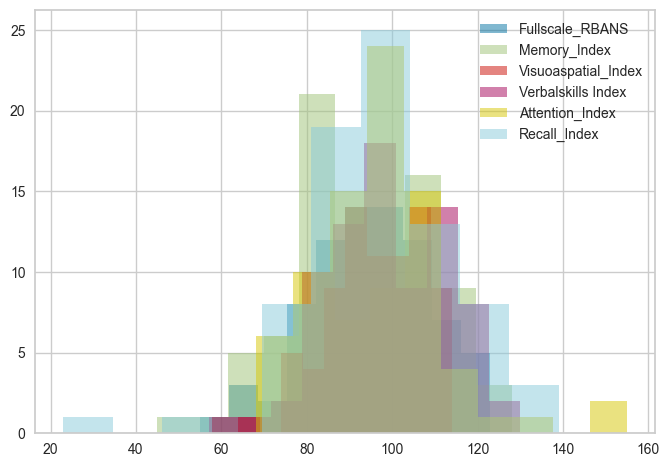

In [20]:
# Make histograms of the collun distributions
for col in columns_of_interest:
    plt.hist(df_fs[col], bins=10, alpha=0.5, label=col)
plt.legend()
plt.show()




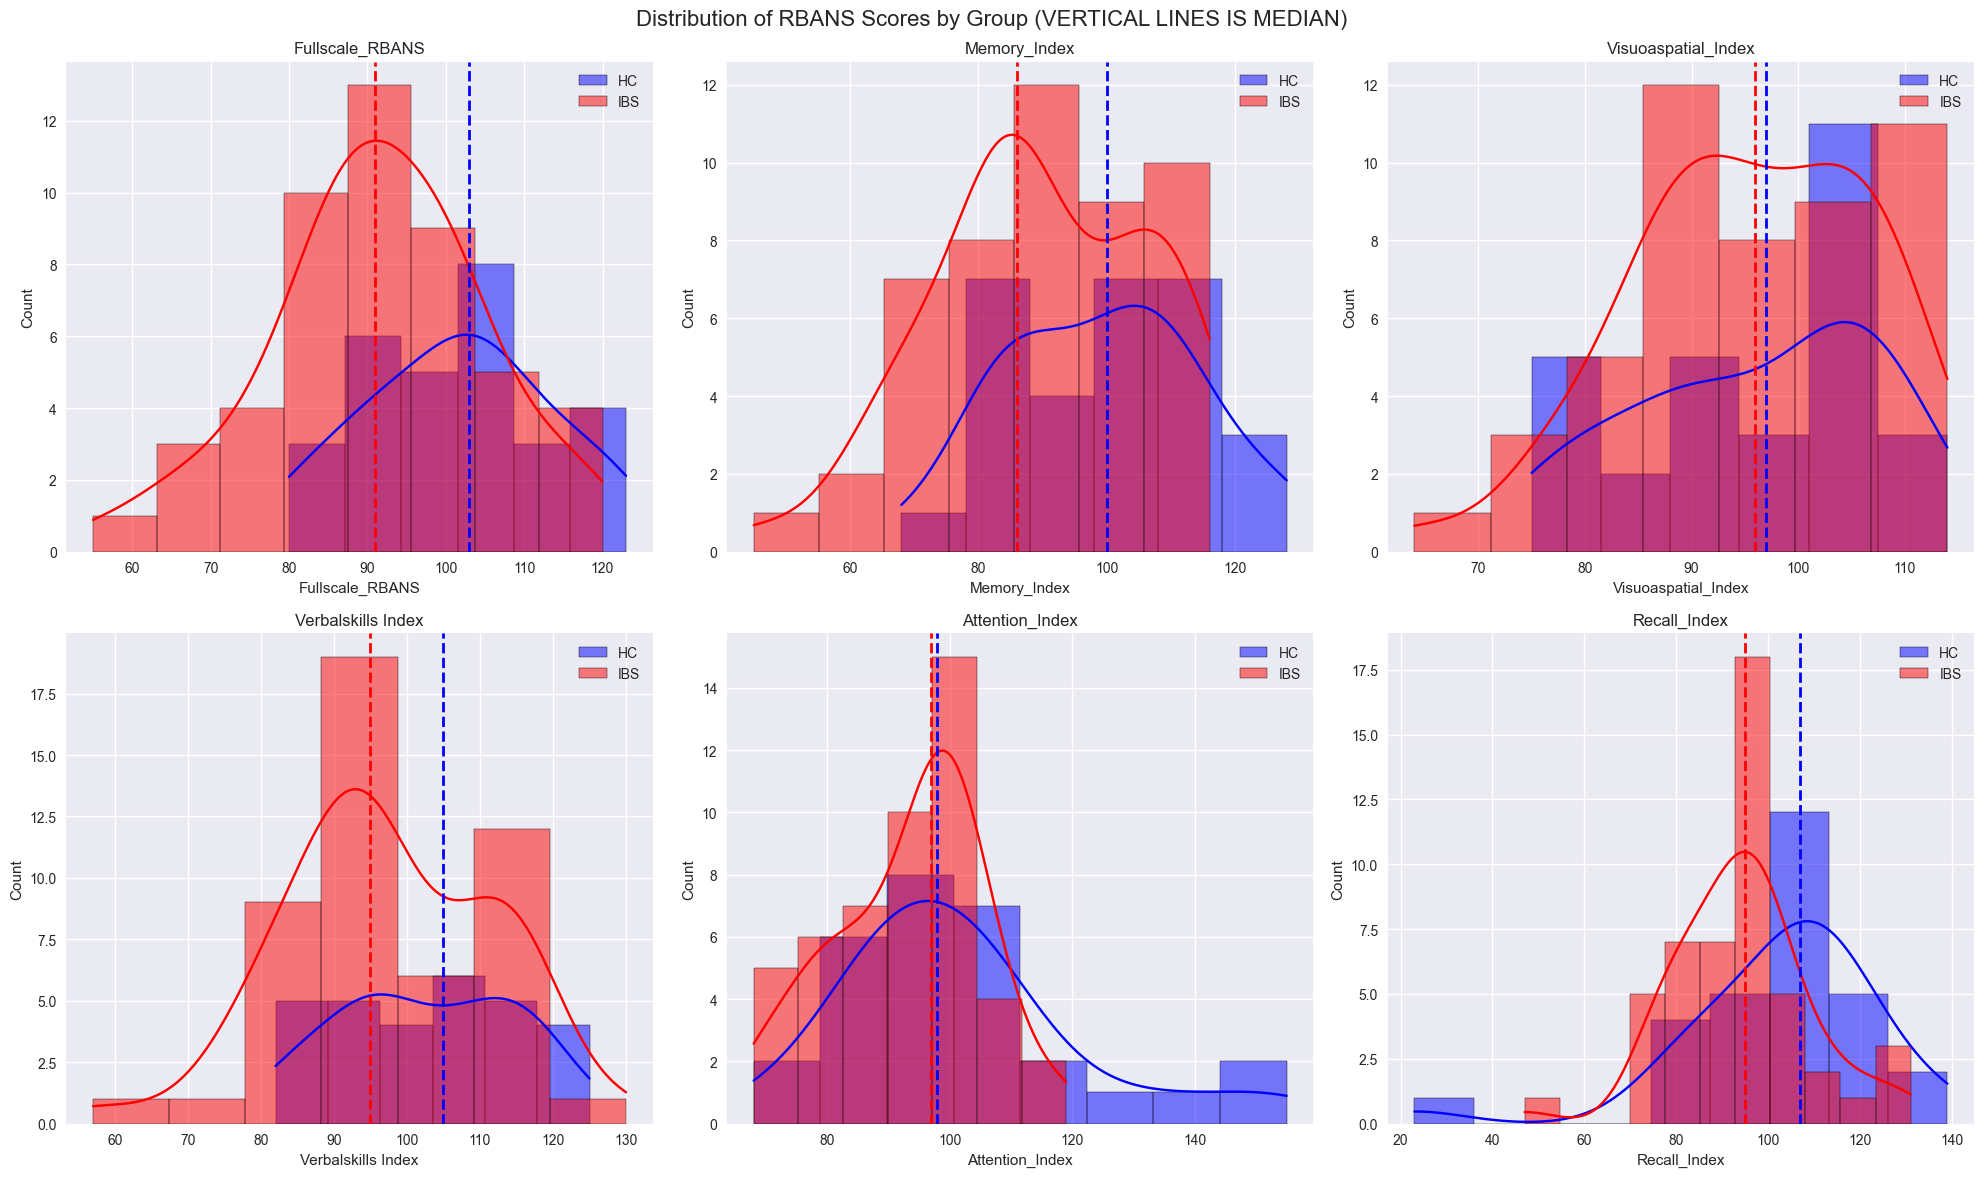

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns we're interested in
columns_of_interest = ['Fullscale_RBANS', 'Memory_Index', 'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index', 'Recall_Index']

# Set up the plot style
plt.style.use('seaborn')
sns.set_palette("Set2")

# Create a figure with subplots for each column
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of RBANS Scores by Group (VERTICAL LINES IS MEDIAN)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms for each column
for i, col in enumerate(columns_of_interest):
    ax = axes[i]
    
    # Plot histogram for HC group
    sns.histplot(data=df_fs[df_fs['Group'] == 'HC'], x=col, kde=True, color='blue', alpha=0.5, label='HC', ax=ax)
    
    # Plot histogram for IBS group
    sns.histplot(data=df_fs[df_fs['Group'] == 'IBS'], x=col, kde=True, color='red', alpha=0.5, label='IBS', ax=ax)
    
    ax.set_title(col)
    ax.legend()
    
    # Add mean lines
    #ax.axvline(df_fs[df_fs['Group'] == 'HC'][col].mean(), color='blue', linestyle='dashed', linewidth=2)
    #ax.axvline(df_fs[df_fs['Group'] == 'IBS'][col].mean(), color='red', linestyle='dashed', linewidth=2)

    # Add median lines
    ax.axvline(df_fs[df_fs['Group'] == 'HC'][col].median(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(df_fs[df_fs['Group'] == 'IBS'][col].median(), color='red', linestyle='dashed', linewidth=2)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
from scipy import stats

# List of variables we're interested in
variables = ['Fullscale_RBANS', 'Memory_Index', 'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index', 'Recall_Index']

# Function to calculate median and IQR
def median_iqr(x):
    return f"{np.median(x):.1f} ({np.percentile(x, 25):.1f}-{np.percentile(x, 75):.1f})"

# Calculate median and IQR for each group
results = df_fs.groupby('Group')[variables].agg(median_iqr).T

# Perform Mann-Whitney U test for each variable
p_values = []
for var in variables:
    _, p = stats.mannwhitneyu(df_fs[df_fs['Group'] == 'HC'][var], 
                              df_fs[df_fs['Group'] == 'IBS'][var])
    p_values.append(f"{p:.3f}")

# Add p-values to results
results['p-value'] = p_values

# Create LaTeX table
latex_table = results.to_latex(escape=False)

# Print LaTeX table
print(latex_table)

\begin{tabular}{llll}
\toprule
Group & HC & IBS & p-value \\
\midrule
Fullscale_RBANS & 103.0 (93.0-108.0) & 91.0 (85.0-100.0) & 0.002 \\
Memory_Index & 100.0 (86.0-109.0) & 86.0 (81.0-105.0) & 0.031 \\
Visuoaspatial_Index & 97.0 (90.0-107.0) & 96.0 (90.0-105.0) & 0.763 \\
Verbalskills Index & 105.0 (95.0-113.0) & 95.0 (89.0-111.0) & 0.087 \\
Attention_Index & 98.0 (89.0-108.0) & 97.0 (83.0-101.0) & 0.118 \\
Recall_Index & 107.0 (92.0-113.0) & 95.0 (85.0-100.0) & 0.006 \\
\bottomrule
\end{tabular}



It is possible to compute effect sizes using a non-parametric approach. One common non-parametric effect size measure is **Cliff's delta**. It's particularly useful when you can't assume normality in your data distribution.

A brief explanation of Cliff's delta:

Cliff's delta is a non-parametric effect size measure that quantifies the amount of difference between two groups of observations. Some key points about Cliff's delta:

1. Range: It ranges from -1 to +1.

2. Interpretation: 
   - A value of +1 indicates that all values in one group are higher than all values in the other group.
   - A value of -1 indicates that all values in one group are lower than all values in the other group.
   - A value of 0 indicates complete overlap between the two groups.

3. Magnitude guidelines:
   - |d| < 0.147: negligible effect
   - 0.147 ≤ |d| < 0.33: small effect
   - 0.33 ≤ |d| < 0.474: medium effect
   - |d| ≥ 0.474: large effect

4. Advantages:
   - It doesn't assume normality or homogeneity of variance.
   - It's suitable for ordinal data and doesn't require interval scaling.

5. Calculation: It's based on the probability that a randomly selected observation from one group is greater than a randomly selected observation from another group, minus the reverse probability.

6. Use case: It's particularly useful when dealing with non-normal distributions or when you want to avoid assumptions about the underlying distribution of the data.

Cliff's delta provides a robust measure of the difference between two groups, making it a valuable tool in situations where parametric measures like Cohen's d might not be appropriate.

Here is how to calculate Cliff's delta for each of your variables:

In [23]:
import numpy as np
import pandas as pd
from scipy import stats

def cliffs_delta(x, y):
    return stats.mannwhitneyu(x, y).statistic / (len(x) * len(y)) - 0.5

variables = ['Fullscale_RBANS', 'Memory_Index', 'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index', 'Recall_Index']

results = []

for var in variables:
    hc_data = df_fs[df_fs['Group'] == 'HC'][var]
    ibs_data = df_fs[df_fs['Group'] == 'IBS'][var]
    
    # Calculate median and IQR
    hc_median_iqr = f"{np.median(hc_data):.1f} ({np.percentile(hc_data, 25):.1f}-{np.percentile(hc_data, 75):.1f})"
    ibs_median_iqr = f"{np.median(ibs_data):.1f} ({np.percentile(ibs_data, 25):.1f}-{np.percentile(ibs_data, 75):.1f})"
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(hc_data, ibs_data)
    
    # Calculate Cliff's delta
    delta = cliffs_delta(hc_data, ibs_data)
    
    results.append([var, hc_median_iqr, ibs_median_iqr, f"{p_value:.3f}", f"{delta:.3f}"])

# Create DataFrame and format as LaTeX table
df_results = pd.DataFrame(results, columns=['Variable', 'HC', 'IBS', 'p-value', "Cliff's delta"])
latex_table = df_results.to_latex(index=False, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
Variable & HC & IBS & p-value & Cliff's delta \\
\midrule
Fullscale_RBANS & 103.0 (93.0-108.0) & 91.0 (85.0-100.0) & 0.002 & 0.213 \\
Memory_Index & 100.0 (86.0-109.0) & 86.0 (81.0-105.0) & 0.031 & 0.147 \\
Visuoaspatial_Index & 97.0 (90.0-107.0) & 96.0 (90.0-105.0) & 0.763 & 0.021 \\
Verbalskills Index & 105.0 (95.0-113.0) & 95.0 (89.0-111.0) & 0.087 & 0.116 \\
Attention_Index & 98.0 (89.0-108.0) & 97.0 (83.0-101.0) & 0.118 & 0.107 \\
Recall_Index & 107.0 (92.0-113.0) & 95.0 (85.0-100.0) & 0.006 & 0.186 \\
\bottomrule
\end{tabular}



### Save relevant variables to csv-file 

In [24]:
import pandas as pd

# List of variables to include in the new DataFrame
variables = ['Age', 'Group', 'Sex', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'IBS_SSS', 'Fullscale_RBANS', 'Memory_Index',
       'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index',
       'Recall_Index']

# Create a new DataFrame with only the specified variables
df_selected = df_fs[variables]
df_selected


,Age,Group,Sex,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,...,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,IBS_SSS,Fullscale_RBANS,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
0,38,IBS,M,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,...,0.308371,0.041267,0.426121,195,100,80,102,93,97,86
1,19,IBS,F,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,...,0.272339,0.040830,0.490546,325,116,109,107,97,115,126
2,34,IBS,F,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,...,0.288940,0.047269,0.462151,326,95,83,84,113,103,100
3,44,IBS,F,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,...,0.334672,0.043766,0.446639,357,87,86,97,90,98,86
4,38,IBS,M,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,...,0.311467,0.040728,0.441274,293,100,105,90,97,108,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,19,HC,F,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,...,0.291343,0.041865,0.476303,56,93,89,90,118,108,82
74,52,HC,F,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,...,0.279461,0.039644,0.429210,25,97,83,85,116,113,23
75,50,HC,F,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,...,0.370584,0.048317,0.542009,21,100,100,103,107,86,104
76,21,HC,M,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,...,0.294046,0.045371,0.493229,32,96,89,102,85,101,110


In [25]:
# Save the DataFrame to a CSV file
df_selected.to_csv('../data/brain_psych_data_78x46.csv', index=False)

print("DataFrame has been saved to 'brain_psych_data_78x46.csv'")


DataFrame has been saved to 'brain_psych_data_78x46.csv'


#### A possible simplification of the data
```python
df_X['Thalamus'] = df_X['Left-Thalamus'] + df_X['Right-Thalamus']   
df_X['Caudate'] = df_X['Left-Caudate'] + df_X['Right-Caudate']
df_X['Putamen'] = df_X['Left-Putamen'] + df_X['Right-Putamen']
df_X['Pallidum'] = df_X['Left-Pallidum'] + df_X['Right-Pallidum']
df_X['Hippocampus'] = df_X['Left-Hippocampus'] + df_X['Right-Hippocampus']
df_X['Amygdala'] = df_X['Left-Amygdala'] + df_X['Right-Amygdala']
df_X['Accumbens-area'] = df_X['Left-Accumbens-area'] + df_X['Right-Accumbens-area'
```


In [26]:
exclude_cols_1 = ['IBS_SSS', 'Age', 'Sex','Fullscale_RBANS', 'Memory_Index',
       'Visuoaspatial_Index', 'Verbalskills Index', 'Attention_Index',
       'Recall_Index']


sel_cols_1 = [col for col in variables if col not in exclude_cols_1]

df_X1 = df_selected[sel_cols_1]


df_X1['Outcome'] = df_selected['Group']

# Drop Group
df_X1 = df_X1.drop('Group', axis=1)

df_X1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           78 non-null     float64
 1   Left-Cerebellum-White-Matter   78 non-null     float64
 2   Left-Cerebellum-Cortex         78 non-null     float64
 3   Left-Thalamus                  78 non-null     float64
 4   Left-Caudate                   78 non-null     float64
 5   Left-Putamen                   78 non-null     float64
 6   Left-Pallidum                  78 non-null     float64
 7   Left-Hippocampus               78 non-null     float64
 8   Left-Amygdala                  78 non-null     float64
 9   Left-Accumbens-area            78 non-null     float64
 10  CSF                            78 non-null     float64
 11  Right-Cerebellum-White-Matter  78 non-null     float64
 12  Right-Cerebellum-Cortex        78 non-null     float

In [27]:
df_X1.describe().T

,count,mean,std,min,25%,50%,75%,max
eTIV,78.0,1.474885e+06,153928.840484,1.215809e+06,1.377170e+06,1.448416e+06,1.560284e+06,1.888063e+06
Left-Cerebellum-White-Matter,78.0,1.076200e-02,0.001054,8.647242e-03,1.015243e-02,1.077838e-02,1.129687e-02,1.365434e-02
Left-Cerebellum-Cortex,78.0,3.730862e-02,0.003574,3.008196e-02,3.470547e-02,3.724610e-02,3.979467e-02,4.747275e-02
Left-Thalamus,78.0,5.307679e-03,0.000490,4.015864e-03,4.947000e-03,5.369929e-03,5.647868e-03,6.334723e-03
Left-Caudate,78.0,2.485910e-03,0.000313,1.813820e-03,2.222271e-03,2.491968e-03,2.672869e-03,3.169705e-03
Left-Putamen,78.0,3.650897e-03,0.000387,2.812394e-03,3.358667e-03,3.626083e-03,3.880776e-03,4.655418e-03
Left-Pallidum,78.0,1.388744e-03,0.000123,1.033969e-03,1.317441e-03,1.384625e-03,1.475025e-03,1.723574e-03
Left-Hippocampus,78.0,2.941966e-03,0.000254,2.341288e-03,2.766887e-03,2.954976e-03,3.097828e-03,3.533187e-03
Left-Amygdala,78.0,1.221333e-03,0.000123,9.564543e-04,1.125478e-03,1.225040e-03,1.314175e-03,1.591444e-03
Left-Accumbens-area,78.0,4.330288e-04,0.000071,2.726292e-04,3.850259e-04,4.373269e-04,4.863204e-04,5.769951e-04


## Using PyCaret  (introducing the data frame df1 with predictors X and outcome y)

We use PyCaret to automatically prepare the data for us (using the default settings of the setup function):

Seen as a **classification problem** with the following settings:

**Predictors (X):** 'CortexVol', 'CerebralWhiteMatterVol', 'Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 'Amygdala', 'Accumbens-area', .... <all of Skrobisz et al. 2022><br>
**Target (y):** Outcome (HC, IBS)

In [28]:
df_X1.columns

Index(['eTIV', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'CSF',
       'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
       'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum',
       'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area',
       'WM-hypointensities', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
       'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent',
       'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'Outcome'],
      dtype='object')

In [29]:
print(list(df_X1['Outcome']))
# Get the columns that exist in both df_X1 and df_fs

['IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'HC', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC']


In [30]:
df1 = df_X1.copy()

# Recode the 'Outcome' values
df1['Outcome'] = df1['Outcome'].map({'HC': '0_HC', 'IBS': '1_IBS'})


# Drop the original 'Group' column#
#df = df.drop('Group', axis=1)

# Check the recoding
print(df1['Outcome'].value_counts())


Outcome
1_IBS    49
0_HC     29
Name: count, dtype: int64


In [31]:
# Import the classification machinery from PyCaret
from pycaret.classification import *

In [32]:
# Set up the ML experiments using PyCaret 
# (train-test split is done internally, number of folds is 10 by default, target is 'Outcome' being coded as 0 and 1 according to alphanumerical order of the labels)

experiment1 = setup(data = df1, target = 'Outcome', session_id=123)   # session_id is similar at random_state in scikit-learn 

,Description,Value
0,Session id,123
1,Target,Outcome
2,Target type,Binary
3,Target mapping,"0_HC: 0, 1_IBS: 1"
4,Original data shape,"(78, 37)"
5,Transformed data shape,"(78, 37)"
6,Transformed train set shape,"(54, 37)"
7,Transformed test set shape,"(24, 37)"
8,Numeric features,36
9,Preprocess,True


In [33]:
# List available classsifiers   
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


**Here's the data after the train-test split transformations have been computed during the experimental setup above:**

### **Training set**

In [34]:
# X in the training set
get_config('X_train').T

,26,19,67,10,57,64,1,39,0,70,...,4,74,65,49,38,31,21,77,27,37
eTIV,1.532154e+06,1.342095e+06,1.444822e+06,1.601471e+06,1.489224e+06,1.496966e+06,1.360310e+06,1.714155e+06,1.743419e+06,1.403646e+06,...,1.645577e+06,1.394849e+06,1.337223e+06,1.406561e+06,1.274730e+06,1.466350e+06,1.341897e+06,1.888064e+06,1.260650e+06,1.251429e+06
Left-Cerebellum-White-Matter,1.124678e-02,1.157586e-02,1.092162e-02,1.015579e-02,1.086512e-02,9.121118e-03,9.960152e-03,1.027597e-02,9.291627e-03,9.480168e-03,...,1.012787e-02,1.141550e-02,1.071631e-02,1.049183e-02,9.292082e-03,1.048877e-02,1.286015e-02,1.039859e-02,1.134002e-02,1.100853e-02
Left-Cerebellum-Cortex,3.251932e-02,4.212749e-02,4.020128e-02,3.193925e-02,3.499991e-02,3.220816e-02,3.939865e-02,3.861050e-02,3.480798e-02,3.923732e-02,...,3.437280e-02,3.190553e-02,3.636536e-02,3.726245e-02,3.236888e-02,3.974358e-02,3.804548e-02,3.080437e-02,4.296521e-02,3.454834e-02
Left-Thalamus,4.460257e-03,6.334723e-03,4.860737e-03,5.067153e-03,5.485072e-03,5.377545e-03,5.438979e-03,5.484392e-03,5.047955e-03,5.670233e-03,...,5.717142e-03,5.171097e-03,5.078584e-03,4.787991e-03,5.502496e-03,5.184779e-03,5.335209e-03,4.772138e-03,5.569190e-03,5.373457e-03
Left-Caudate,2.387162e-03,2.525455e-03,2.218543e-03,2.328546e-03,2.632244e-03,2.971277e-03,2.126573e-03,2.470663e-03,2.424030e-03,2.565818e-03,...,2.209133e-03,2.180236e-03,2.188042e-03,2.613396e-03,2.811653e-03,2.959935e-03,2.246745e-03,2.154959e-03,2.396700e-03,2.547567e-03
Left-Putamen,3.051652e-03,4.026019e-03,3.378963e-03,2.951348e-03,3.908748e-03,3.916590e-03,2.992478e-03,3.073059e-03,3.357827e-03,4.421058e-03,...,3.332083e-03,3.092163e-03,3.539200e-03,3.588185e-03,3.723532e-03,3.625124e-03,3.670849e-03,3.020714e-03,4.344901e-03,3.875649e-03
Left-Pallidum,1.232187e-03,1.723574e-03,1.229494e-03,1.261652e-03,1.476474e-03,1.370773e-03,1.318081e-03,1.384647e-03,1.248180e-03,1.503656e-03,...,1.317228e-03,1.153817e-03,1.354748e-03,1.385721e-03,1.301687e-03,1.242609e-03,1.501010e-03,1.033969e-03,1.519692e-03,1.341906e-03
Left-Hippocampus,3.058766e-03,3.262288e-03,2.854192e-03,2.635326e-03,2.846785e-03,2.613954e-03,2.999095e-03,2.856567e-03,3.098796e-03,3.272905e-03,...,2.863554e-03,2.759008e-03,3.148615e-03,2.954014e-03,3.241783e-03,2.560576e-03,2.877643e-03,2.341288e-03,3.010193e-03,3.438629e-03
Left-Amygdala,1.260774e-03,1.333885e-03,1.300368e-03,1.187783e-03,1.424299e-03,1.037165e-03,1.194580e-03,1.156021e-03,1.336569e-03,1.288430e-03,...,1.168769e-03,1.084634e-03,1.038346e-03,1.237842e-03,1.315258e-03,1.200396e-03,1.088757e-03,1.097050e-03,1.321540e-03,1.235148e-03
Left-Accumbens-area,3.651069e-04,4.185993e-04,4.459372e-04,4.495865e-04,4.936800e-04,4.800377e-04,3.904256e-04,5.016465e-04,4.131537e-04,4.764734e-04,...,4.050858e-04,3.375276e-04,3.710675e-04,5.213426e-04,5.050479e-04,4.626454e-04,2.786354e-04,4.018403e-04,4.657121e-04,4.271117e-04


In [35]:
# True labels y in the training set
print("Group:", list(get_config('y_train')))

Group: ['0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [36]:
get_config('X_train').info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 26 to 37
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           54 non-null     float32
 1   Left-Cerebellum-White-Matter   54 non-null     float32
 2   Left-Cerebellum-Cortex         54 non-null     float32
 3   Left-Thalamus                  54 non-null     float32
 4   Left-Caudate                   54 non-null     float32
 5   Left-Putamen                   54 non-null     float32
 6   Left-Pallidum                  54 non-null     float32
 7   Left-Hippocampus               54 non-null     float32
 8   Left-Amygdala                  54 non-null     float32
 9   Left-Accumbens-area            54 non-null     float32
 10  CSF                            54 non-null     float32
 11  Right-Cerebellum-White-Matter  54 non-null     float32
 12  Right-Cerebellum-Cortex        54 non-null     float32
 

In [37]:
get_config('X_train').describe()

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol
count,5.400000e+01,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,1.458445e+06,0.010758,0.036852,0.005250,0.002476,0.003627,0.001380,0.002955,0.001223,0.000431,...,0.790783,0.775965,0.168727,0.168860,0.337588,0.151830,0.150517,0.302347,0.042328,0.454732
std,1.611610e+05,0.001045,0.003356,0.000502,0.000302,0.000432,0.000131,0.000268,0.000132,0.000067,...,0.033714,0.034509,0.010823,0.010537,0.021277,0.009293,0.009951,0.019187,0.003053,0.027320
min,1.215809e+06,0.008659,0.030638,0.004016,0.001895,0.002812,0.001034,0.002341,0.000956,0.000273,...,0.718903,0.703756,0.152774,0.152168,0.305495,0.135025,0.132724,0.267749,0.036384,0.406023
25%,1.363172e+06,0.010163,0.034583,0.004871,0.002214,0.003319,0.001293,0.002786,0.001121,0.000387,...,0.774535,0.753644,0.161435,0.160914,0.322045,0.145036,0.143853,0.289953,0.040165,0.433336
50%,1.413995e+06,0.010783,0.036130,0.005351,0.002425,0.003598,0.001377,0.002978,0.001233,0.000437,...,0.787483,0.773697,0.168024,0.168868,0.336678,0.151963,0.150747,0.303078,0.042137,0.454858
75%,1.520627e+06,0.011311,0.039349,0.005572,0.002678,0.003902,0.001475,0.003108,0.001315,0.000486,...,0.805090,0.792836,0.175714,0.174726,0.351409,0.155961,0.155435,0.311454,0.044608,0.474296
max,1.888064e+06,0.013593,0.045192,0.006335,0.003077,0.004655,0.001724,0.003533,0.001591,0.000531,...,0.952974,0.935418,0.202942,0.205325,0.408267,0.184339,0.186245,0.370584,0.048317,0.542009


In [38]:
get_config('y_train').info()

<class 'pandas.core.series.Series'>
Index: 54 entries, 26 to 37
Series name: Outcome
Non-Null Count  Dtype   
--------------  -----   
54 non-null     category
dtypes: category(1)
memory usage: 610.0 bytes


In [39]:
get_config('y_train').value_counts()

Outcome
1_IBS    34
0_HC     20
Name: count, dtype: int64

### **Test set**

In [40]:
get_config('X_test').T

,59,55,29,3,22,6,62,46,5,33,...,35,8,69,48,47,63,56,13,76,14
eTIV,1.580332e+06,1.441712e+06,1.479463e+06,1.595000e+06,1.533278e+06,1.515539e+06,1.524518e+06,1.823484e+06,1.505441e+06,1.320595e+06,...,1.570709e+06,1.224505e+06,1.386840e+06,1.403014e+06,1.762430e+06,1.641095e+06,1.544695e+06,1.578284e+06,1.609012e+06,1.415589e+06
Left-Cerebellum-White-Matter,1.131357e-02,1.059893e-02,1.226965e-02,1.045818e-02,1.078350e-02,1.084723e-02,1.273439e-02,1.133298e-02,9.659963e-03,1.022085e-02,...,1.117330e-02,1.365434e-02,1.158692e-02,9.927842e-03,1.098699e-02,9.254066e-03,1.055541e-02,8.647243e-03,1.054480e-02,1.107334e-02
Left-Cerebellum-Cortex,4.136346e-02,3.992760e-02,3.861765e-02,3.090181e-02,4.074996e-02,3.751899e-02,3.685153e-02,3.572316e-02,4.284155e-02,3.791201e-02,...,3.849072e-02,4.747275e-02,4.328956e-02,3.601019e-02,4.110222e-02,3.452640e-02,3.467130e-02,3.722975e-02,4.091922e-02,3.917648e-02
Left-Thalamus,5.163219e-03,4.938781e-03,6.194882e-03,5.802569e-03,5.667076e-03,6.124685e-03,5.207418e-03,5.279949e-03,5.335448e-03,5.720983e-03,...,5.384067e-03,6.206428e-03,5.535461e-03,4.921263e-03,4.971657e-03,5.068811e-03,4.765471e-03,5.513395e-03,5.930287e-03,5.723483e-03
Left-Caudate,2.117530e-03,2.346863e-03,3.004806e-03,2.674733e-03,2.631944e-03,2.558033e-03,2.483146e-03,2.016141e-03,2.582832e-03,2.175989e-03,...,2.559291e-03,2.798438e-03,2.241426e-03,2.509099e-03,3.114846e-03,2.533674e-03,1.813820e-03,2.460965e-03,2.500790e-03,3.169705e-03
Left-Putamen,3.422192e-03,3.455336e-03,3.942376e-03,3.621755e-03,3.825009e-03,3.616666e-03,3.719734e-03,3.681580e-03,3.880857e-03,3.941861e-03,...,3.673247e-03,3.855682e-03,4.184116e-03,3.333253e-03,4.096048e-03,3.506684e-03,3.210924e-03,4.120236e-03,3.862682e-03,3.630785e-03
Left-Pallidum,1.266000e-03,1.261278e-03,1.569691e-03,1.321504e-03,1.450096e-03,1.581879e-03,1.258497e-03,1.358608e-03,1.421644e-03,1.384603e-03,...,1.450237e-03,1.494564e-03,1.409247e-03,1.325789e-03,1.549962e-03,1.389743e-03,1.400923e-03,1.449106e-03,1.623543e-03,1.490546e-03
Left-Hippocampus,2.767393e-03,3.030217e-03,3.204000e-03,2.925203e-03,2.884344e-03,3.029549e-03,2.634998e-03,2.694074e-03,2.835117e-03,3.029241e-03,...,2.811852e-03,3.361114e-03,2.794915e-03,2.986285e-03,3.203417e-03,2.601251e-03,2.880438e-03,2.821800e-03,2.966728e-03,3.208276e-03
Left-Amygdala,1.121536e-03,1.154600e-03,1.360629e-03,1.137304e-03,1.289329e-03,1.076251e-03,1.192902e-03,1.171988e-03,1.313370e-03,1.350679e-03,...,1.118094e-03,1.430538e-03,1.248954e-03,1.106689e-03,1.238290e-03,1.069469e-03,1.158869e-03,1.279935e-03,1.334981e-03,1.347637e-03
Left-Accumbens-area,3.397387e-04,3.651215e-04,5.727753e-04,4.951096e-04,4.418639e-04,4.705916e-04,4.049150e-04,3.844839e-04,3.980894e-04,4.189779e-04,...,4.515160e-04,5.283769e-04,5.769951e-04,4.047002e-04,4.368967e-04,5.562750e-04,3.045908e-04,5.678954e-04,3.308242e-04,4.503425e-04


In [41]:
print("Outcome:", list(get_config('y_test')))

Outcome: ['1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [42]:
get_config('y_test').value_counts()

Outcome
1_IBS    15
0_HC      9
Name: count, dtype: int64

### **Make separate data frames from train and test with additional variables for characterizing**

In [43]:
def make_data_frame_from_train_or_test(split='train', df=df_fs, varlist=[]):
    """
    Make a data frame from the training or test set
    Use variables from an input dataset df_in for additional characterization of the training or test set
    These variable should be categorical or numerical
    
    # Example use of the function
    split = 'train'
    varlist=['Target', 'Gender', 'Sex', 'Age', 'IBS_SSS']
    df_split = make_data_frame_from_train_or_test(split=split, df=df_in, varlist=varlist)
    print(f"\n{split} data: {df_split.groupby('Target').size()}")
    print(f"\n{split} data: {df_split.groupby('Gender').size()}")  
    df_split.head()
    """
    df_split = get_config(f'X_{split}')
    df_split['Target'] = get_config(f'y_{split}')
    df_split['Index'] = df_split.index
    for var in varlist:
        if var in df.columns:
            df_split[var] = df[var][df_split['Index']]
        elif var in df_split.columns:
            df_split[var] = df_split[var][df_split['Index']]
        else:
            print(f"Variable {var} is not in the input dataset")
            continue
    
    # Renumber index
    df_split = df_split.reset_index(drop=True)

    return df_split



In [44]:
# Testing the function

split = 'train'
varlist=['Group', 'Sex']
varlist_extra = ['Subject', 'Age', 'IBS_SSS']
df_train = make_data_frame_from_train_or_test(split=split, df=df_fs, varlist=varlist+varlist_extra)

print(f'\nShape of df_train: {df_train.shape}')

for var in varlist:
    if var in df_train.columns:
        print(f"\n{split} data: {df_train.groupby(var).size()}")
    else:
        print(f"Variable {var} is not in the input dataset")
 
df_train



Shape of df_train: (54, 43)

train data: Group
HC     20
IBS    34
dtype: int64

train data: Sex
F    43
M    11
dtype: int64


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Target,Index,Group,Sex,Subject,Age,IBS_SSS
0,1532153.875,0.011247,0.032519,0.004460,0.002387,0.003052,0.001232,0.003059,0.001261,0.000365,...,0.328247,0.038490,0.419291,0_HC,26,HC,F,BGA_081,49,
1,1342095.000,0.011576,0.042127,0.006335,0.002525,0.004026,0.001724,0.003262,0.001334,0.000419,...,0.303780,0.047659,0.478924,0_HC,19,HC,F,BGA_070,28,58
2,1444822.125,0.010922,0.040201,0.004861,0.002219,0.003379,0.001229,0.002854,0.001300,0.000446,...,0.313685,0.039977,0.452007,0_HC,67,HC,F,BGA_157,54,6
3,1601471.375,0.010156,0.031939,0.005067,0.002329,0.002951,0.001262,0.002635,0.001188,0.000450,...,0.300926,0.039460,0.410209,1_IBS,10,IBS,F,BGA_059,43,364
4,1489223.750,0.010865,0.035000,0.005485,0.002632,0.003909,0.001476,0.002847,0.001424,0.000494,...,0.314569,0.043950,0.437845,1_IBS,57,IBS,F,BGA_143,40,190
5,1496965.625,0.009121,0.032208,0.005378,0.002971,0.003917,0.001371,0.002614,0.001037,0.000480,...,0.290110,0.042554,0.444361,1_IBS,64,IBS,F,BGA_153,32,191
6,1360310.500,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,0.001195,0.000390,...,0.272339,0.040830,0.490546,1_IBS,1,IBS,F,BGA_047,19,325
7,1714155.250,0.010276,0.038611,0.005484,0.002471,0.003073,0.001385,0.002857,0.001156,0.000502,...,0.289917,0.040817,0.471074,1_IBS,39,IBS,M,BGA_095,28,405
8,1743419.000,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,0.001337,0.000413,...,0.308371,0.041267,0.426121,1_IBS,0,IBS,M,BGA_046,38,195
9,1403646.000,0.009480,0.039237,0.005670,0.002566,0.004421,0.001504,0.003273,0.001288,0.000476,...,0.290060,0.047157,0.487571,1_IBS,70,IBS,F,BGA_161,21,393


In [45]:
# Test data set
split = 'test'
varlist=['Group', 'Sex']
varlist_extra = ['Subject', 'Age', 'IBS_SSS']
df_test = make_data_frame_from_train_or_test(split=split, df=df_fs, varlist=varlist+varlist_extra)

print(f'\nShape of df_test: {df_test.shape}')

for var in varlist:
    if var in df_train.columns:
        print(f"\n{split} data: {df_test.groupby(var).size()}")
    else:
        print(f"Variable {var} is not in the input dataset")
 
df_test



Shape of df_test: (24, 43)

test data: Group
HC      9
IBS    15
dtype: int64

test data: Sex
F    15
M     9
dtype: int64


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Target,Index,Group,Sex,Subject,Age,IBS_SSS
0,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.307623,0.040059,0.455646,1_IBS,59,IBS,M,BGA_145,43,236
1,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.286548,0.040310,0.464761,1_IBS,55,IBS,F,BGA_141,29,298
2,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.321555,0.046860,0.480850,0_HC,29,HC,F,BGA_084,23,21
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.334672,0.043766,0.446639,1_IBS,3,IBS,F,BGA_050,44,357
4,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.320433,0.044115,0.482682,0_HC,22,HC,F,BGA_076,24,0
5,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.324030,0.045131,0.459258,1_IBS,6,IBS,F,BGA_055,31,158
6,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.276495,0.041054,0.466345,1_IBS,62,IBS,F,BGA_151,22,304
7,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.325987,0.040960,0.423745,1_IBS,46,IBS,M,BGA_107,33,228
8,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.270380,0.042538,0.476372,0_HC,5,HC,M,BGA_053,25,15
9,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.298172,0.043886,0.448879,1_IBS,33,IBS,F,BGA_089,35,418


# Modelling

## Train some base models

Let's find the top performing models from those in PyCaret:

The function `compare_models()` trains and evaluates performance of all estimators available in the  model library using cross validation. The output of this function is a score grid  with average cross validated scores. Metrics evaluated during CV can be accessed using the ``get_metrics`` function. Custom metrics can be added or removed using 
``add_metric`` and ``remove_metric`` function.

The `sort order` of the score grid (default is `Accuracy`). It also accepts custom metrics that are added through the ``add_metric`` function.

In [46]:
help(compare_models)

Help on function compare_models in module pycaret.classification.functional:

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Union[int, Any, NoneType] = None, round: int = 4, cross_validation: bool = True, sort: str = 'Accuracy', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, experiment_custom_tags: Optional[Dict[str, Any]] = None, probability_threshold: Optional[float] = None, engine: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[pycaret.internal.parallel.parallel_backend.ParallelBackend] = None) -> Union[Any, List[Any]]
    This function trains and evaluates performance of all estimators available in the
    model library using cross validation. The output of this function is a score grid
    with average cross validated scores. Metrics evaluated during CV can be access

## Table 3: Model comparisons and their metrics

In [47]:
# %pip install --upgrade pycaret

In [48]:
import pycaret
print(pycaret.__version__)

3.3.2


### NOTE on **Dummy Classifier**:

The Dummy Classifier in PyCaret is a simple classifier that serves as a baseline for comparison with more sophisticated models. It's essentially a way to establish a performance benchmark that any useful model should be able to surpass. Let me explain its key aspects:

1. Purpose:
   - The Dummy Classifier is used to create a baseline performance.
   - It helps to understand if other models are actually learning useful patterns or just guessing.

2. Strategies:
   The Dummy Classifier can use several strategies to make predictions:

   a) "stratified": Generates random predictions based on the class distribution in the training set.
   b) "most_frequent": Always predicts the most frequent class in the training set.
   c) "prior": Always predicts the class that maximizes the class prior.
   d) "uniform": Generates uniformly random predictions.
   e) "constant": Always predicts a constant class provided by the user.

3. In PyCaret:
   - PyCaret includes the Dummy Classifier as one of its model options.
   - It's typically listed as 'dummy' in the model library.

4. Usage in Model Comparison:
   - When you run `compare_models()` in PyCaret, the Dummy Classifier is included by default.
   - This allows you to see how other models perform relative to this simple baseline.

5. Interpretation:
   - If your sophisticated models only perform as well as or worse than the Dummy Classifier, it suggests that they're not learning useful patterns from the data.
   - Any model worth using should outperform the Dummy Classifier significantly.

6. Example in PyCaret:
   ```python
   from pycaret.classification import *
   
   # Setup your classification experiment
   exp = setup(data, target='target_column')
   
   # Compare models including the dummy classifier
   best_model = compare_models()
   ```

7. Metrics:
   - The Dummy Classifier will have scores for various metrics like accuracy, AUC, recall, etc.
   - These scores represent the baseline performance for each metric.

8. Importance in Imbalanced Datasets:
   - In imbalanced datasets, the Dummy Classifier can be particularly revealing.
   - For instance, if 90% of your data belongs to one class, a Dummy Classifier always predicting that class would have 90% accuracy.
   - This highlights why accuracy alone can be misleading in imbalanced scenarios.

9. Cross-Validation:
   - Like other models in PyCaret, the Dummy Classifier's performance is typically evaluated using cross-validation.
   - This ensures a robust estimate of its baseline performance.

10. Customization:
    - In PyCaret, you can customize the Dummy Classifier's strategy if needed, though the default is usually sufficient for baseline comparisons.

Remember, the goal is not for the Dummy Classifier to perform well, but for your other models to significantly outperform it. If they don't, it might indicate that your features aren't predictive of the target variable, or that there might be issues with your data or problem formulation.

In [49]:
#%%time
# Compare all models 
# Omit the AUC metric in setup (remove_metric('AUC')) and compare_models)

#best_model = compare_models(n_select=1, exclude=['auc'], fold=3, round=4)

In [51]:
%%time
#best_model = compare_models(fold=3, cross_validation=True, sort="Accuracy", n_select=1, parallel=False)
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7200,0.6833,0.7200,0.7383,0.7124,0.4031,0.4204,0.0200
knn,K Neighbors Classifier,0.6867,0.6292,0.6867,0.7022,0.6693,0.2982,0.3265,0.0170
lr,Logistic Regression,0.6267,0.5500,0.6267,0.3938,0.4833,0.0000,0.0000,0.0120
svm,SVM - Linear Kernel,0.6267,0.5333,0.6267,0.3938,0.4833,0.0000,0.0000,0.0100
gbc,Gradient Boosting Classifier,0.6267,0.4667,0.6267,0.6544,0.5920,0.1978,0.2357,0.0270
dummy,Dummy Classifier,0.6267,0.5000,0.6267,0.3938,0.4833,0.0000,0.0000,0.0100
dt,Decision Tree Classifier,0.6133,0.6083,0.6133,0.6656,0.6096,0.2039,0.2374,0.0100
nb,Naive Bayes,0.6067,0.5583,0.6067,0.4801,0.5177,0.0450,0.0578,0.0100
ridge,Ridge Classifier,0.6067,0.2917,0.6067,0.3878,0.4726,-0.0364,-0.0408,0.0130
lightgbm,Light Gradient Boosting Machine,0.5867,0.5625,0.5867,0.5003,0.5239,0.0276,0.0270,0.0570


CPU times: user 5.83 s, sys: 517 ms, total: 6.35 s
Wall time: 5.8 s


In [52]:
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [53]:
# Run XGBoost model  (here, slightly better than Dummy Classifier)
xgb1 = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,0.7500,0.6667,0.6667,0.6667,0.2500,0.2500
2,0.6667,0.5000,0.6667,0.8333,0.6667,0.4000,0.5000
3,0.6667,0.7500,0.6667,0.6667,0.6667,0.2500,0.2500
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.4000,0.1667,0.4000,0.3000,0.3429,-0.3636,-0.4082
6,0.6000,0.6667,0.6000,0.6000,0.6000,0.1667,0.1667
7,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
8,0.8000,0.8333,0.8000,0.8667,0.8000,0.6154,0.6667


In [54]:
# Run RandomForest model  (here, slightly better than Dummy Classifier)
rf1 = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,1.0000,0.8333,0.8889,0.8381,0.6667,0.7071
1,0.6667,0.3750,0.6667,0.4444,0.5333,0.0000,0.0000
2,0.6667,0.6250,0.6667,0.8333,0.6667,0.4000,0.5000
3,0.5000,0.4375,0.5000,0.4000,0.4444,-0.2857,-0.3162
4,0.8000,1.0000,0.8000,0.8500,0.7810,0.5455,0.6124
5,0.2000,0.0000,0.2000,0.2000,0.2000,-0.6667,-0.6667
6,0.2000,0.0000,0.2000,0.2000,0.2000,-0.6667,-0.6667
7,0.2000,0.3333,0.2000,0.2000,0.2000,-0.6667,-0.6667
8,0.8000,0.6667,0.8000,0.8500,0.7810,0.5455,0.6124


In [55]:
#%%time
#best_model = xgboost # tune_model(xgboost)
#best_model = tune_model(best_model_not_tuned)

## Model prediction with the best_model

The `pred_best = predict_model(best_model)` line in PyCaret is used to generate predictions using the best model that was previously trained. Let's break down what this function does:

1. Purpose:
   - `predict_model()` is a PyCaret function used to make predictions on new or existing data using a trained model.

2. Input:
   - `best_model`: This is typically the model object returned by functions like `create_model()`, `tune_model()`, or `compare_models()`. It represents the trained model you want to use for predictions.

3. Default Behavior:
   - By default, if no new data is provided, `predict_model()` will use the test set that was automatically created during the `setup()` phase.

4. Output (pred_best):
   - The function returns a pandas DataFrame containing the original features, the true target values (if available), and the model's predictions.
   - It typically includes columns like:
     - Original features
     - 'Outcome' or your target column name (if available in the test set)
     - 'prediction_label': The predicted class labels
     - 'prediction_score': The probability scores for the predicted class (for classification tasks)

5. Additional Information:
   - For classification tasks, it provides probability scores for each class.
   - For regression tasks, it provides the predicted values.

6. Customization:
   - You can pass additional parameters to `predict_model()` to customize its behavior, such as specifying new data, changing the probability threshold for classification, etc.

7. Example usage:
   ```python
   # Assuming 'best_model' is your trained model
   predictions = predict_model(best_model)
   
   # To predict on new data
   new_predictions = predict_model(best_model, data=new_data)
   ```

8. Interpretation:
   - The resulting DataFrame allows you to compare the predicted values with the actual values (if available) and analyze the model's performance on the test set or new data.

9. Further Analysis:
   - After getting the predictions, you can use this DataFrame for various purposes like calculating additional metrics, creating visualizations, or performing error analysis.

In summary, `pred_best = predict_model(best_model)` generates predictions using your best model on the test set (or provided data), giving you a comprehensive DataFrame that includes both the original features and the model's predictions. This is crucial for evaluating your model's performance and understanding how it's making predictions on unseen data.

In [56]:
print(f'\n --> Model prediction with the best_model1 (df1_test):')
pred_best = predict_model(best_model)
#pred_best = predict_model(xgb)
pred_best


 --> Model prediction with the best_model1 (df1_test):


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5000,0.3185,0.5000,0.4368,0.4580,-0.1707,-0.1854


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Outcome,prediction_label,prediction_score
59,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.163753,0.328875,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057
55,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.171678,0.343989,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880
29,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.176176,0.355739,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.170035,0.339791,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930
22,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.177963,0.356654,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934
6,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.167949,0.337384,0.163091,0.160939,0.324030,0.045131,0.459258,1_IBS,1_IBS,0.9695
62,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.174455,0.349376,0.139267,0.137228,0.276495,0.041054,0.466345,1_IBS,1_IBS,0.8355
46,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.154182,0.312039,0.165654,0.160333,0.325987,0.040960,0.423745,1_IBS,1_IBS,0.6436
5,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.174857,0.347890,0.134529,0.135851,0.270380,0.042538,0.476372,0_HC,1_IBS,0.9952
33,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.163060,0.327638,0.149032,0.149140,0.298172,0.043886,0.448879,1_IBS,0_HC,0.5911


In [57]:
# Get the list of Subject IDs based on the best model prediction
BGA_list = df_fs['Subject'][list(pred_best.index)]
# Same as df_test[['Subject','Index']]
# Check with df_test[['Subject','Index']]
BGA_list

59    BGA_145
55    BGA_141
29    BGA_084
3     BGA_050
22    BGA_076
6     BGA_055
62    BGA_151
46    BGA_107
5     BGA_053
33    BGA_089
16    BGA_067
42    BGA_099
54    BGA_139
50    BGA_128
35    BGA_091
8     BGA_057
69    BGA_160
48    BGA_114
47    BGA_110
63    BGA_152
56    BGA_142
13    BGA_064
76    BGA_171
14    BGA_065
Name: Subject, dtype: object

In [58]:
# Make the pred_model a dataframe where the index is a separate columns denoted BGA
BGA_list = df_test['Subject']  # list(pred_best.index)

df_pred_best = pd.DataFrame()
#df_tuned_pred = pred_model.reset_index().copy()

# Get the probabilities of prediction
y_pred_proba = best_model.predict_proba(get_config('X_test'))

# Add the BGA column from df_in corresponding to indexes in the BGA_list
df_pred_best['Subject'] = df_test['Subject']

# Reset index in pred_model
pred_best = pred_best.reset_index(drop=True)

# Add the columns of pred_model to df_tuned_pred
for col in pred_best.columns:
    df_pred_best[col] = pred_best[col]

df_pred_best['p(0)'] = y_pred_proba[:,0]
df_pred_best['p(1)'] = y_pred_proba[:,1]
# Rename the columns
#df_pred_best = df_pred_best.rename(columns = {'Target': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(0),p(1))'})
df_pred_best = df_pred_best.rename(columns = {'Outcome': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(0),p(1))'})
df_pred_best


,Subject,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,True,Predicted,"max(p(0),p(1))",p(0),p(1)
0,BGA_145,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,...,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057,0.394304,0.605696
1,BGA_141,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,...,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880,0.012047,0.987953
2,BGA_084,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,...,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353,0.635333,0.364667
3,BGA_050,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,...,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930,0.007036,0.992964
4,BGA_076,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,...,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934,0.006635,0.993365
5,BGA_055,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,...,0.163091,0.160939,0.324030,0.045131,0.459258,1_IBS,1_IBS,0.9695,0.030467,0.969533
6,BGA_151,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,...,0.139267,0.137228,0.276495,0.041054,0.466345,1_IBS,1_IBS,0.8355,0.164486,0.835514
7,BGA_107,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,...,0.165654,0.160333,0.325987,0.040960,0.423745,1_IBS,1_IBS,0.6436,0.356379,0.643621
8,BGA_053,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,...,0.134529,0.135851,0.270380,0.042538,0.476372,0_HC,1_IBS,0.9952,0.004850,0.995150
9,BGA_089,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,...,0.149032,0.149140,0.298172,0.043886,0.448879,1_IBS,0_HC,0.5911,0.591094,0.408906


### Four representations of the confusion matrix (best_model applied to the test set)

In [59]:
df_pred_best[['True','Predicted']].value_counts()

True   Predicted
1_IBS  1_IBS        11
0_HC   1_IBS         8
1_IBS  0_HC          4
0_HC   0_HC          1
Name: count, dtype: int64

In [60]:
# Make a cross tabulation of True and Predicted
pd.crosstab(df_pred_best['True'], df_pred_best['Predicted'])

Predicted,0_HC,1_IBS
True,,
0_HC,1,8
1_IBS,4,11


In [61]:
cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'])
print(cm)


[[ 1  8]
 [ 4 11]]


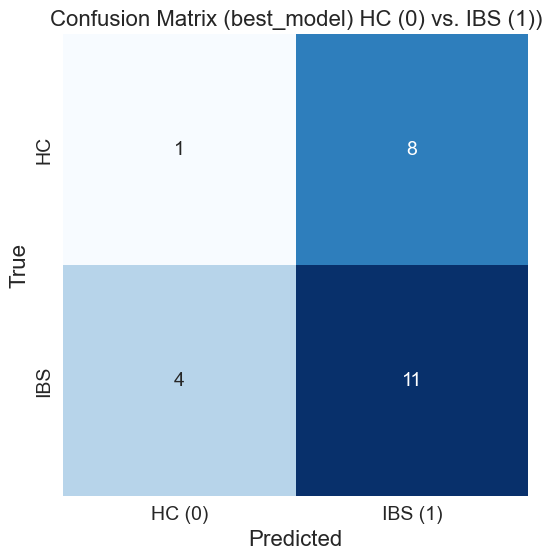

In [62]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'])   # , labels=['0_NotImpaired', '1_Impaired'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (best_model) HC (0) vs.IBS (1))', fontsize=16)
ax.set_title('Confusion Matrix (best_model) HC (0) vs. IBS (1))', fontsize=16)

ax.set_xticklabels(['HC (0)', 'IBS (1)'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()


In [63]:
print(cm[1,1], cm[0,1], cm[1,0], cm[0,0])


11 8 4 1


In [64]:
# True Positive (TP)
TP = cm[1, 1]
# True Negative (TN)
TN = cm[0, 0]
# False Positive (FP)
FP = cm[0, 1]
# False Negative (FN)
FN = cm[1, 0]

print(f'TP (true positive i.e. M (1)) = {TP}\nTN (true negative i.e. F (0)) = {TN}\nFP (false pos.) = {FP}\nFN (false neg.) = {FN}\n')

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

# Balanced accuracy
BACC = (TPR + TNR)/2

#F1-score
F1 = 2/((1/PPV) + (1/TPR))
#F1 = 2*TP /(2*TP+FP+FN)
#F1 = 2*PPV*TPR/(PPV+TPR)

# Matthews correlation coefficient
MCC = ((TP*TN)-(FP*FN)) /np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Loop through the variables and print them with 2 decimals and preceede with variable name as string
var_names = ['TPR = TP/(TP+FN) (true positive rate, sensitivity, recall)', 
             'TNR = TN/(TN+FP) (true negative rate, specificity)', 
             'PPV = TP/(TP+FP) (positive predictive value, precision)', 
             'NPV = TN/(TN+FN) (negative predictive value)', 
             'FPR = FP/(FP+TN) (false positive rate)', 
             'FNR = FN/(TP+FN) (false negative rate)', 
             'FDR = FP/(TP+FP) (false discovery rate)', 
             'ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy)',
             'BACC = (Sensitivity + Specificity) / 2 (balanced accuracy)',
             'F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall)',
             'MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))']
for i, var in enumerate([TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC, BACC,F1, MCC]):
    print(var_names[i],'=', "{:.2f}".format(var))

TP (true positive i.e. M (1)) = 11
TN (true negative i.e. F (0)) = 1
FP (false pos.) = 8
FN (false neg.) = 4

TPR = TP/(TP+FN) (true positive rate, sensitivity, recall) = 0.73
TNR = TN/(TN+FP) (true negative rate, specificity) = 0.11
PPV = TP/(TP+FP) (positive predictive value, precision) = 0.58
NPV = TN/(TN+FN) (negative predictive value) = 0.20
FPR = FP/(FP+TN) (false positive rate) = 0.89
FNR = FN/(TP+FN) (false negative rate) = 0.27
FDR = FP/(TP+FP) (false discovery rate) = 0.42
ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy) = 0.50
BACC = (Sensitivity + Specificity) / 2 (balanced accuracy) = 0.42
F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall) = 0.65
MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) = -0.19


In [65]:
print(df_pred_best.columns)


Index(['Subject', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'True', 'Predicted', 'max(p(0),p(1))', 'p(0)', 'p(1)'],
      dtype='object')


### The following book-keeping is modified from the IBS-distress project

In [66]:
df_pred1 = df_pred_best.copy()
df_in = df_fs.copy()

print(df_in['IBS_SSS'].value_counts())

IBS_SSS
       6
0      3
405    2
21     2
233    2
      ..
418    1
16     1
325    1
277    1
53     1
Name: count, Length: 66, dtype: int64


In [67]:
# Make a list of all BG_ID values for which their 'IBS SSS' is missing

df_fs_rbans = pd.read_csv('../../Ben/Data/fs6_fs7_rbans.csv')

missing_IBS_SSS_in_al_34 = sorted(['BGA_114', 'BGA_092', 'BGA_110', 'BGA_062', 'BGA_056', 'BGA_081'])

# Get the BG_ID for which IBS SSS is in the list
df_fs_rbans[df_fs_rbans['BG_ID'].isin(missing_IBS_SSS_in_al_34)][['BG_ID','IBS SSS', 'Age', 'Gender1', 'Group', 'Diagnose (1=D, 2=C, 3=M, 0=HC)  ']]

,BG_ID,IBS SSS,Age,Gender1,Group,"Diagnose (1=D, 2=C, 3=M, 0=HC)"
7,BGA_056,,52,female,1,1
13,BGA_062,,26,female,1,2
27,BGA_081,,49,female,2,0
37,BGA_092,,39,female,2,0
48,BGA_110,,22,male,2,0
49,BGA_114,,37,female,1,2


### Imputation of `IBS SSS` according to Gender1 and Group

In [68]:
import numpy as np
import pandas as pd

def clean_and_convert(x):
    if pd.isna(x) or str(x).strip() == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Clean and convert the IBS SSS data in the dataframe
df_fs_rbans['IBS SSS Clean'] = df_fs_rbans['IBS SSS'].apply(clean_and_convert)

# Now use the cleaned column to calculate the median
median_ibs_sss_1 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_056) Group 1 females: {median_ibs_sss_1}")

median_ibs_sss_2 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_062) Group 1 females: {median_ibs_sss_2}")

median_ibs_sss_3 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_081) Group 2 females: {median_ibs_sss_3}")

median_ibs_sss_4 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_092) Group 2 females: {median_ibs_sss_4}")

median_ibs_sss_5 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'male')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_110) Group 2 males: {median_ibs_sss_5}")

median_ibs_sss_6 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_114) Group 1 fmales: {median_ibs_sss_6}")

Median IBS SSS for (BGA_056) Group 1 females: 272.0
Median IBS SSS for (BGA_062) Group 1 females: 272.0
Median IBS SSS for (BGA_081) Group 2 females: 26.0
Median IBS SSS for (BGA_092) Group 2 females: 26.0
Median IBS SSS for (BGA_110) Group 2 males: 15.0
Median IBS SSS for (BGA_114) Group 1 fmales: 272.0


In [69]:
# Make the imputations
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_056', 'IBS SSS Clean'] = median_ibs_sss_1
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_062', 'IBS SSS Clean'] = median_ibs_sss_2
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_081', 'IBS SSS Clean'] = median_ibs_sss_3
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_092', 'IBS SSS Clean'] = median_ibs_sss_4
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_110', 'IBS SSS Clean'] = median_ibs_sss_5
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_114', 'IBS SSS Clean'] = median_ibs_sss_6

df_fs_rbans['IBS SSS Clean'].describe()

count     81.000000
mean     181.765432
std      133.072562
min        0.000000
25%       32.000000
50%      213.000000
75%      272.000000
max      418.000000
Name: IBS SSS Clean, dtype: float64

In [70]:
for i, s in enumerate(missing_IBS_SSS_in_al_34):
    df_in.loc[df_in['Subject'] == s, 'IBS_SSS'] = df_fs_rbans.loc[df_fs_rbans['BG_ID'] == s, 'IBS SSS Clean'].values[0]


df_in['IBS_SSS'].describe()


count      78.0
unique     68.0
top       272.0
freq        3.0
Name: IBS_SSS, dtype: float64

In [71]:
df_in

,Subject,Group,Sex,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,...,SubCortGrayVol,TotalGrayVol,Age,IBS_SSS,Fullscale_RBANS,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
0,BGA_046,IBS,M,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,...,0.041267,0.426121,38,195,100,80,102,93,97,86
1,BGA_047,IBS,F,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,...,0.040830,0.490546,19,325,116,109,107,97,115,126
2,BGA_048,IBS,F,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,...,0.047269,0.462151,34,326,95,83,84,113,103,100
3,BGA_050,IBS,F,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,...,0.043766,0.446639,44,357,87,86,97,90,98,86
4,BGA_051,IBS,M,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,...,0.040728,0.441274,38,293,100,105,90,97,108,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,F,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,...,0.041865,0.476303,19,56,93,89,90,118,108,82
74,BGA_167,HC,F,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,...,0.039644,0.429210,52,25,97,83,85,116,113,23
75,BGA_168,HC,F,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,...,0.048317,0.542009,50,21,100,100,103,107,86,104
76,BGA_171,HC,M,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,...,0.045371,0.493229,21,32,96,89,102,85,101,110


In [72]:
import numpy as np
import pandas as pd

def clean_and_convert(x):
    if pd.isna(x) or str(x).strip() == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Clean and convert the IBS_SSS data in df_in
df_in['IBS_SSS_clean'] = df_in['IBS_SSS'].apply(clean_and_convert)

# Now use the cleaned column for further operations
df_in['IBS_SSS_clean'] = df_in['IBS_SSS_clean'].astype(float)

print(df_in['IBS_SSS_clean'].describe())

# Print some additional information
print("\nNumber of valid IBS_SSS scores:")
valid_scores = df_in['IBS_SSS_clean'].notna()
print(f"{valid_scores.sum()} out of {len(valid_scores)}")

# Print the distribution of IBS_SSS scores
print("\nDistribution of IBS_SSS scores:")
print(df_in['IBS_SSS_clean'].value_counts(bins=5, normalize=True))

# Check for any remaining non-numeric values
non_numeric = df_in[pd.to_numeric(df_in['IBS_SSS_clean'], errors='coerce').isna()]
if len(non_numeric) > 0:
    print("\nRows with non-numeric values in IBS_SSS_clean:")
    print(non_numeric[['Subject', 'IBS_SSS', 'IBS_SSS_clean']])

count     78.000000
mean     183.166667
std      133.998877
min        0.000000
25%       29.750000
50%      217.000000
75%      272.000000
max      418.000000
Name: IBS_SSS_clean, dtype: float64

Number of valid IBS_SSS scores:
78 out of 78

Distribution of IBS_SSS scores:
(-0.419, 83.6]    0.371795
(167.2, 250.8]    0.269231
(250.8, 334.4]    0.217949
(334.4, 418.0]    0.128205
(83.6, 167.2]     0.012821
Name: proportion, dtype: float64


In [73]:
# Find BGA for each of the quadrants of the confusion matrix

BGA_TP = list(df_pred1[(df_pred1['Predicted'] == '1_IBS') & (df_pred1['True'] == '1_IBS')]['Subject'])
BGA_TN = list(df_pred1[(df_pred1['Predicted'] == '0_HC') & (df_pred1['True'] == '0_HC')]['Subject'])
BGA_FP = list(df_pred1[(df_pred1['Predicted'] == '1_IBS') & (df_pred1['True'] == '0_HC')]['Subject'])
BGA_FN = list(df_pred1[(df_pred1['Predicted'] == '0_HC') & (df_pred1['True'] == '1_IBS')]['Subject'])

print(f'BGA_TP: {BGA_TP} (n={len(BGA_TP)})')
print(f'BGA_TN: {BGA_TN} (n={len(BGA_TN)})')
print(f'BGA_FP: {BGA_FP} (n={len(BGA_FP)})')
print(f'BGA_FN: {BGA_FN} (n={len(BGA_FN)})')

# Find IBS-SSS in df_in  for which BGA is in BGA_TP
IBS_SSS_TP = df_in[df_in['Subject'].isin(BGA_TP)]['IBS_SSS_clean']
IBS_SSS_TN = df_in[df_in['Subject'].isin(BGA_TN)]['IBS_SSS_clean'] 
IBS_SSS_FP = df_in[df_in['Subject'].isin(BGA_FP)]['IBS_SSS_clean']
IBS_SSS_FN = df_in[df_in['Subject'].isin(BGA_FN)]['IBS_SSS_clean']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (IBS-SSS mean (std)): {IBS_SSS_TP.mean().round(1)} (±{IBS_SSS_TP.std().round(1)})")
print(f"TN (IBS-SSS mean (std)): {IBS_SSS_TN.mean().round(1)} (±{IBS_SSS_TN.std().round(1)})")
print(f"FP (IBS-SSS mean (std)): {IBS_SSS_FP.mean().round(1)} (±{IBS_SSS_FP.std().round(1)})")
print(f"FN (IBS-SSS mean (std)): {IBS_SSS_FN.mean().round(1)} (±{IBS_SSS_FN.std().round(1)})")

# Find Age in df_in for which BGA is in BGA_TP
AGE_TP = df_in[df_in['Subject'].isin(BGA_TP)]['Age']
AGE_TN = df_in[df_in['Subject'].isin(BGA_TN)]['Age'] 
AGE_FP = df_in[df_in['Subject'].isin(BGA_FP)]['Age']
AGE_FN = df_in[df_in['Subject'].isin(BGA_FN)]['Age']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (Age mean (std)): {AGE_TP.mean().round(1)} (±{AGE_TP.std().round(1)})")
print(f"TN (Age mean (std)): {AGE_TN.mean().round(1)} (±{AGE_TN.std().round(1)})")
print(f"FP (Age mean (std)): {AGE_FP.mean().round(1)} (±{AGE_FP.std().round(1)})")
print(f"FN (Age mean (std)): {AGE_FN.mean().round(1)} (±{AGE_FN.std().round(1)})")


# Intialize value counts to 0 for each Group HC and IBS

# Find Sex (GROUP) in df_in  for which BGA is in BGA_TP
SEX_TP = df_in[df_in['Subject'].isin(BGA_TP)].groupby(['Sex'])
SEX_TN = df_in[df_in['Subject'].isin(BGA_TN)].groupby(['Sex']) 
SEX_FP = df_in[df_in['Subject'].isin(BGA_FP)].groupby(['Sex'])
SEX_FN = df_in[df_in['Subject'].isin(BGA_FN)].groupby(['Sex'])


def ensure_F_M(group_counts):
    group_counts['F'] = group_counts.get('F', 0)
    group_counts['M'] = group_counts.get('M', 0)
    return group_counts

# For TP
SEX_TP_counts = SEX_TP.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_TP_counts = ensure_F_M(SEX_TP_counts)
F_TP = SEX_TP_counts['F']
M_TP = SEX_TP_counts['M']

# For TN
SEX_TN_counts = SEX_TN.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_TN_counts = ensure_F_M(SEX_TN_counts)
F_TN = SEX_TN_counts['F']
M_TN = SEX_TN_counts['M']

# For FP
SEX_FP_counts = SEX_FP.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_FP_counts = ensure_F_M(SEX_FP_counts)
F_FP = SEX_FP_counts['F']
M_FP = SEX_FP_counts['M']

# For FN
SEX_FN_counts = SEX_FN.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_FN_counts = ensure_F_M(SEX_FN_counts)
F_FN = SEX_FN_counts['F']
M_FN = SEX_FN_counts['M']

print("SEX_TP_counts:", SEX_TP_counts)
print("SEX_TN_counts:", SEX_TN_counts)
print("SEX_FP_counts:", SEX_FP_counts)
print("SEX_FN_counts:", SEX_FN_counts)

print(f"TP: F = {F_TP}, M = {M_TP}")
print(f"TN: F = {F_TN}, M = {M_TN}")
print(f"FP: F = {F_FP}, M = {M_FP}")
print(f"FN: F = {F_FN}, M = {M_FN}")


BGA_TP: ['BGA_145', 'BGA_141', 'BGA_050', 'BGA_055', 'BGA_151', 'BGA_107', 'BGA_067', 'BGA_128', 'BGA_160', 'BGA_114', 'BGA_152'] (n=11)
BGA_TN: ['BGA_084'] (n=1)
BGA_FP: ['BGA_076', 'BGA_053', 'BGA_099', 'BGA_091', 'BGA_110', 'BGA_064', 'BGA_171', 'BGA_065'] (n=8)
BGA_FN: ['BGA_089', 'BGA_139', 'BGA_057', 'BGA_142'] (n=4)
TP (IBS-SSS mean (std)): 246.2 (±60.6)
TN (IBS-SSS mean (std)): 21.0 (±nan)
FP (IBS-SSS mean (std)): 19.6 (±19.5)
FN (IBS-SSS mean (std)): 335.0 (±93.3)
TP (Age mean (std)): 33.2 (±7.6)
TN (Age mean (std)): 23.0 (±nan)
FP (Age mean (std)): 25.4 (±5.7)
FN (Age mean (std)): 39.8 (±8.6)
SEX_TP_counts: {'F': 8, 'M': 3}
SEX_TN_counts: {'F': 1, 'M': 0}
SEX_FP_counts: {'F': 3, 'M': 5}
SEX_FN_counts: {'F': 3, 'M': 1}
TP: F = 8, M = 3
TN: F = 1, M = 0
FP: F = 3, M = 5
FN: F = 3, M = 1


In [74]:
print(IBS_SSS_TP.to_list())

[357.0, 158.0, 178.0, 228.0, 272.0, 231.0, 298.0, 236.0, 304.0, 181.0, 265.0]


In [75]:
print("Unique values in 'True' column:", df_pred_best['True'].unique())
print("Unique values in 'Predicted' column:", df_pred_best['Predicted'].unique())

Unique values in 'True' column: ['1_IBS', '0_HC']
Categories (2, object): ['0_HC', '1_IBS']
Unique values in 'Predicted' column: ['1_IBS' '0_HC']


## Figure: Confusion matrix with annotations

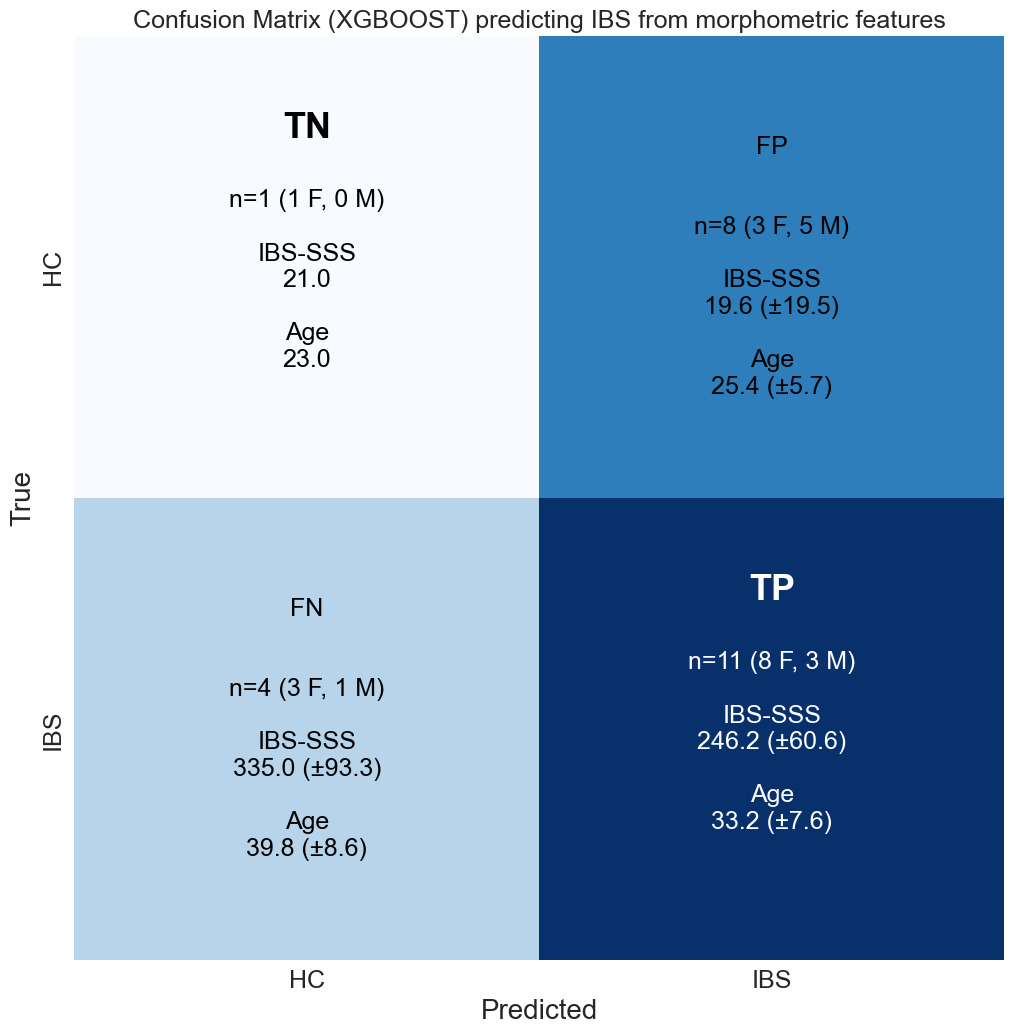

In [76]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'], labels=['0_HC', '1_IBS'])

fig, ax = plt.subplots(figsize=(12, 12))  

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


# Make placeholder text writing 3 lines of text in each center of the quadrant of the confusion matrix


# Coordinates for the text
coordinates = [(0, 0), (0, 1), (1, 0), (1, 1)]

def format_mean_std(mean, std):
    if np.isnan(std):
        return f"{mean:.1f}"
    else:
        return f"{mean:.1f} (±{std:.1f})"

texts = [
    f'\nn={len(BGA_TN)} ({F_TN} F, {M_TN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TN.mean(), IBS_SSS_TN.std())}\n\nAge\n{format_mean_std(AGE_TN.mean(), AGE_TN.std())}',
    f'FP\n\n\nn={len(BGA_FP)} ({F_FP} F, {M_FP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FP.mean(), IBS_SSS_FP.std())}\n\nAge\n{format_mean_std(AGE_FP.mean(), AGE_FP.std())}',
    f'FN\n\n\nn={len(BGA_FN)} ({F_FN} F, {M_FN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FN.mean(), IBS_SSS_FN.std())}\n\nAge\n{format_mean_std(AGE_FN.mean(), AGE_FN.std())}',
    f'\nn={len(BGA_TP)} ({F_TP} F, {M_TP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TP.mean(), IBS_SSS_TP.std())}\n\nAge\n{format_mean_std(AGE_TP.mean(), AGE_TP.std())}'
]
                                                                           
for text, (i, j) in zip(texts, coordinates):
    if (i==1 & j ==1): # TP
        plt.text(j + 0.5, i + 0.2, 'TP', ha='center', va='center', color='white', fontsize=26, fontweight='bold')       
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white', fontsize=18)
    elif (i==0 & j ==1): # FN
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white', fontsize=18)
    elif (i==1 & j ==0): # TN
        plt.text(j + 0.5, i + 0.2, 'TN', ha='center', va='center', color='black', fontsize=26, fontweight='bold') 
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=18)
    else:  # FP
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=18)




ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (XGBOOST) predicting IBS from morphometric features', fontsize=18)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=18)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)


plt.show()

#fig.savefig('../figs/Fig_3_best_model_confusion_matrix.png')

## Adding  RBANS a predictor

In [77]:
exclude_cols_2 = ['IBS_SSS', 'Age', 'Sex','Fullscale_RBANS']


sel_cols_2 = [col for col in variables if col not in exclude_cols_2]

df_X2 = df_selected[sel_cols_2]


df_X2['Outcome'] = df_selected['Group']

# Drop Group
df_X2 = df_X2.drop('Group', axis=1)

df_X2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           78 non-null     float64
 1   Left-Cerebellum-White-Matter   78 non-null     float64
 2   Left-Cerebellum-Cortex         78 non-null     float64
 3   Left-Thalamus                  78 non-null     float64
 4   Left-Caudate                   78 non-null     float64
 5   Left-Putamen                   78 non-null     float64
 6   Left-Pallidum                  78 non-null     float64
 7   Left-Hippocampus               78 non-null     float64
 8   Left-Amygdala                  78 non-null     float64
 9   Left-Accumbens-area            78 non-null     float64
 10  CSF                            78 non-null     float64
 11  Right-Cerebellum-White-Matter  78 non-null     float64
 12  Right-Cerebellum-Cortex        78 non-null     float

In [78]:
df_X2.describe().T

,count,mean,std,min,25%,50%,75%,max
eTIV,78.0,1.474885e+06,153928.840484,1.215809e+06,1.377170e+06,1.448416e+06,1.560284e+06,1.888063e+06
Left-Cerebellum-White-Matter,78.0,1.076200e-02,0.001054,8.647242e-03,1.015243e-02,1.077838e-02,1.129687e-02,1.365434e-02
Left-Cerebellum-Cortex,78.0,3.730862e-02,0.003574,3.008196e-02,3.470547e-02,3.724610e-02,3.979467e-02,4.747275e-02
Left-Thalamus,78.0,5.307679e-03,0.000490,4.015864e-03,4.947000e-03,5.369929e-03,5.647868e-03,6.334723e-03
Left-Caudate,78.0,2.485910e-03,0.000313,1.813820e-03,2.222271e-03,2.491968e-03,2.672869e-03,3.169705e-03
Left-Putamen,78.0,3.650897e-03,0.000387,2.812394e-03,3.358667e-03,3.626083e-03,3.880776e-03,4.655418e-03
Left-Pallidum,78.0,1.388744e-03,0.000123,1.033969e-03,1.317441e-03,1.384625e-03,1.475025e-03,1.723574e-03
Left-Hippocampus,78.0,2.941966e-03,0.000254,2.341288e-03,2.766887e-03,2.954976e-03,3.097828e-03,3.533187e-03
Left-Amygdala,78.0,1.221333e-03,0.000123,9.564543e-04,1.125478e-03,1.225040e-03,1.314175e-03,1.591444e-03
Left-Accumbens-area,78.0,4.330288e-04,0.000071,2.726292e-04,3.850259e-04,4.373269e-04,4.863204e-04,5.769951e-04


## Using PyCaret  (introducing the data frame df with predictors X and outcome y)

We use PyCaret to automatically prepare the data for us (using the default settings of the setup function):

Seen as a **classification problem** with the following settings:

**Predictors (X):** 'CortexVol', 'CerebralWhiteMatterVol', 'Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 'Amygdala', 'Accumbens-area', .... <all of Skrobisz et al. 2022><br>
**Target (y):** Outcome (HC, IBS)

In [79]:
df_X2.columns

Index(['eTIV', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'CSF',
       'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
       'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum',
       'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area',
       'WM-hypointensities', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
       'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent',
       'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'Memory_Index', 'Visuoaspatial_Index',
       'Verbalskills Index', 'Attention_Index', 'Recall_Index', 'Outcome'],
      dtype='object')

In [80]:
print(list(df_X2['Outcome']))
# Get the columns that exist in both df_X1 and df_fs

['IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'HC', 'HC', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC']


In [81]:
df2 = df_X2.copy()

# Recode the 'Outcome' values
df2['Outcome'] = df2['Outcome'].map({'HC': '0_HC', 'IBS': '1_IBS'})

# df2['Sex'] = df2['Sex'].map({'F': 0, 'M': 1})
# scaler = StandardScaler()
#df2['Sex_scaled'] = scaler.fit_transform(df2[['Sex']])
# df2['Sex'] = scaler.fit_transform(df2[['Sex']])


# Check the recoding
print(df2['Outcome'].value_counts())
# print(df2['Sex'].value_counts())
# print(df2['Sex_scaled'].value_counts())

Outcome
1_IBS    49
0_HC     29
Name: count, dtype: int64


In [82]:
# Import the classification machinery from PyCaret
from pycaret.classification import *

In [83]:
# Set up the ML experiments using PyCaret 
# (train-test split is done internally, number of folds is 10 by default, target is 'Outcome' being coded as 0 and 1 according to alphanumerical order of the labels)

experiment2 = setup(data = df2, target = 'Outcome', session_id=123)   # session_id is similar at random_state in scikit-learn 

,Description,Value
0,Session id,123
1,Target,Outcome
2,Target type,Binary
3,Target mapping,"0_HC: 0, 1_IBS: 1"
4,Original data shape,"(78, 42)"
5,Transformed data shape,"(78, 42)"
6,Transformed train set shape,"(54, 42)"
7,Transformed test set shape,"(24, 42)"
8,Numeric features,41
9,Preprocess,True


In [84]:
# List available classsifiers   
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


**Here's the data after the train-test split transformations have been computed during the experimental setup above:**

### **Training set**

In [85]:
# X in the training set
get_config('X_train').T

,26,19,67,10,57,64,1,39,0,70,...,4,74,65,49,38,31,21,77,27,37
eTIV,1.532154e+06,1.342095e+06,1.444822e+06,1.601471e+06,1.489224e+06,1.496966e+06,1.360310e+06,1.714155e+06,1.743419e+06,1.403646e+06,...,1.645577e+06,1.394849e+06,1.337223e+06,1.406561e+06,1.274730e+06,1.466350e+06,1.341897e+06,1.888064e+06,1.260650e+06,1.251429e+06
Left-Cerebellum-White-Matter,1.124678e-02,1.157586e-02,1.092162e-02,1.015579e-02,1.086512e-02,9.121118e-03,9.960152e-03,1.027597e-02,9.291627e-03,9.480168e-03,...,1.012787e-02,1.141550e-02,1.071631e-02,1.049183e-02,9.292082e-03,1.048877e-02,1.286015e-02,1.039859e-02,1.134002e-02,1.100853e-02
Left-Cerebellum-Cortex,3.251932e-02,4.212749e-02,4.020128e-02,3.193925e-02,3.499991e-02,3.220816e-02,3.939865e-02,3.861050e-02,3.480798e-02,3.923732e-02,...,3.437280e-02,3.190553e-02,3.636536e-02,3.726245e-02,3.236888e-02,3.974358e-02,3.804548e-02,3.080437e-02,4.296521e-02,3.454834e-02
Left-Thalamus,4.460257e-03,6.334723e-03,4.860737e-03,5.067153e-03,5.485072e-03,5.377545e-03,5.438979e-03,5.484392e-03,5.047955e-03,5.670233e-03,...,5.717142e-03,5.171097e-03,5.078584e-03,4.787991e-03,5.502496e-03,5.184779e-03,5.335209e-03,4.772138e-03,5.569190e-03,5.373457e-03
Left-Caudate,2.387162e-03,2.525455e-03,2.218543e-03,2.328546e-03,2.632244e-03,2.971277e-03,2.126573e-03,2.470663e-03,2.424030e-03,2.565818e-03,...,2.209133e-03,2.180236e-03,2.188042e-03,2.613396e-03,2.811653e-03,2.959935e-03,2.246745e-03,2.154959e-03,2.396700e-03,2.547567e-03
Left-Putamen,3.051652e-03,4.026019e-03,3.378963e-03,2.951348e-03,3.908748e-03,3.916590e-03,2.992478e-03,3.073059e-03,3.357827e-03,4.421058e-03,...,3.332083e-03,3.092163e-03,3.539200e-03,3.588185e-03,3.723532e-03,3.625124e-03,3.670849e-03,3.020714e-03,4.344901e-03,3.875649e-03
Left-Pallidum,1.232187e-03,1.723574e-03,1.229494e-03,1.261652e-03,1.476474e-03,1.370773e-03,1.318081e-03,1.384647e-03,1.248180e-03,1.503656e-03,...,1.317228e-03,1.153817e-03,1.354748e-03,1.385721e-03,1.301687e-03,1.242609e-03,1.501010e-03,1.033969e-03,1.519692e-03,1.341906e-03
Left-Hippocampus,3.058766e-03,3.262288e-03,2.854192e-03,2.635326e-03,2.846785e-03,2.613954e-03,2.999095e-03,2.856567e-03,3.098796e-03,3.272905e-03,...,2.863554e-03,2.759008e-03,3.148615e-03,2.954014e-03,3.241783e-03,2.560576e-03,2.877643e-03,2.341288e-03,3.010193e-03,3.438629e-03
Left-Amygdala,1.260774e-03,1.333885e-03,1.300368e-03,1.187783e-03,1.424299e-03,1.037165e-03,1.194580e-03,1.156021e-03,1.336569e-03,1.288430e-03,...,1.168769e-03,1.084634e-03,1.038346e-03,1.237842e-03,1.315258e-03,1.200396e-03,1.088757e-03,1.097050e-03,1.321540e-03,1.235148e-03
Left-Accumbens-area,3.651069e-04,4.185993e-04,4.459372e-04,4.495865e-04,4.936800e-04,4.800377e-04,3.904256e-04,5.016465e-04,4.131537e-04,4.764734e-04,...,4.050858e-04,3.375276e-04,3.710675e-04,5.213426e-04,5.050479e-04,4.626454e-04,2.786354e-04,4.018403e-04,4.657121e-04,4.271117e-04


In [86]:
# True labels y in the training set
print("Group:", list(get_config('y_train')))

Group: ['0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [87]:
get_config('X_train').info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 26 to 37
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           54 non-null     float32
 1   Left-Cerebellum-White-Matter   54 non-null     float32
 2   Left-Cerebellum-Cortex         54 non-null     float32
 3   Left-Thalamus                  54 non-null     float32
 4   Left-Caudate                   54 non-null     float32
 5   Left-Putamen                   54 non-null     float32
 6   Left-Pallidum                  54 non-null     float32
 7   Left-Hippocampus               54 non-null     float32
 8   Left-Amygdala                  54 non-null     float32
 9   Left-Accumbens-area            54 non-null     float32
 10  CSF                            54 non-null     float32
 11  Right-Cerebellum-White-Matter  54 non-null     float32
 12  Right-Cerebellum-Cortex        54 non-null     float32
 

In [88]:
get_config('X_train').describe()

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
count,5.400000e+01,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,1.458445e+06,0.010758,0.036852,0.005250,0.002476,0.003627,0.001380,0.002955,0.001223,0.000431,...,0.151830,0.150517,0.302347,0.042328,0.454732,93.888889,95.370370,101.425926,96.259259,98.759259
std,1.611610e+05,0.001045,0.003356,0.000502,0.000302,0.000432,0.000131,0.000268,0.000132,0.000067,...,0.009293,0.009951,0.019187,0.003053,0.027320,17.562467,12.009896,14.381070,16.251775,18.273535
min,1.215809e+06,0.008659,0.030638,0.004016,0.001895,0.002812,0.001034,0.002341,0.000956,0.000273,...,0.135025,0.132724,0.267749,0.036384,0.406023,45.000000,64.000000,57.000000,68.000000,23.000000
25%,1.363172e+06,0.010163,0.034583,0.004871,0.002214,0.003319,0.001293,0.002786,0.001121,0.000387,...,0.145036,0.143853,0.289953,0.040165,0.433336,83.000000,87.000000,93.000000,86.000000,91.250000
50%,1.413995e+06,0.010783,0.036130,0.005351,0.002425,0.003598,0.001377,0.002978,0.001233,0.000437,...,0.151963,0.150747,0.303078,0.042137,0.454858,92.500000,96.000000,99.000000,97.000000,98.500000
75%,1.520627e+06,0.011311,0.039349,0.005572,0.002678,0.003902,0.001475,0.003108,0.001315,0.000486,...,0.155961,0.155435,0.311454,0.044608,0.474296,107.250000,105.000000,113.000000,103.000000,107.750000
max,1.888064e+06,0.013593,0.045192,0.006335,0.003077,0.004655,0.001724,0.003533,0.001591,0.000531,...,0.184339,0.186245,0.370584,0.048317,0.542009,128.000000,114.000000,130.000000,155.000000,139.000000


In [89]:
get_config('X_test').describe()

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
count,2.400000e+01,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,1.511876e+06,0.010771,0.038337,0.005436,0.002509,0.003704,0.001408,0.002913,0.001218,0.000439,...,0.153732,0.152410,0.306142,0.042807,0.463027,92.041667,96.708333,94.958333,96.958333,93.791667
std,1.319499e+05,0.001094,0.003901,0.000446,0.000342,0.000260,0.000105,0.000222,0.000102,0.000079,...,0.009798,0.009673,0.019376,0.002601,0.024964,15.092409,9.247698,11.392138,15.437051,17.633908
min,1.224505e+06,0.008647,0.030082,0.004603,0.001814,0.003211,0.001258,0.002554,0.001069,0.000305,...,0.134529,0.135851,0.270380,0.037951,0.415157,60.000000,77.000000,71.000000,69.000000,47.000000
25%,1.416962e+06,0.010140,0.035938,0.005140,0.002295,0.003517,0.001326,0.002763,0.001133,0.000384,...,0.148824,0.145380,0.294905,0.040757,0.448319,83.000000,90.000000,88.000000,89.500000,82.000000
50%,1.520028e+06,0.010691,0.038554,0.005405,0.002521,0.003677,0.001398,0.002882,0.001203,0.000437,...,0.152099,0.152216,0.304314,0.043568,0.464189,87.500000,96.000000,94.000000,97.500000,93.500000
75%,1.578796e+06,0.011208,0.040950,0.005731,0.002643,0.003880,0.001460,0.003030,0.001295,0.000477,...,0.160359,0.159795,0.320713,0.044212,0.476884,106.000000,107.000000,102.750000,101.500000,108.000000
max,1.823484e+06,0.013654,0.047473,0.006206,0.003170,0.004184,0.001624,0.003361,0.001431,0.000577,...,0.172223,0.169144,0.341336,0.048184,0.529817,112.000000,110.000000,118.000000,150.000000,126.000000


In [90]:
get_config('y_train').info()

<class 'pandas.core.series.Series'>
Index: 54 entries, 26 to 37
Series name: Outcome
Non-Null Count  Dtype   
--------------  -----   
54 non-null     category
dtypes: category(1)
memory usage: 610.0 bytes


In [91]:
get_config('y_train').value_counts()

Outcome
1_IBS    34
0_HC     20
Name: count, dtype: int64

### **Test set**

In [92]:
get_config('X_test').T

,59,55,29,3,22,6,62,46,5,33,...,35,8,69,48,47,63,56,13,76,14
eTIV,1.580332e+06,1.441712e+06,1.479463e+06,1.595000e+06,1.533278e+06,1.515539e+06,1.524518e+06,1.823484e+06,1.505441e+06,1.320595e+06,...,1.570709e+06,1.224505e+06,1.386840e+06,1.403014e+06,1.762430e+06,1.641095e+06,1.544695e+06,1.578284e+06,1.609012e+06,1.415589e+06
Left-Cerebellum-White-Matter,1.131357e-02,1.059893e-02,1.226965e-02,1.045818e-02,1.078350e-02,1.084723e-02,1.273439e-02,1.133298e-02,9.659963e-03,1.022085e-02,...,1.117330e-02,1.365434e-02,1.158692e-02,9.927842e-03,1.098699e-02,9.254066e-03,1.055541e-02,8.647243e-03,1.054480e-02,1.107334e-02
Left-Cerebellum-Cortex,4.136346e-02,3.992760e-02,3.861765e-02,3.090181e-02,4.074996e-02,3.751899e-02,3.685153e-02,3.572316e-02,4.284155e-02,3.791201e-02,...,3.849072e-02,4.747275e-02,4.328956e-02,3.601019e-02,4.110222e-02,3.452640e-02,3.467130e-02,3.722975e-02,4.091922e-02,3.917648e-02
Left-Thalamus,5.163219e-03,4.938781e-03,6.194882e-03,5.802569e-03,5.667076e-03,6.124685e-03,5.207418e-03,5.279949e-03,5.335448e-03,5.720983e-03,...,5.384067e-03,6.206428e-03,5.535461e-03,4.921263e-03,4.971657e-03,5.068811e-03,4.765471e-03,5.513395e-03,5.930287e-03,5.723483e-03
Left-Caudate,2.117530e-03,2.346863e-03,3.004806e-03,2.674733e-03,2.631944e-03,2.558033e-03,2.483146e-03,2.016141e-03,2.582832e-03,2.175989e-03,...,2.559291e-03,2.798438e-03,2.241426e-03,2.509099e-03,3.114846e-03,2.533674e-03,1.813820e-03,2.460965e-03,2.500790e-03,3.169705e-03
Left-Putamen,3.422192e-03,3.455336e-03,3.942376e-03,3.621755e-03,3.825009e-03,3.616666e-03,3.719734e-03,3.681580e-03,3.880857e-03,3.941861e-03,...,3.673247e-03,3.855682e-03,4.184116e-03,3.333253e-03,4.096048e-03,3.506684e-03,3.210924e-03,4.120236e-03,3.862682e-03,3.630785e-03
Left-Pallidum,1.266000e-03,1.261278e-03,1.569691e-03,1.321504e-03,1.450096e-03,1.581879e-03,1.258497e-03,1.358608e-03,1.421644e-03,1.384603e-03,...,1.450237e-03,1.494564e-03,1.409247e-03,1.325789e-03,1.549962e-03,1.389743e-03,1.400923e-03,1.449106e-03,1.623543e-03,1.490546e-03
Left-Hippocampus,2.767393e-03,3.030217e-03,3.204000e-03,2.925203e-03,2.884344e-03,3.029549e-03,2.634998e-03,2.694074e-03,2.835117e-03,3.029241e-03,...,2.811852e-03,3.361114e-03,2.794915e-03,2.986285e-03,3.203417e-03,2.601251e-03,2.880438e-03,2.821800e-03,2.966728e-03,3.208276e-03
Left-Amygdala,1.121536e-03,1.154600e-03,1.360629e-03,1.137304e-03,1.289329e-03,1.076251e-03,1.192902e-03,1.171988e-03,1.313370e-03,1.350679e-03,...,1.118094e-03,1.430538e-03,1.248954e-03,1.106689e-03,1.238290e-03,1.069469e-03,1.158869e-03,1.279935e-03,1.334981e-03,1.347637e-03
Left-Accumbens-area,3.397387e-04,3.651215e-04,5.727753e-04,4.951096e-04,4.418639e-04,4.705916e-04,4.049150e-04,3.844839e-04,3.980894e-04,4.189779e-04,...,4.515160e-04,5.283769e-04,5.769951e-04,4.047002e-04,4.368967e-04,5.562750e-04,3.045908e-04,5.678954e-04,3.308242e-04,4.503425e-04


In [93]:
print("Outcome:", list(get_config('y_test')))

Outcome: ['1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [94]:
get_config('y_test').value_counts()

Outcome
1_IBS    15
0_HC      9
Name: count, dtype: int64

In [95]:
# Count the number of samples in the full data set by group
print(f"Full data: {df2.groupby('Outcome').size()}")

# Count the number of samples in the training set by group
df2_train = get_config('X_train')
df2_train['Outcome'] = get_config('y_train')
df2_train['Index'] = df2_train.index
df2_train['Subject'] = df_fs['Subject'][df_train['Index']]
df2_train['Sex'] = df_selected['Sex'][df_train['Index']]

# Renumber index
df2_train = df2_train.reset_index(drop=True)

print(f"\nTraining data: {df2_train.groupby('Outcome').size()}")
print(f"\nTraining data: {df2_train.groupby('Sex').size()}")

df2_train.head()    

Full data: Outcome
0_HC     29
1_IBS    49
dtype: int64

Training data: Outcome
0_HC     20
1_IBS    34
dtype: int64

Training data: Sex
F    43
M    11
dtype: int64


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,Outcome,Index,Subject,Sex
0,1532153.875,0.011247,0.032519,0.004460,0.002387,0.003052,0.001232,0.003059,0.001261,0.000365,...,0.419291,99,105,118,127,92,0_HC,26,BGA_081,F
1,1342095.000,0.011576,0.042127,0.006335,0.002525,0.004026,0.001724,0.003262,0.001334,0.000419,...,0.478924,102,102,105,98,104,0_HC,19,BGA_070,F
2,1444822.125,0.010922,0.040201,0.004861,0.002219,0.003379,0.001229,0.002854,0.001300,0.000446,...,0.452007,93,110,125,136,107,0_HC,67,BGA_157,F
3,1601471.375,0.010156,0.031939,0.005067,0.002329,0.002951,0.001262,0.002635,0.001188,0.000450,...,0.410209,66,91,118,89,82,1_IBS,10,BGA_059,F
4,1489223.750,0.010865,0.035000,0.005485,0.002632,0.003909,0.001476,0.002847,0.001424,0.000494,...,0.437845,62,64,81,95,78,1_IBS,57,BGA_143,F


In [96]:
# Count the number of samples in the full data set by group
print(f"Full data: {df2.groupby('Outcome').size()}")

# Count the number of samples in the training set by group
df2_test = get_config('X_test')
df2_test['Outcome'] = get_config('y_test')
df2_test['Index'] = df2_test.index
df2_test['Subject'] = df_fs['Subject'][df_test['Index']]
df2_test['Sex'] = df_selected['Sex'][df_test['Index']]

# Renumber index
df2_test = df2_test.reset_index(drop=True)

print(f"\nTest data: {df2_test.groupby('Outcome').size()}")
print(f"\nTest data: {df2_test.groupby('Sex').size()}")

df2_test   

Full data: Outcome
0_HC     29
1_IBS    49
dtype: int64

Test data: Outcome
0_HC      9
1_IBS    15
dtype: int64

Test data: Sex
F    15
M     9
dtype: int64


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,Outcome,Index,Subject,Sex
0,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.455646,68,87,84,77,76,1_IBS,59,BGA_145,M
1,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.464761,78,102,113,93,74,1_IBS,55,BGA_141,F
2,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.480850,109,96,97,99,126,0_HC,29,BGA_084,F
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.446639,86,97,90,98,86,1_IBS,3,BGA_050,F
4,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.482682,112,107,82,90,118,0_HC,22,BGA_076,F
5,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.459258,95,96,105,103,100,1_IBS,6,BGA_055,F
6,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.466345,109,90,95,79,104,1_IBS,62,BGA_151,F
7,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.423745,105,107,93,81,100,1_IBS,46,BGA_107,M
8,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.476372,112,107,105,88,108,0_HC,5,BGA_053,M
9,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.448879,83,96,95,110,91,1_IBS,33,BGA_089,F


## Modelling

In [98]:
%%time
#best_model = compare_models(fold=3, cross_validation=True, sort="Accuracy", n_select=1, parallel=False)
best_model2 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6867,0.6292,0.6867,0.7022,0.6693,0.2982,0.3265,0.0210
xgboost,Extreme Gradient Boosting,0.6500,0.6958,0.6500,0.6628,0.6444,0.2458,0.2587,0.0170
nb,Naive Bayes,0.6433,0.6917,0.6433,0.5481,0.5738,0.1350,0.1420,0.0110
svm,SVM - Linear Kernel,0.6267,0.5333,0.6267,0.3938,0.4833,0.0000,0.0000,0.0110
qda,Quadratic Discriminant Analysis,0.6267,0.6375,0.6267,0.3938,0.4833,0.0000,0.0000,0.0110
dummy,Dummy Classifier,0.6267,0.5000,0.6267,0.3938,0.4833,0.0000,0.0000,0.0100
lightgbm,Light Gradient Boosting Machine,0.6067,0.6000,0.6067,0.5113,0.5422,0.0791,0.0808,0.0540
rf,Random Forest Classifier,0.6033,0.5625,0.6033,0.5276,0.5486,0.0844,0.0856,0.0400
et,Extra Trees Classifier,0.5900,0.5188,0.5900,0.5314,0.5353,0.0682,0.0782,0.0310
dt,Decision Tree Classifier,0.5733,0.5292,0.5733,0.5342,0.5372,0.0586,0.0641,0.0130


CPU times: user 3.05 s, sys: 152 ms, total: 3.2 s
Wall time: 5.69 s


In [99]:
df2

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,Outcome
0,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,0.001337,0.000413,...,0.154606,0.308371,0.041267,0.426121,80,102,93,97,86,1_IBS
1,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,0.001195,0.000390,...,0.133467,0.272339,0.040830,0.490546,109,107,97,115,126,1_IBS
2,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,0.003533,0.001338,0.000482,...,0.144321,0.288940,0.047269,0.462151,83,84,113,103,100,1_IBS
3,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.167184,0.334672,0.043766,0.446639,86,97,90,98,86,1_IBS
4,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,0.002864,0.001169,0.000405,...,0.156086,0.311467,0.040728,0.441274,105,90,97,108,100,1_IBS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,0.002845,0.001187,0.000464,...,0.145517,0.291343,0.041865,0.476303,89,90,118,108,82,0_HC
74,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,0.002759,0.001085,0.000338,...,0.138465,0.279461,0.039644,0.429210,83,85,116,113,23,0_HC
75,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,0.003182,0.001591,0.000522,...,0.186245,0.370584,0.048317,0.542009,100,103,107,86,104,0_HC
76,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,0.002967,0.001335,0.000331,...,0.144735,0.294046,0.045371,0.493229,89,102,85,101,110,0_HC


In [100]:
best_model2

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [101]:
# Run XGBoost model  (here, slightly better than Dummy Classifier)
xgb2 = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,1.0000,0.8333,0.8889,0.8381,0.6667,0.7071
1,0.5000,0.7500,0.5000,0.4000,0.4444,-0.2857,-0.3162
2,0.5000,0.5000,0.5000,0.5556,0.5143,0.0000,0.0000
3,0.6667,0.8750,0.6667,0.6667,0.6667,0.2500,0.2500
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.2000,0.1667,0.2000,0.2000,0.2000,-0.6667,-0.6667
6,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
7,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
8,0.8000,1.0000,0.8000,0.8667,0.8000,0.6154,0.6667


In [102]:
#%%time
#best_model = xgboost # tune_model(xgboost)
#best_model = tune_model(best_model_not_tuned)

## Model prediction with the best_model

The `pred_best = predict_model(best_model)` line in PyCaret is used to generate predictions using the best model that was previously trained. Let's break down what this function does:

1. Purpose:
   - `predict_model()` is a PyCaret function used to make predictions on new or existing data using a trained model.

2. Input:
   - `best_model`: This is typically the model object returned by functions like `create_model()`, `tune_model()`, or `compare_models()`. It represents the trained model you want to use for predictions.

3. Default Behavior:
   - By default, if no new data is provided, `predict_model()` will use the test set that was automatically created during the `setup()` phase.

4. Output (pred_best):
   - The function returns a pandas DataFrame containing the original features, the true target values (if available), and the model's predictions.
   - It typically includes columns like:
     - Original features
     - 'Outcome' or your target column name (if available in the test set)
     - 'prediction_label': The predicted class labels
     - 'prediction_score': The probability scores for the predicted class (for classification tasks)

5. Additional Information:
   - For classification tasks, it provides probability scores for each class.
   - For regression tasks, it provides the predicted values.

6. Customization:
   - You can pass additional parameters to `predict_model()` to customize its behavior, such as specifying new data, changing the probability threshold for classification, etc.

7. Example usage:
   ```python
   # Assuming 'best_model' is your trained model
   predictions = predict_model(best_model)
   
   # To predict on new data
   new_predictions = predict_model(best_model, data=new_data)
   ```

8. Interpretation:
   - The resulting DataFrame allows you to compare the predicted values with the actual values (if available) and analyze the model's performance on the test set or new data.

9. Further Analysis:
   - After getting the predictions, you can use this DataFrame for various purposes like calculating additional metrics, creating visualizations, or performing error analysis.

In summary, `pred_best = predict_model(best_model)` generates predictions using your best model on the test set (or provided data), giving you a comprehensive DataFrame that includes both the original features and the model's predictions. This is crucial for evaluating your model's performance and understanding how it's making predictions on unseen data.

In [103]:
print(f'\n --> Model prediction with the best_model:')
pred_best2 = predict_model(best_model2)
pred_xgb2 = predict_model(xgb2)
#pred_best = predict_model(xgb)
pred_xgb2


 --> Model prediction with the best_model:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.4583,0.4222,0.4583,0.4896,0.4669,-0.0833,-0.0861


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6667,0.4667,0.6667,0.6667,0.6111,0.1795,0.2277


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,SubCortGrayVol,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,Outcome,prediction_label,prediction_score
59,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.040059,0.455646,68,87,84,77,76,1_IBS,1_IBS,0.9526
55,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.040310,0.464761,78,102,113,93,74,1_IBS,1_IBS,0.9550
29,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.046860,0.480850,109,96,97,99,126,0_HC,0_HC,0.9545
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.043766,0.446639,86,97,90,98,86,1_IBS,1_IBS,0.9943
22,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.044115,0.482682,112,107,82,90,118,0_HC,1_IBS,0.9826
6,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.045131,0.459258,95,96,105,103,100,1_IBS,1_IBS,0.9901
62,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.041054,0.466345,109,90,95,79,104,1_IBS,1_IBS,0.9494
46,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.040960,0.423745,105,107,93,81,100,1_IBS,1_IBS,0.9756
5,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.042538,0.476372,112,107,105,88,108,0_HC,1_IBS,0.9969
33,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.043886,0.448879,83,96,95,110,91,1_IBS,1_IBS,0.7224


In [104]:
# Get the list of Subject IDs based on the best model prediction
BGA_list2 = df_fs['Subject'][list(pred_xgb2.index)]
# Same as df_test[['Subject','Index']]
# Check with df_test[['Subject','Index']]
BGA_list2

59    BGA_145
55    BGA_141
29    BGA_084
3     BGA_050
22    BGA_076
6     BGA_055
62    BGA_151
46    BGA_107
5     BGA_053
33    BGA_089
16    BGA_067
42    BGA_099
54    BGA_139
50    BGA_128
35    BGA_091
8     BGA_057
69    BGA_160
48    BGA_114
47    BGA_110
63    BGA_152
56    BGA_142
13    BGA_064
76    BGA_171
14    BGA_065
Name: Subject, dtype: object

In [105]:
df2_test

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,TotalGrayVol,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,Outcome,Index,Subject,Sex
0,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.455646,68,87,84,77,76,1_IBS,59,BGA_145,M
1,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.464761,78,102,113,93,74,1_IBS,55,BGA_141,F
2,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.480850,109,96,97,99,126,0_HC,29,BGA_084,F
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.446639,86,97,90,98,86,1_IBS,3,BGA_050,F
4,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.482682,112,107,82,90,118,0_HC,22,BGA_076,F
5,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.459258,95,96,105,103,100,1_IBS,6,BGA_055,F
6,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.466345,109,90,95,79,104,1_IBS,62,BGA_151,F
7,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.423745,105,107,93,81,100,1_IBS,46,BGA_107,M
8,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.476372,112,107,105,88,108,0_HC,5,BGA_053,M
9,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.448879,83,96,95,110,91,1_IBS,33,BGA_089,F


In [106]:
# Make the pred_model a dataframe where the index is a separate columns denoted BGA
BGA_list = df2_test['Subject']  # list(pred_best.index)

df2_pred_xgb2 = pd.DataFrame()
#df_tuned_pred = pred_model.reset_index().copy()

# Get the probabilities of prediction
y_pred_proba = xgb2.predict_proba(get_config('X_test'))

# Add the BGA column from df_in corresponding to indexes in the BGA_list
df2_pred_xgb2['Subject'] = df2_test['Subject']

# Reset index in pred_model
pred_xgb2 = pred_xgb2.reset_index(drop=True)

# Add the columns of pred_model to df_tuned_pred
for col in pred_xgb2.columns:
    df2_pred_xgb2[col] = pred_xgb2[col]

df2_pred_xgb2['p(0)'] = y_pred_proba[:,0]
df2_pred_xgb2['p(1)'] = y_pred_proba[:,1]
# Rename the columns
#df_pred_best = df_pred_best.rename(columns = {'Target': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(0),p(1))'})
df2_pred_xgb2 = df2_pred_xgb2.rename(columns = {'Outcome': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(0),p(1))'})
df2_pred_xgb2


,Subject,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,True,Predicted,"max(p(0),p(1))",p(0),p(1)
0,BGA_145,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,...,68,87,84,77,76,1_IBS,1_IBS,0.9526,0.047411,0.952589
1,BGA_141,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,...,78,102,113,93,74,1_IBS,1_IBS,0.9550,0.045006,0.954994
2,BGA_084,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,...,109,96,97,99,126,0_HC,0_HC,0.9545,0.954504,0.045496
3,BGA_050,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,...,86,97,90,98,86,1_IBS,1_IBS,0.9943,0.005695,0.994305
4,BGA_076,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,...,112,107,82,90,118,0_HC,1_IBS,0.9826,0.017357,0.982643
5,BGA_055,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,...,95,96,105,103,100,1_IBS,1_IBS,0.9901,0.009886,0.990114
6,BGA_151,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,...,109,90,95,79,104,1_IBS,1_IBS,0.9494,0.050555,0.949445
7,BGA_107,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,...,105,107,93,81,100,1_IBS,1_IBS,0.9756,0.024412,0.975588
8,BGA_053,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,...,112,107,105,88,108,0_HC,1_IBS,0.9969,0.003058,0.996942
9,BGA_089,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,...,83,96,95,110,91,1_IBS,1_IBS,0.7224,0.277561,0.722439


### Four representations of the confusion matrix (best_model applied to the test set)

In [107]:
df2_pred_xgb2[['True','Predicted']].value_counts()

True   Predicted
1_IBS  1_IBS        14
0_HC   1_IBS         7
       0_HC          2
1_IBS  0_HC          1
Name: count, dtype: int64

In [108]:
# Make a cross tabulation of True and Predicted
pd.crosstab(df2_pred_xgb2['True'], df2_pred_xgb2['Predicted'])


Predicted,0_HC,1_IBS
True,,
0_HC,2,7
1_IBS,1,14


In [109]:
cm = confusion_matrix(df2_pred_xgb2['True'], df2_pred_xgb2['Predicted'])
print(cm)


[[ 2  7]
 [ 1 14]]


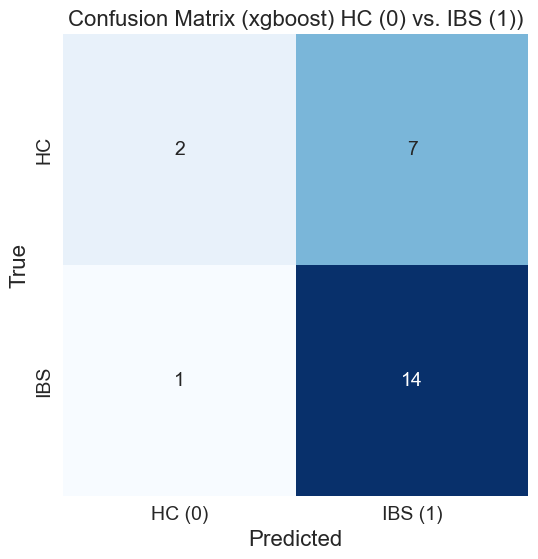

In [110]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df2_pred_xgb2['True'], df2_pred_xgb2['Predicted'])   # , labels=['0_NotImpaired', '1_Impaired'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (xgboost) HC (0) vs. IBS (1))', fontsize=16)
ax.set_title('Confusion Matrix (xgboost) HC (0) vs. IBS (1))', fontsize=16)

ax.set_xticklabels(['HC (0)', 'IBS (1)'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()


In [111]:
print(cm[1,1], cm[0,1], cm[1,0], cm[0,0])

14 7 1 2


In [112]:
# True Positive (TP)
TP = cm[1, 1]
# True Negative (TN)
TN = cm[0, 0]
# False Positive (FP)
FP = cm[0, 1]
# False Negative (FN)
FN = cm[1, 0]

print(f'TP (true positive i.e. M (1)) = {TP}\nTN (true negative i.e. F (0)) = {TN}\nFP (false pos.) = {FP}\nFN (false neg.) = {FN}\n')

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

# Balanced accuracy
BACC = (TPR + TNR)/2

#F1-score
F1 = 2/((1/PPV) + (1/TPR))
#F1 = 2*TP /(2*TP+FP+FN)
#F1 = 2*PPV*TPR/(PPV+TPR)

# Matthews correlation coefficient
MCC = ((TP*TN)-(FP*FN)) /np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Loop through the variables and print them with 2 decimals and preceede with variable name as string
var_names = ['TPR = TP/(TP+FN) (true positive rate, sensitivity, recall)', 
             'TNR = TN/(TN+FP) (true negative rate, specificity)', 
             'PPV = TP/(TP+FP) (positive predictive value, precision)', 
             'NPV = TN/(TN+FN) (negative predictive value)', 
             'FPR = FP/(FP+TN) (false positive rate)', 
             'FNR = FN/(TP+FN) (false negative rate)', 
             'FDR = FP/(TP+FP) (false discovery rate)', 
             'ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy)',
             'BACC = (Sensitivity + Specificity) / 2 (balanced accuracy)',
             'F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall)',
             'MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))']
for i, var in enumerate([TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC, BACC,F1, MCC]):
    print(var_names[i],'=', "{:.2f}".format(var))

TP (true positive i.e. M (1)) = 14
TN (true negative i.e. F (0)) = 2
FP (false pos.) = 7
FN (false neg.) = 1

TPR = TP/(TP+FN) (true positive rate, sensitivity, recall) = 0.93
TNR = TN/(TN+FP) (true negative rate, specificity) = 0.22
PPV = TP/(TP+FP) (positive predictive value, precision) = 0.67
NPV = TN/(TN+FN) (negative predictive value) = 0.67
FPR = FP/(FP+TN) (false positive rate) = 0.78
FNR = FN/(TP+FN) (false negative rate) = 0.07
FDR = FP/(TP+FP) (false discovery rate) = 0.33
ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy) = 0.67
BACC = (Sensitivity + Specificity) / 2 (balanced accuracy) = 0.58
F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall) = 0.78
MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) = 0.23


In [113]:
print(df2_pred_xgb2.columns)


Index(['Subject', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'Memory_Index', 'Visuoaspatial_Index',
       'Verbalskills Index', 'Attention_Index', 'Recall_Index', 'True',
       'Predicted', 'max(p(0),p(1))', 'p(0)', 'p(1)'],
      dtype='object')


### The following book-keeping is modified from the IBS-distress project

In [114]:
df2_pred2 = df2_pred_xgb2.copy()
df_in = df_fs.copy()

print(df_in['IBS_SSS'].value_counts())

IBS_SSS
       6
0      3
405    2
21     2
233    2
      ..
418    1
16     1
325    1
277    1
53     1
Name: count, Length: 66, dtype: int64


In [115]:
# Make a list of all BG_ID values for which their 'IBS SSS' is missing

df_fs_rbans = pd.read_csv('../../Ben/Data/fs6_fs7_rbans.csv')

missing_IBS_SSS_in_al_34 = sorted(['BGA_114', 'BGA_092', 'BGA_110', 'BGA_062', 'BGA_056', 'BGA_081'])

# Get the BG_ID for which IBS SSS is in the list
df_fs_rbans[df_fs_rbans['BG_ID'].isin(missing_IBS_SSS_in_al_34)][['BG_ID','IBS SSS', 'Age', 'Gender1', 'Group', 'Diagnose (1=D, 2=C, 3=M, 0=HC)  ']]

,BG_ID,IBS SSS,Age,Gender1,Group,"Diagnose (1=D, 2=C, 3=M, 0=HC)"
7,BGA_056,,52,female,1,1
13,BGA_062,,26,female,1,2
27,BGA_081,,49,female,2,0
37,BGA_092,,39,female,2,0
48,BGA_110,,22,male,2,0
49,BGA_114,,37,female,1,2


### Imputation of `IBS SSS` according to Gender1 and Group

In [116]:
import numpy as np
import pandas as pd

def clean_and_convert(x):
    if pd.isna(x) or str(x).strip() == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Clean and convert the IBS SSS data in the dataframe
df_fs_rbans['IBS SSS Clean'] = df_fs_rbans['IBS SSS'].apply(clean_and_convert)

# Now use the cleaned column to calculate the median
median_ibs_sss_1 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_056) Group 1 females: {median_ibs_sss_1}")

median_ibs_sss_2 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_062) Group 1 females: {median_ibs_sss_2}")

median_ibs_sss_3 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_081) Group 2 females: {median_ibs_sss_3}")

median_ibs_sss_4 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_092) Group 2 females: {median_ibs_sss_4}")

median_ibs_sss_5 = df_fs_rbans[(df_fs_rbans['Group'] == 2) & 
                             (df_fs_rbans['Gender1'] == 'male')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_110) Group 2 males: {median_ibs_sss_5}")

median_ibs_sss_6 = df_fs_rbans[(df_fs_rbans['Group'] == 1) & 
                             (df_fs_rbans['Gender1'] == 'female')]['IBS SSS Clean'].median()

print(f"Median IBS SSS for (BGA_114) Group 1 fmales: {median_ibs_sss_6}")

Median IBS SSS for (BGA_056) Group 1 females: 272.0
Median IBS SSS for (BGA_062) Group 1 females: 272.0
Median IBS SSS for (BGA_081) Group 2 females: 26.0
Median IBS SSS for (BGA_092) Group 2 females: 26.0
Median IBS SSS for (BGA_110) Group 2 males: 15.0
Median IBS SSS for (BGA_114) Group 1 fmales: 272.0


In [117]:
# Make the imputations
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_056', 'IBS SSS Clean'] = median_ibs_sss_1
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_062', 'IBS SSS Clean'] = median_ibs_sss_2
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_081', 'IBS SSS Clean'] = median_ibs_sss_3
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_092', 'IBS SSS Clean'] = median_ibs_sss_4
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_110', 'IBS SSS Clean'] = median_ibs_sss_5
df_fs_rbans.loc[df_fs_rbans['BG_ID'] == 'BGA_114', 'IBS SSS Clean'] = median_ibs_sss_6

df_fs_rbans['IBS SSS Clean'].describe()

count     81.000000
mean     181.765432
std      133.072562
min        0.000000
25%       32.000000
50%      213.000000
75%      272.000000
max      418.000000
Name: IBS SSS Clean, dtype: float64

In [118]:
for i, s in enumerate(missing_IBS_SSS_in_al_34):
    df_in.loc[df_in['Subject'] == s, 'IBS_SSS'] = df_fs_rbans.loc[df_fs_rbans['BG_ID'] == s, 'IBS SSS Clean'].values[0]


df_in['IBS_SSS'].describe()

count      78.0
unique     68.0
top       272.0
freq        3.0
Name: IBS_SSS, dtype: float64

In [119]:
df_in

,Subject,Group,Sex,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,...,SubCortGrayVol,TotalGrayVol,Age,IBS_SSS,Fullscale_RBANS,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index
0,BGA_046,IBS,M,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,...,0.041267,0.426121,38,195,100,80,102,93,97,86
1,BGA_047,IBS,F,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,...,0.040830,0.490546,19,325,116,109,107,97,115,126
2,BGA_048,IBS,F,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,...,0.047269,0.462151,34,326,95,83,84,113,103,100
3,BGA_050,IBS,F,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,...,0.043766,0.446639,44,357,87,86,97,90,98,86
4,BGA_051,IBS,M,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,...,0.040728,0.441274,38,293,100,105,90,97,108,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,F,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,...,0.041865,0.476303,19,56,93,89,90,118,108,82
74,BGA_167,HC,F,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,...,0.039644,0.429210,52,25,97,83,85,116,113,23
75,BGA_168,HC,F,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,...,0.048317,0.542009,50,21,100,100,103,107,86,104
76,BGA_171,HC,M,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,...,0.045371,0.493229,21,32,96,89,102,85,101,110


In [120]:
import numpy as np
import pandas as pd

def clean_and_convert(x):
    if pd.isna(x) or str(x).strip() == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Clean and convert the IBS_SSS data in df_in
df_in['IBS_SSS_clean'] = df_in['IBS_SSS'].apply(clean_and_convert)

# Now use the cleaned column for further operations
df_in['IBS_SSS_clean'] = df_in['IBS_SSS_clean'].astype(float)

print(df_in['IBS_SSS_clean'].describe())

# Print some additional information
print("\nNumber of valid IBS_SSS scores:")
valid_scores = df_in['IBS_SSS_clean'].notna()
print(f"{valid_scores.sum()} out of {len(valid_scores)}")

# Print the distribution of IBS_SSS scores
print("\nDistribution of IBS_SSS scores:")
print(df_in['IBS_SSS_clean'].value_counts(bins=5, normalize=True))

# Check for any remaining non-numeric values
non_numeric = df_in[pd.to_numeric(df_in['IBS_SSS_clean'], errors='coerce').isna()]
if len(non_numeric) > 0:
    print("\nRows with non-numeric values in IBS_SSS_clean:")
    print(non_numeric[['Subject', 'IBS_SSS', 'IBS_SSS_clean']])

count     78.000000
mean     183.166667
std      133.998877
min        0.000000
25%       29.750000
50%      217.000000
75%      272.000000
max      418.000000
Name: IBS_SSS_clean, dtype: float64

Number of valid IBS_SSS scores:
78 out of 78

Distribution of IBS_SSS scores:
(-0.419, 83.6]    0.371795
(167.2, 250.8]    0.269231
(250.8, 334.4]    0.217949
(334.4, 418.0]    0.128205
(83.6, 167.2]     0.012821
Name: proportion, dtype: float64


In [121]:
# Find BGA for each of the quadrants of the confusion matrix

BGA_TP = list(df2_pred2[(df2_pred2['Predicted'] == '1_IBS') & (df2_pred2['True'] == '1_IBS')]['Subject'])
BGA_TN = list(df2_pred2[(df2_pred2['Predicted'] == '0_HC') & (df2_pred2['True'] == '0_HC')]['Subject'])
BGA_FP = list(df2_pred2[(df2_pred2['Predicted'] == '1_IBS') & (df2_pred2['True'] == '0_HC')]['Subject'])
BGA_FN = list(df2_pred2[(df2_pred2['Predicted'] == '0_HC') & (df2_pred2['True'] == '1_IBS')]['Subject'])

print(f'BGA_TP: {BGA_TP} (n={len(BGA_TP)})')
print(f'BGA_TN: {BGA_TN} (n={len(BGA_TN)})')
print(f'BGA_FP: {BGA_FP} (n={len(BGA_FP)})')
print(f'BGA_FN: {BGA_FN} (n={len(BGA_FN)})')

# Find IBS-SSS in df_in  for which BGA is in BGA_TP
IBS_SSS_TP = df_in[df_in['Subject'].isin(BGA_TP)]['IBS_SSS_clean']
IBS_SSS_TN = df_in[df_in['Subject'].isin(BGA_TN)]['IBS_SSS_clean'] 
IBS_SSS_FP = df_in[df_in['Subject'].isin(BGA_FP)]['IBS_SSS_clean']
IBS_SSS_FN = df_in[df_in['Subject'].isin(BGA_FN)]['IBS_SSS_clean']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (IBS-SSS mean (std)): {IBS_SSS_TP.mean().round(1)} (±{IBS_SSS_TP.std().round(1)})")
print(f"TN (IBS-SSS mean (std)): {IBS_SSS_TN.mean().round(1)} (±{IBS_SSS_TN.std().round(1)})")
print(f"FP (IBS-SSS mean (std)): {IBS_SSS_FP.mean().round(1)} (±{IBS_SSS_FP.std().round(1)})")
print(f"FN (IBS-SSS mean (std)): {IBS_SSS_FN.mean().round(1)} (±{IBS_SSS_FN.std().round(1)})")

# Find Age in df_in for which BGA is in BGA_TP
AGE_TP = df_in[df_in['Subject'].isin(BGA_TP)]['Age']
AGE_TN = df_in[df_in['Subject'].isin(BGA_TN)]['Age'] 
AGE_FP = df_in[df_in['Subject'].isin(BGA_FP)]['Age']
AGE_FN = df_in[df_in['Subject'].isin(BGA_FN)]['Age']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (Age mean (std)): {AGE_TP.mean().round(1)} (±{AGE_TP.std().round(1)})")
print(f"TN (Age mean (std)): {AGE_TN.mean().round(1)} (±{AGE_TN.std().round(1)})")
print(f"FP (Age mean (std)): {AGE_FP.mean().round(1)} (±{AGE_FP.std().round(1)})")
print(f"FN (Age mean (std)): {AGE_FN.mean().round(1)} (±{AGE_FN.std().round(1)})")


# Intialize value counts to 0 for each Group HC and IBS

# Find Sex (GROUP) in df_in  for which BGA is in BGA_TP
SEX_TP = df_in[df_in['Subject'].isin(BGA_TP)].groupby(['Sex'])
SEX_TN = df_in[df_in['Subject'].isin(BGA_TN)].groupby(['Sex']) 
SEX_FP = df_in[df_in['Subject'].isin(BGA_FP)].groupby(['Sex'])
SEX_FN = df_in[df_in['Subject'].isin(BGA_FN)].groupby(['Sex'])


def ensure_F_M(group_counts):
    group_counts['F'] = group_counts.get('F', 0)
    group_counts['M'] = group_counts.get('M', 0)
    return group_counts

# For TP
SEX_TP_counts = SEX_TP.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_TP_counts = ensure_F_M(SEX_TP_counts)
F_TP = SEX_TP_counts['F']
M_TP = SEX_TP_counts['M']

# For TN
SEX_TN_counts = SEX_TN.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_TN_counts = ensure_F_M(SEX_TN_counts)
F_TN = SEX_TN_counts['F']
M_TN = SEX_TN_counts['M']

# For FP
SEX_FP_counts = SEX_FP.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_FP_counts = ensure_F_M(SEX_FP_counts)
F_FP = SEX_FP_counts['F']
M_FP = SEX_FP_counts['M']

# For FN
SEX_FN_counts = SEX_FN.size().reset_index(name='count').set_index('Sex')['count'].to_dict()
SEX_FN_counts = ensure_F_M(SEX_FN_counts)
F_FN = SEX_FN_counts['F']
M_FN = SEX_FN_counts['M']

print("SEX_TP_counts:", SEX_TP_counts)
print("SEX_TN_counts:", SEX_TN_counts)
print("SEX_FP_counts:", SEX_FP_counts)
print("SEX_FN_counts:", SEX_FN_counts)

print(f"TP: F = {F_TP}, M = {M_TP}")
print(f"TN: F = {F_TN}, M = {M_TN}")
print(f"FP: F = {F_FP}, M = {M_FP}")
print(f"FN: F = {F_FN}, M = {M_FN}")


BGA_TP: ['BGA_145', 'BGA_141', 'BGA_050', 'BGA_055', 'BGA_151', 'BGA_107', 'BGA_089', 'BGA_067', 'BGA_139', 'BGA_128', 'BGA_057', 'BGA_160', 'BGA_114', 'BGA_152'] (n=14)
BGA_TN: ['BGA_084', 'BGA_065'] (n=2)
BGA_FP: ['BGA_076', 'BGA_053', 'BGA_099', 'BGA_091', 'BGA_110', 'BGA_064', 'BGA_171'] (n=7)
BGA_FN: ['BGA_142'] (n=1)
TP (IBS-SSS mean (std)): 271.6 (±81.0)
TN (IBS-SSS mean (std)): 19.0 (±2.8)
FP (IBS-SSS mean (std)): 20.0 (±21.0)
FN (IBS-SSS mean (std)): 245.0 (±nan)
TP (Age mean (std)): 34.1 (±7.7)
TN (Age mean (std)): 23.0 (±0.0)
FP (Age mean (std)): 25.7 (±6.1)
FN (Age mean (std)): 47.0 (±nan)
SEX_TP_counts: {'F': 11, 'M': 3}
SEX_TN_counts: {'F': 2, 'M': 0}
SEX_FP_counts: {'F': 2, 'M': 5}
SEX_FN_counts: {'M': 1, 'F': 0}
TP: F = 11, M = 3
TN: F = 2, M = 0
FP: F = 2, M = 5
FN: F = 0, M = 1


In [122]:
print(IBS_SSS_TP.to_list())

[357.0, 158.0, 264.0, 178.0, 418.0, 228.0, 272.0, 231.0, 413.0, 298.0, 236.0, 304.0, 181.0, 265.0]


### Figure: Confusion matrix with annotations (Morphometry + RBANS predictors)

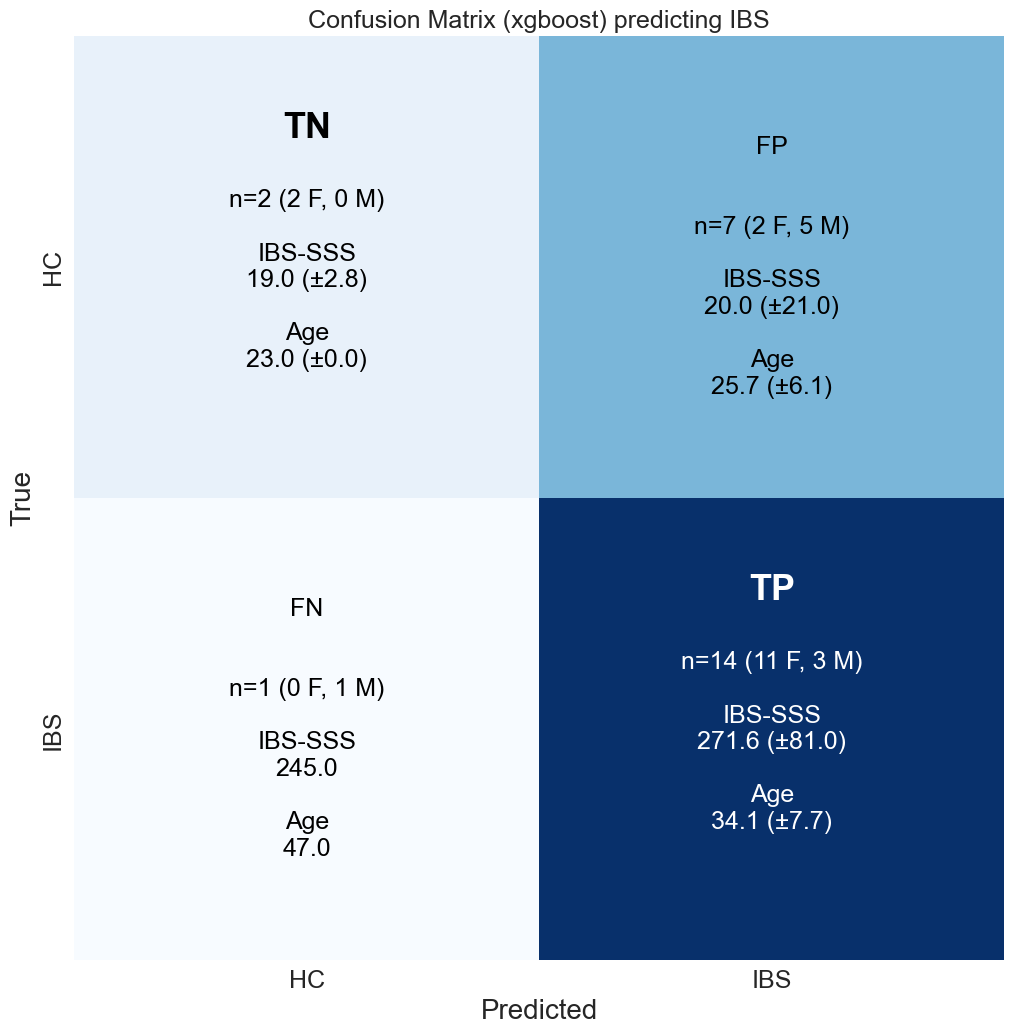

In [123]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df2_pred_xgb2['True'], df2_pred_xgb2['Predicted'], labels=['0_HC', '1_IBS'])

fig, ax = plt.subplots(figsize=(12, 12))  

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


# Make placeholder text writing 3 lines of text in each center of the quadrant of the confusion matrix


# Coordinates for the text
coordinates = [(0, 0), (0, 1), (1, 0), (1, 1)]

def format_mean_std(mean, std):
    if np.isnan(std):
        return f"{mean:.1f}"
    else:
        return f"{mean:.1f} (±{std:.1f})"

texts = [
    f'\nn={len(BGA_TN)} ({F_TN} F, {M_TN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TN.mean(), IBS_SSS_TN.std())}\n\nAge\n{format_mean_std(AGE_TN.mean(), AGE_TN.std())}',
    f'FP\n\n\nn={len(BGA_FP)} ({F_FP} F, {M_FP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FP.mean(), IBS_SSS_FP.std())}\n\nAge\n{format_mean_std(AGE_FP.mean(), AGE_FP.std())}',
    f'FN\n\n\nn={len(BGA_FN)} ({F_FN} F, {M_FN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FN.mean(), IBS_SSS_FN.std())}\n\nAge\n{format_mean_std(AGE_FN.mean(), AGE_FN.std())}',
    f'\nn={len(BGA_TP)} ({F_TP} F, {M_TP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TP.mean(), IBS_SSS_TP.std())}\n\nAge\n{format_mean_std(AGE_TP.mean(), AGE_TP.std())}'
]
                                                                           
for text, (i, j) in zip(texts, coordinates):
    if (i==1 & j ==1): # TP
        plt.text(j + 0.5, i + 0.2, 'TP', ha='center', va='center', color='white', fontsize=26, fontweight='bold')       
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white', fontsize=18)
    elif (i==0 & j ==1): # FN
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white', fontsize=18)
    elif (i==1 & j ==0): # TN
        plt.text(j + 0.5, i + 0.2, 'TN', ha='center', va='center', color='black', fontsize=26, fontweight='bold') 
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=18)
    else:  # FP
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=18)




ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (xgboost) predicting IBS', fontsize=18)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=18)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)


plt.show()

#fig.savefig('../figs/Fig_3_best_model_confusion_matrix.png')

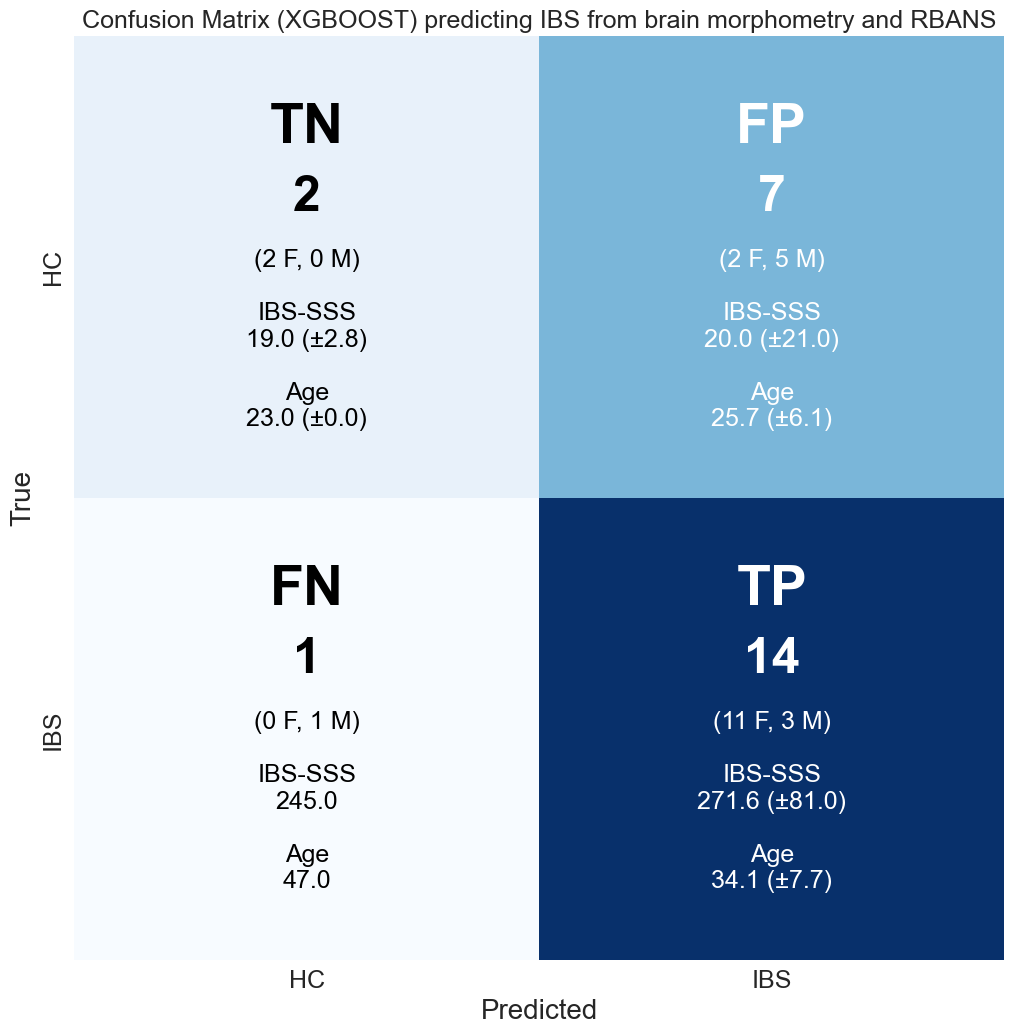

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix from df_pred    
cm = confusion_matrix(df2_pred_xgb2['True'], df2_pred_xgb2['Predicted'], labels=['0_HC', '1_IBS'])

fig, ax = plt.subplots(figsize=(12, 12))  

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})

# Coordinates for the text
coordinates = [(0, 0), (0, 1), (1, 0), (1, 1)]

def format_mean_std(mean, std):
    if np.isnan(std):
        return f"{mean:.1f}"
    else:
        return f"{mean:.1f} (±{std:.1f})"

# Updated n values
n_values = [2, 7, 1, 14]  # TN, FP, FN, TP

texts = [
    f'TN\n\n({F_TN} F, {M_TN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TN.mean(), IBS_SSS_TN.std())}\n\nAge\n{format_mean_std(AGE_TN.mean(), AGE_TN.std())}',
    f'FP\n\n({F_FP} F, {M_FP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FP.mean(), IBS_SSS_FP.std())}\n\nAge\n{format_mean_std(AGE_FP.mean(), AGE_FP.std())}',
    f'FN\n\n({F_FN} F, {M_FN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FN.mean(), IBS_SSS_FN.std())}\n\nAge\n{format_mean_std(AGE_FN.mean(), AGE_FN.std())}',
    f'TP\n\n({F_TP} F, {M_TP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TP.mean(), IBS_SSS_TP.std())}\n\nAge\n{format_mean_std(AGE_TP.mean(), AGE_TP.std())}'
]
                                                                           
for text, (i, j), n in zip(texts, coordinates, n_values):
    # Determine text color
    if (i == 1 and j == 1) or (i == 0 and j == 1):  # TP or FP
        color = 'white'
    else:  # TN or FN
        color = 'black'
    
    # Display TN, FP, FN, TP in large font
    plt.text(j + 0.5, i + 0.2, text[:2], ha='center', va='center', color=color, fontsize=40, fontweight='bold')
    
    # Display n value
    plt.text(j + 0.5, i + 0.35, str(n), ha='center', va='center', color=color, fontsize=36, fontweight='bold')
    
    # Display other information
    plt.text(j + 0.5, i + 0.6, text[2:], ha='center', va='center', color=color, fontsize=18)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (XGBOOST) predicting IBS from brain morphometry and RBANS', fontsize=18)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=18)

# Increase xlabel and ylabel size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.show()

/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/fig.savefig('annotated_xgboost_confusion_matrix_using_ASEG_and_RBANS.png')

fig.savefig('../figs/annotated_xgboost_confusion_matrix_using_ASEG_and_RBANS.png')



# Plot as pdf in hig res
fig.savefig('../figs/annotated_xgboost_confusion_matrix_using_ASEG_and_RBANS.pdf', dpi=300)

In [125]:
# Assuming df2_pred_xgb2 contains the true labels and predictions
# and that it has a 'Subject' column (if not, replace 'Subject' with the appropriate identifier)

# True Negatives (TN): True label is 0_HC, Predicted is 0_HC
TN_subjects = df2_pred_xgb2[(df2_pred_xgb2['True'] == '0_HC') & (df2_pred_xgb2['Predicted'] == '0_HC')]['Subject'].tolist()

# False Positives (FP): True label is 0_HC, Predicted is 1_IBS
FP_subjects = df2_pred_xgb2[(df2_pred_xgb2['True'] == '0_HC') & (df2_pred_xgb2['Predicted'] == '1_IBS')]['Subject'].tolist()

# False Negatives (FN): True label is 1_IBS, Predicted is 0_HC
FN_subjects = df2_pred_xgb2[(df2_pred_xgb2['True'] == '1_IBS') & (df2_pred_xgb2['Predicted'] == '0_HC')]['Subject'].tolist()

# True Positives (TP): True label is 1_IBS, Predicted is 1_IBS
TP_subjects = df2_pred_xgb2[(df2_pred_xgb2['True'] == '1_IBS') & (df2_pred_xgb2['Predicted'] == '1_IBS')]['Subject'].tolist()

# Print the results
print("True Negatives (TN):")
print(TN_subjects)
print("\nFalse Positives (FP):")
print(FP_subjects)
print("\nFalse Negatives (FN):")
print(FN_subjects)
print("\nTrue Positives (TP):")
print(TP_subjects)

# If you want to save these lists to a file:
with open('../data/confusion_matrix_subjects_TN2_FP7_FN1_TP14.txt', 'w') as f:
    f.write("True Negatives (TN):\n")
    f.write(', '.join(map(str, TN_subjects)) + "\n\n")
    f.write("False Positives (FP):\n")
    f.write(', '.join(map(str, FP_subjects)) + "\n\n")
    f.write("False Negatives (FN):\n")
    f.write(', '.join(map(str, FN_subjects)) + "\n\n")
    f.write("True Positives (TP):\n")
    f.write(', '.join(map(str, TP_subjects)) + "\n")

print("Subject lists have been saved to 'confusion_matrix_subjects.txt'")


True Negatives (TN):
['BGA_084', 'BGA_065']

False Positives (FP):
['BGA_076', 'BGA_053', 'BGA_099', 'BGA_091', 'BGA_110', 'BGA_064', 'BGA_171']

False Negatives (FN):
['BGA_142']

True Positives (TP):
['BGA_145', 'BGA_141', 'BGA_050', 'BGA_055', 'BGA_151', 'BGA_107', 'BGA_089', 'BGA_067', 'BGA_139', 'BGA_128', 'BGA_057', 'BGA_160', 'BGA_114', 'BGA_152']
Subject lists have been saved to 'confusion_matrix_subjects.txt'


In [126]:
import pandas as pd
import numpy as np

def print_quadrant_info(df, condition, quadrant_name):
    subjects = df[condition]
    n_subjects = len(subjects)
    
    print(f"{quadrant_name}:")
    print(f"Number of subjects: {n_subjects}")
    
    # Check if 'Age' column exists
    if 'Age' in subjects.columns:
        mean_age = subjects['Age'].mean()
        std_age = subjects['Age'].std()
        print(f"Age: {mean_age:.2f} ± {std_age:.2f}")
    
    # Check if 'IBS_SSS_clean' column exists
    if 'IBS_SSS_clean' in subjects.columns:
        mean_ibs_sss = subjects['IBS_SSS_clean'].mean()
        std_ibs_sss = subjects['IBS_SSS_clean'].std()
        print(f"IBS_SSS_clean: {mean_ibs_sss:.2f} ± {std_ibs_sss:.2f}")
        print("Individual IBS_SSS_clean scores:")
        for subject, score in subjects['IBS_SSS_clean'].items():
            print(f"  Subject {subject}: {score}")
    
    print("Subjects:", ", ".join(subjects.index.astype(str)))
    print()

# True Negatives (TN): True label is 0_HC, Predicted is 0_HC
TN_condition = (df2_pred_xgb2['True'] == '0_HC') & (df2_pred_xgb2['Predicted'] == '0_HC')
print_quadrant_info(df2_pred_xgb2, TN_condition, "True Negatives (TN)")

# False Positives (FP): True label is 0_HC, Predicted is 1_IBS
FP_condition = (df2_pred_xgb2['True'] == '0_HC') & (df2_pred_xgb2['Predicted'] == '1_IBS')
print_quadrant_info(df2_pred_xgb2, FP_condition, "False Positives (FP)")

# False Negatives (FN): True label is 1_IBS, Predicted is 0_HC
FN_condition = (df2_pred_xgb2['True'] == '1_IBS') & (df2_pred_xgb2['Predicted'] == '0_HC')
print_quadrant_info(df2_pred_xgb2, FN_condition, "False Negatives (FN)")

# True Positives (TP): True label is 1_IBS, Predicted is 1_IBS
TP_condition = (df2_pred_xgb2['True'] == '1_IBS') & (df2_pred_xgb2['Predicted'] == '1_IBS')
print_quadrant_info(df2_pred_xgb2, TP_condition, "True Positives (TP)")

True Negatives (TN):
Number of subjects: 2
Subjects: 2, 23

False Positives (FP):
Number of subjects: 7
Subjects: 4, 8, 11, 14, 18, 21, 22

False Negatives (FN):
Number of subjects: 1
Subjects: 20

True Positives (TP):
Number of subjects: 14
Subjects: 0, 1, 3, 5, 6, 7, 9, 10, 12, 13, 15, 16, 17, 19



## Feature importance (Random Forest: Gini impurity)

Random Forest is a powerful ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. One of its notable capabilities is the ability to assess the importance of features in a dataset with respect to the prediction task it is performing. Scikit-learn, a popular machine learning library in Python, provides tools to measure this feature importance in Random Forest models, offering insights into which features are contributing most to the model's predictions.

### Understanding Feature Importance

Feature importance in the context of a Random Forest model refers to a score assigned to each feature, indicating how useful or valuable each feature was in the construction of the decision trees within the model. The importance of a feature is directly linked to how much it contributes to reducing uncertainty or impurity in the data when making splits in the decision trees. The more a feature decreases the impurity, the more important it is considered to be.

### How Scikit-learn Calculates Feature Importance

Scikit-learn uses a straightforward method for calculating feature importance in Random Forest models, which can be summarized as follows:

1. **Impurity Decrease**: The core metric used by scikit-learn for calculating feature importance is the decrease in node impurity (e.g., Gini impurity for classification tasks, mean squared error for regression tasks) weighted by the probability of reaching that node. The node probability is estimated by the number of samples that pass through the node divided by the total number of samples. The feature importance of a specific feature is computed by aggregating the decrease in impurity over all the nodes where the feature is used to make a split, normalized by the sum of all feature importance scores to ensure they sum up to one.

2. **Aggregation Across Trees**: Since a Random Forest is comprised of many decision trees, scikit-learn averages the feature importance scores across all the trees in the forest to get a more robust estimate of the overall importance of each feature.

### Interpreting Feature Importance

- **High Importance**: Features with higher scores are considered more important for making predictions with the model. These features have a greater impact on the outcome of the model and are used more frequently or effectively to split the data in the trees.
  
- **Low Importance**: Conversely, features with lower scores are deemed less important and have a minimal impact on the model's predictions.

### Caveats and Considerations

While feature importance can provide valuable insights into your model, it's essential to approach the interpretation of these scores with a critical mindset:

- **Bias Towards High-Cardinality Features**: Random Forest's method of calculating feature importance can be biased towards numerical features with a high cardinality or categorical features with many levels. Such features may appear to be more important simply because they provide more unique split points, not necessarily because they are more predictive.

- **Correlated Features**: When features are highly correlated, the importance can be unevenly distributed among them, sometimes leading to misleading conclusions about the relative importance of correlated features.

- **Data Leakage**: Features with artificially high importance scores might be indicative of data leakage, where information from outside the training dataset is inadvertently used to make predictions, leading to overly optimistic performance estimates.



Feature importance in Random Forest models, as implemented in scikit-learn, provides a useful tool for understanding the influence of different features on the model's predictions. By analyzing these importance scores, one can gain insights into the data and the model's decision-making process. However, it's important to interpret these scores within the context of your dataset and model, considering potential biases and the dynamics of feature interactions.

The feature importance scores generated by a Random Forest model in scikit-learn are **derived from the model's training process**; thus, they are applied to and calculated based on the training set. During the training of the Random Forest, the algorithm evaluates how each feature contributes to the purity of the split (i.e., reducing impurity such as Gini impurity** for classification tasks or mean squared error for regression tasks) for each decision tree within the forest. The feature importance scores reflect the average effectiveness of each feature in improving the decision-making across all trees in the model.

### Key Points:
- **Training Set Application**: The calculation of feature importance is inherently tied to how the Random Forest model is built from the training data. It assesses the impact of each feature within the context of the model's learning process, specifically how well it helps to split the training data into more homogeneous or "pure" subsets.

- **Reflects Training Data Insights**: Because feature importance scores are based on the training data, they provide insights into which features were most informative for modeling the patterns within the training set. This can be crucial for understanding the model's behavior on data it was trained on.

- **Not Directly Applied to Test Set**: Feature importance scores do not directly reflect the model's performance or the importance of features on the test set. However, these scores can still be informative when evaluating the model's generalization to unseen data, as features deemed important during training are expected to play significant roles in predictions on new data.

### Practical Implications:
- **Model Interpretation**: Feature importance scores help in interpreting the model by identifying which features it relies on most for making predictions. This can inform feature selection and engineering efforts for model improvement.

- **Generalization Concerns**: While feature importance provides valuable insights, it's crucial to validate that the features deemed important during training also contribute effectively to the model's performance on unseen data (the test set). Discrepancies might suggest overfitting to the training data or the need for model adjustments.

- **Cross-validation**: To obtain a more robust assessment of feature importance that reflects both training and test performance, one might consider using techniques like cross-validation. This approach can help in understanding how feature importance varies across different subsets of the data and in assessing the model's generalization capability.

In summary, while the Random Forest feature importance is calculated based on the training data, its implications extend beyond, offering insights into model interpretation, feature relevance, and potential areas for improving model generalization.

## Feature importance (XGBClassification: Gain)

When `best_model` is an XGBClassifier (from the XGBoost library), the `feature_importances_` attribute provides a measure of feature importance based on the model's internal structure. For XGBoost, this typically refers to the "Gain" importance. Here's a breakdown of how it works:

1. Calculation Method:
   The `feature_importances_` in XGBoost is calculated using the "Gain" method by default. Gain represents the improvement in accuracy brought by a feature to the branches it is on.

2. Gain Importance:
   - For each feature, the gain is calculated as the improvement in accuracy that the feature brings.
   - This is done by measuring the loss reduction (or gain in the prediction accuracy) that comes from splitting on this feature.
   - The gain is accumulated for each feature across all trees in the ensemble.

3. Normalization:
   - The raw gain values are typically normalized so that the sum of all feature importances equals 1 (or 100%).
   - This normalization makes it easier to interpret the relative importance of features.

4. Interpretation:
   - Higher values indicate more important features.
   - The importance is relative, meaning a feature with importance 0.2 is twice as important for the model's predictions as a feature with importance 0.1.

5. Advantages:
   - It takes into account both the frequency of a feature being used for splitting and the improvement in accuracy it brings.
   - It's generally more reliable than just counting the number of times a feature is used for splitting.

6. Considerations:
   - This method can sometimes overestimate the importance of high-cardinality features (features with many unique values).
   - It doesn't capture feature interactions explicitly, though the tree structure does account for some interaction effects.

7. Accessing in XGBoost:
   ```python
   importances = best_model.feature_importances_
   ```

8. Alternative Methods:
   XGBoost also supports other feature importance methods like "Weight" (number of times a feature appears in trees) and "Cover" (number of samples affected by splits using the feature), but these are not directly accessible through the `feature_importances_` attribute.

It's worth noting that while `feature_importances_` provides valuable insights, it's often beneficial to use it in conjunction with other interpretability methods like SHAP values for a more comprehensive understanding of feature impacts in your XGBoost model.

In [127]:
importances2 = xgb2.feature_importances_
importances2.round(3)

array([0.003, 0.084, 0.031, 0.004, 0.   , 0.053, 0.039, 0.05 , 0.012,
       0.006, 0.004, 0.   , 0.06 , 0.002, 0.065, 0.016, 0.051, 0.033,
       0.04 , 0.   , 0.087, 0.006, 0.062, 0.004, 0.   , 0.02 , 0.002,
       0.   , 0.036, 0.004, 0.   , 0.062, 0.042, 0.   , 0.006, 0.006,
       0.   , 0.   , 0.061, 0.011, 0.039], dtype=float32)

In [128]:
list(df2.columns)

['eTIV',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'CSF',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'WM-hypointensities',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'BrainSegVolNotVent',
 'lhCortexVol',
 'rhCortexVol',
 'CortexVol',
 'lhCerebralWhiteMatterVol',
 'rhCerebralWhiteMatterVol',
 'CerebralWhiteMatterVol',
 'SubCortGrayVol',
 'TotalGrayVol',
 'Memory_Index',
 'Visuoaspatial_Index',
 'Verbalskills Index',
 'Attention_Index',
 'Recall_Index',
 'Outcome']

In [129]:
# Find index of those with highest importance, sorted from largest to smallest:
indices2 = np.argsort(importances2)[::-1]
indices2

array([20,  1, 14, 22, 31, 38, 12,  5, 16,  7, 32, 18, 40,  6, 28, 17,  2,
       25, 15,  8, 39,  9, 34, 35, 21, 29, 10, 23,  3,  0, 13, 26, 11, 33,
       30, 36,  4, 19, 24, 37, 27])

In [130]:
# Find index of those with highest importance, sorted from smallest to largest:
indices2 = np.argsort(importances2)
indices2

array([27, 37, 24, 19,  4, 36, 30, 33, 11, 26, 13,  0,  3, 23, 10, 29, 21,
       35, 34,  9, 39,  8, 15, 25,  2, 17, 28,  6, 40, 18, 32,  7, 16,  5,
       12, 38, 31, 22, 14,  1, 20])

In [131]:
features2 = df2.drop('Outcome', axis=1)
for f in range(features2.shape[1]): 
    print(f'{df2.columns[indices2[f]]}: {np.round(importances2[indices2[f]],2)}')


BrainSegVolNotVent: 0.0
Visuoaspatial_Index: 0.0
CC_Mid_Anterior: 0.0
Right-Accumbens-area: 0.0
Left-Caudate: 0.0
Memory_Index: 0.0
CortexVol: 0.0
CerebralWhiteMatterVol: 0.0
Right-Cerebellum-White-Matter: 0.0
BrainSegVol: 0.0
Right-Thalamus: 0.0
eTIV: 0.0
Left-Thalamus: 0.0
CC_Central: 0.0
CSF: 0.0
rhCortexVol: 0.0
CC_Posterior: 0.009999999776482582
TotalGrayVol: 0.009999999776482582
SubCortGrayVol: 0.009999999776482582
Left-Accumbens-area: 0.009999999776482582
Attention_Index: 0.009999999776482582
Left-Amygdala: 0.009999999776482582
Right-Putamen: 0.019999999552965164
CC_Anterior: 0.019999999552965164
Left-Cerebellum-Cortex: 0.029999999329447746
Right-Hippocampus: 0.029999999329447746
lhCortexVol: 0.03999999910593033
Left-Pallidum: 0.03999999910593033
Recall_Index: 0.03999999910593033
Right-Amygdala: 0.03999999910593033
rhCerebralWhiteMatterVol: 0.03999999910593033
Left-Hippocampus: 0.05000000074505806
Right-Pallidum: 0.05000000074505806
Left-Putamen: 0.05000000074505806
Right-Cerebe

## Feature importance (RF: Gini impurity, XGBClassification: Gain)

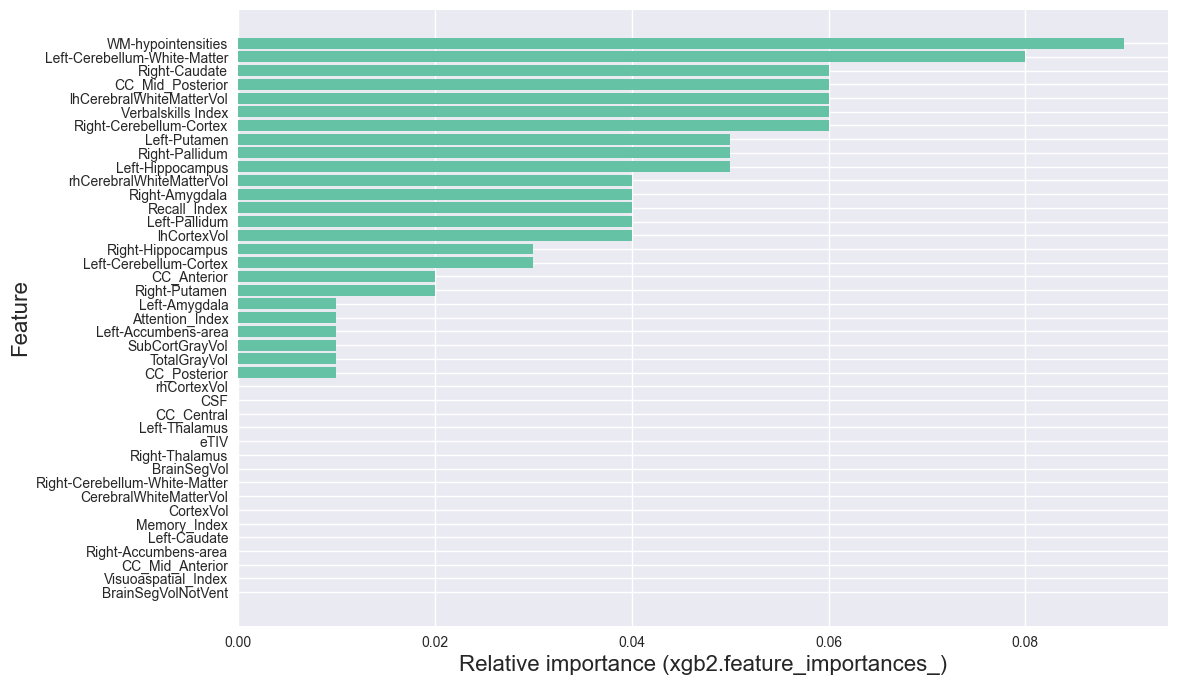

In [132]:
# Let's plot these results in a bar chart in descending order of importance
f, ax = plt.subplots(figsize=(12,8))
plt.barh(features2.columns[indices2], np.round(importances2[indices2],2))
plt.xlabel("Relative importance (xgb2.feature_importances_)", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# Increase font of ytick labels to make them easier to read
plt.yticks(fontsize=10)

plt.show()

#f.savefig('../figs/Fig_4a_best_model_feature_importances_.png')


## Permutation importance

Permutation importance is a model-agnostic method to measure feature importance. It works by randomly shuffling the values of each feature and measuring how much this shuffling decreases the model's performance. The idea behind permutation importance is that if a feature is important for the predictions of a trained model, then a random shuffling of the data in the corresponding column should drastically reduce the model's accuracy. On the other hand, a random shuffling of an unimportant feature shouldn't impact the model much.

This method has several advantages:

- It's model-agnostic, meaning it can be used with any type of model, not just random forests.
- It takes into account feature interactions, unlike some other importance measures.
- It provides a measure of uncertainty through the standard deviation of importance scores.

NOTE: Different measurement methods:

- Gini impurity: This is calculated during the training of the Random Forest. It measures how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.
- Permutation importance: This is calculated after the model is trained. It measures how much the model's performance decreases when a feature is randomly shuffled.

In [133]:
df2_pred_xgb2

,Subject,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,Memory_Index,Visuoaspatial_Index,Verbalskills Index,Attention_Index,Recall_Index,True,Predicted,"max(p(0),p(1))",p(0),p(1)
0,BGA_145,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,...,68,87,84,77,76,1_IBS,1_IBS,0.9526,0.047411,0.952589
1,BGA_141,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,...,78,102,113,93,74,1_IBS,1_IBS,0.9550,0.045006,0.954994
2,BGA_084,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,...,109,96,97,99,126,0_HC,0_HC,0.9545,0.954504,0.045496
3,BGA_050,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,...,86,97,90,98,86,1_IBS,1_IBS,0.9943,0.005695,0.994305
4,BGA_076,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,...,112,107,82,90,118,0_HC,1_IBS,0.9826,0.017357,0.982643
5,BGA_055,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,...,95,96,105,103,100,1_IBS,1_IBS,0.9901,0.009886,0.990114
6,BGA_151,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,...,109,90,95,79,104,1_IBS,1_IBS,0.9494,0.050555,0.949445
7,BGA_107,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,...,105,107,93,81,100,1_IBS,1_IBS,0.9756,0.024412,0.975588
8,BGA_053,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,...,112,107,105,88,108,0_HC,1_IBS,0.9969,0.003058,0.996942
9,BGA_089,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,...,83,96,95,110,91,1_IBS,1_IBS,0.7224,0.277561,0.722439


In [134]:
X_test = get_config('X_test')
y_true = get_config('y_test')
pred_xgb2 = predict_model(xgb2);
# y_pred = best_model.predict(X_test)  # HC=0, IBS=1
y_pred = df2_pred_xgb2['Predicted']
# y_pred = list(pred_best['prediction_label']) 
n_repeats = 30 
random_state = 123
X = df2.drop('Outcome', axis=1)

y_pred_numeric = [0 if x == '0_HC' else 1 for x in y_pred]
y_true_numeric = [0 if x == '0_HC' else 1 for x in y_true]

y_true_numeric

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6667,0.4667,0.6667,0.6667,0.6111,0.1795,0.2277


[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

In [135]:
print(type(pred_xgb2))
print(pred_xgb2.head())

<class 'pandas.core.frame.DataFrame'>
           eTIV  Left-Cerebellum-White-Matter  Left-Cerebellum-Cortex  \
59  1580332.000                      0.011314                0.041363   
55  1441712.000                      0.010599                0.039928   
29  1479463.375                      0.012270                0.038618   
3   1595000.250                      0.010458                0.030902   
22  1533277.500                      0.010784                0.040750   

    Left-Thalamus  Left-Caudate  Left-Putamen  Left-Pallidum  \
59       0.005163      0.002118      0.003422       0.001266   
55       0.004939      0.002347      0.003455       0.001261   
29       0.006195      0.003005      0.003942       0.001570   
3        0.005803      0.002675      0.003622       0.001322   
22       0.005667      0.002632      0.003825       0.001450   

    Left-Hippocampus  Left-Amygdala  Left-Accumbens-area  ...  SubCortGrayVol  \
59          0.002767       0.001122             0.000340 

In [136]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Assuming you have a test set (validation set)
X_val = get_config('X_test')
y_val = y_true_numeric

# Use the existing predictions
y_pred = pred_xgb2  # Assuming this contains the predictions

# Convert y_val to a 1D numpy array of strings
y_val = np.array(y_val).astype(str).ravel()

# If y_pred is a DataFrame, extract the relevant column
if isinstance(y_pred, pd.DataFrame):
    y_pred = y_pred.iloc[:, 0]  # Assuming the predictions are in the first column

# Convert y_pred to a 1D numpy array of strings
y_pred = np.array(y_pred).astype(str).ravel()

# Print shapes for debugging
print("Shape of y_val:", y_val.shape)
print("Shape of y_pred:", y_pred.shape)

# Create a LabelEncoder
le = LabelEncoder()

# Fit the encoder on the union of unique values from both y_val and y_pred
unique_labels = np.unique(np.concatenate((y_val, y_pred)))
le.fit(unique_labels)

# Transform both y_val and y_pred
y_val_encoded = le.transform(y_val)
y_pred_encoded = le.transform(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Model Accuracy: {accuracy:.3f}")

# Print some debug information
print("Original y_val unique values:", np.unique(y_val))
print("Original y_pred unique values:", np.unique(y_pred))
print("Encoded y_val unique values:", np.unique(y_val_encoded))
print("Encoded y_pred unique values:", np.unique(y_pred_encoded))
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# If you want to see the first few values
print("\nFirst few values:")
print("Original y_val:", y_val[:5])
print("Encoded y_val:", y_val_encoded[:5])
print("Original y_pred:", y_pred[:5])
print("Encoded y_pred:", y_pred_encoded[:5])


Shape of y_val: (24,)
Shape of y_pred: (24,)
Model Accuracy: 0.000
Original y_val unique values: ['0' '1']
Original y_pred unique values: ['1224504.6' '1320594.8' '1379524.2' '1386840.1' '1403013.9' '1415589.1'
 '1417420.1' '1441712.0' '1467060.1' '1479463.4' '1505440.6' '1515539.2'
 '1524517.5' '1533277.5' '1544695.4' '1565479.8' '1570708.6' '1578283.5'
 '1580332.0' '1595000.2' '1609011.5' '1641094.9' '1762430.5' '1823483.6']
Encoded y_val unique values: [0 1]
Encoded y_pred unique values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Label encoding mapping: {'0': 0, '1': 1, '1224504.6': 2, '1320594.8': 3, '1379524.2': 4, '1386840.1': 5, '1403013.9': 6, '1415589.1': 7, '1417420.1': 8, '1441712.0': 9, '1467060.1': 10, '1479463.4': 11, '1505440.6': 12, '1515539.2': 13, '1524517.5': 14, '1533277.5': 15, '1544695.4': 16, '1565479.8': 17, '1570708.6': 18, '1578283.5': 19, '1580332.0': 20, '1595000.2': 21, '1609011.5': 22, '1641094.9': 23, '1762430.5': 24, '18234

Original y_val unique values: ['0' '1']
Original y_pred unique values: [0 1]
Encoded y_val unique values: [0 1]
Encoded y_pred unique values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Label encoding mapping: {'0': 0, '1': 1, '1224504.6': 2, '1320594.8': 3, '1379524.2': 4, '1386840.1': 5, '1403013.9': 6, '1415589.1': 7, '1417420.1': 8, '1441712.0': 9, '1467060.1': 10, '1479463.4': 11, '1505440.6': 12, '1515539.2': 13, '1524517.5': 14, '1533277.5': 15, '1544695.4': 16, '1565479.8': 17, '1570708.6': 18, '1578283.5': 19, '1580332.0': 20, '1595000.2': 21, '1609011.5': 22, '1641094.9': 23, '1762430.5': 24, '1823483.6': 25}

First few values:
Original y_val: ['1' '1' '0' '1' '0']
Encoded y_val: [1 1 0 1 0]
Original y_pred: [1 1 0 1 1]
Encoded y_pred: [20  9 11 21 15]

Top 10 important features (permutation importance):
                        feature  importance       std
0             Right-Hippocampus    0.070833  0.032543
1                Right-Pallidum    0

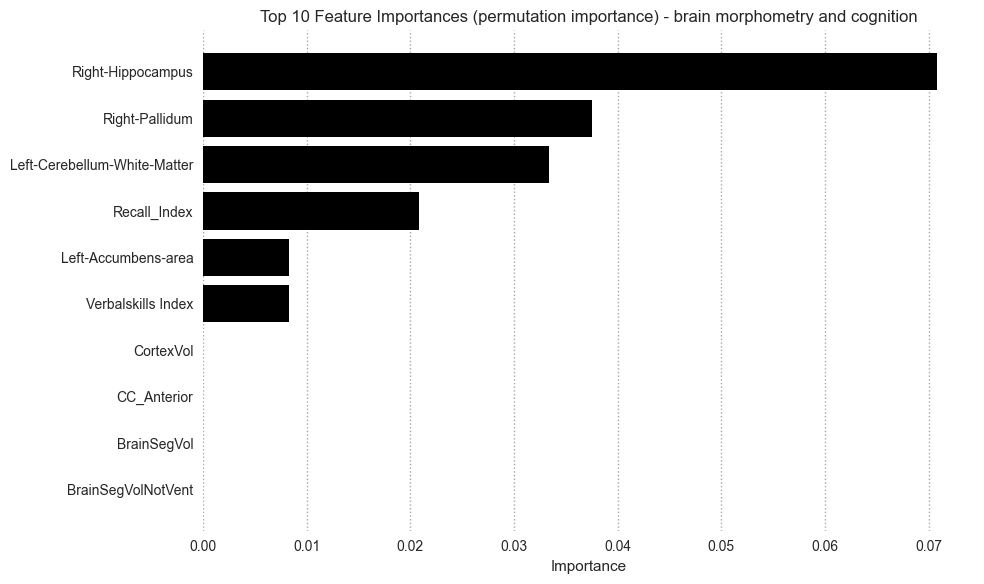

<Figure size 800x550 with 0 Axes>

In [149]:
# Compute permutation importance

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# ... [Your existing code up to accuracy calculation] ...

# Print some debug information
print("Original y_val unique values:", np.unique(y_val))
print("Original y_pred unique values:", np.unique(y_pred))
print("Encoded y_val unique values:", np.unique(y_val_encoded))
print("Encoded y_pred unique values:", np.unique(y_pred_encoded))
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# If you want to see the first few values
print("\nFirst few values:")
print("Original y_val:", y_val[:5])
print("Encoded y_val:", y_val_encoded[:5])
print("Original y_pred:", y_pred[:5])
print("Encoded y_pred:", y_pred_encoded[:5])

# Compute permutation importance
# Note: We need the actual model for this, not just predictions
# Assuming 'xgb2' is your trained model
result = permutation_importance(
    xgb2, X_val, y_val_encoded, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 important features
print("\nTop 10 important features (permutation importance):")
print(feature_importance.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10][::-1], feature_importance['importance'][:10][::-1], color='black')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (permutation importance) - brain morphometry and cognition')

# Set white background
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Add horizontal dotted gridlines
plt.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Remove vertical gridlines
plt.gca().yaxis.grid(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save to png and high res pdf
plt.savefig('../figs/Top_10_Feature_Importances_permutation_importance_aseg_and_rbans.png')

# Direct to figs folder on Overleaf
plt.savefig('/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/Top_10_Feature_Importances_permutation_importance_aseg_and_rbans.png')

plt.savefig('../figs/Top_10_Feature_Importances_permutation_importance_aseg_and_rbans.pdf', dpi=300)



Right-Hippocampus: 0.071 +/- 0.033
Right-Pallidum: 0.037 +/- 0.022
Left-Cerebellum-White-Matter: 0.033 +/- 0.025
Recall_Index: 0.021 +/- 0.021
Left-Accumbens-area: 0.008 +/- 0.017
Verbalskills Index: 0.008 +/- 0.045
CSF     : 0.000 +/- 0.000
Right-Amygdala: 0.000 +/- 0.000
Right-Thalamus: 0.000 +/- 0.000
Right-Cerebellum-Cortex: 0.000 +/- 0.000
Right-Cerebellum-White-Matter: 0.000 +/- 0.000
Left-Hippocampus: 0.000 +/- 0.000
Attention_Index: 0.000 +/- 0.000
Left-Pallidum: 0.000 +/- 0.000
Left-Putamen: 0.000 +/- 0.000
Left-Caudate: 0.000 +/- 0.000
Left-Thalamus: 0.000 +/- 0.000
Left-Cerebellum-Cortex: 0.000 +/- 0.000
Right-Accumbens-area: 0.000 +/- 0.000
WM-hypointensities: 0.000 +/- 0.000
CC_Posterior: 0.000 +/- 0.000
CC_Mid_Posterior: 0.000 +/- 0.000
Visuoaspatial_Index: 0.000 +/- 0.000
Memory_Index: 0.000 +/- 0.000
TotalGrayVol: 0.000 +/- 0.000
SubCortGrayVol: 0.000 +/- 0.000
CerebralWhiteMatterVol: 0.000 +/- 0.000
rhCerebralWhiteMatterVol: 0.000 +/- 0.000
lhCerebralWhiteMatterVol: 0.

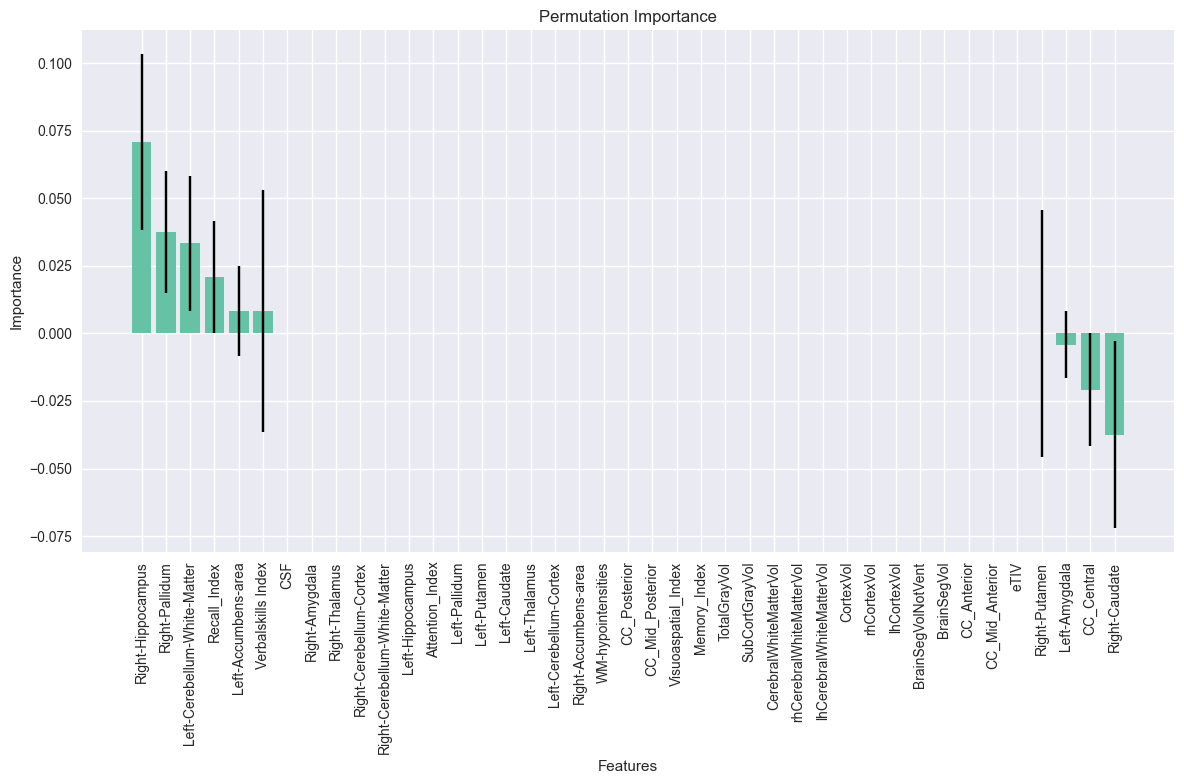


Top 10 most important features:
Right-Hippocampus             : 0.0708 +/- 0.0325
Right-Pallidum                : 0.0375 +/- 0.0224
Left-Cerebellum-White-Matter  : 0.0333 +/- 0.0250
Recall_Index                  : 0.0208 +/- 0.0208
Left-Accumbens-area           : 0.0083 +/- 0.0167
Verbalskills Index            : 0.0083 +/- 0.0449
CSF                           : 0.0000 +/- 0.0000
Right-Amygdala                : 0.0000 +/- 0.0000
Right-Thalamus                : 0.0000 +/- 0.0000
Right-Cerebellum-Cortex       : 0.0000 +/- 0.0000


In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming r_perm is your permutation importance result
# and X_val is your validation set

r_perm = result

# Results of permutation importance calculation (mean +/- std)
for i in r_perm.importances_mean.argsort()[::-1]:
    print(f"{X_val.columns[i]:<8}"
    f": {r_perm.importances_mean[i]:.3f}"
    f" +/- {r_perm.importances_std[i]:.3f}")

# Plot the results
plt.figure(figsize=(12, 8))
indices = r_perm.importances_mean.argsort()[::-1]
plt.bar(range(X_val.shape[1]), r_perm.importances_mean[indices])
plt.xticks(range(X_val.shape[1]), X_val.columns[indices], rotation=90)
plt.errorbar(range(X_val.shape[1]), r_perm.importances_mean[indices], 
             yerr=r_perm.importances_std[indices], fmt='none', c='black')
plt.title('Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Sort the features based on the mean importance scores
sorted_indices = np.argsort(r_perm.importances_mean)[::-1]
sorted_importances = r_perm.importances_mean[sorted_indices]
sorted_std = r_perm.importances_std[sorted_indices]

# Plot the sorted feature importances
#plt.figure(figsize=(12, 8))
#plt.bar(range(len(sorted_importances)), sorted_importances)
#plt.xticks(range(len(sorted_importances)), [X_val.columns[i] for i in sorted_indices], rotation=90)
#plt.errorbar(range(len(sorted_importances)), sorted_importances, yerr=sorted_std, fmt='none', c='black')
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.title('Sorted Permutation Importance')
#plt.tight_layout()
#plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
for i in range(10):
    print(f"{X_val.columns[sorted_indices[i]]:<30}: {sorted_importances[i]:.4f} +/- {sorted_std[i]:.4f}")

### Recursive Feature Elimination, RFE

In [139]:
# Compute RFE
from sklearn.feature_selection import RFE

y_train_num = get_config('y_train').map({'0_HC': 0, '1_IBS': 1})   
y_test_num = get_config('y_test').map({'0_HC': 0, '1_IBS': 1})   

# Assuming best_model is a XGBOOST model
rfe = RFE(estimator=xgb2, n_features_to_select=5)
rfe.fit(get_config('X_train'), y_train_num)

# Print the selected features
print("Selected features:", get_config('X_train').columns[rfe.support_])

Selected features: Index(['Left-Cerebellum-White-Matter', 'Right-Caudate', 'CC_Mid_Posterior',
       'lhCerebralWhiteMatterVol', 'Verbalskills Index'],
      dtype='object')


```python
%%time
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

X_train = get_config('X_train')
X_test = get_config('X_test')
y_train = get_config('y_train')
y_test = get_config('y_test')

# Custom feature selection function
def select_features(X, y, n_features):
    model = XGBClassifier()
    scores = []
    for feature in X.columns:
        score = cross_val_score(model, X[[feature]], y, cv=5).mean()
        scores.append((feature, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    return [feature for feature, _ in scores[:n_features]]

# Evaluate models with different numbers of features
n_features = range(1, len(X_train.columns) + 1)
accuracies = []

for n in n_features:
    selected_features = select_features(X_train, y_train_num, n)
    X_train_n = X_train[selected_features]
    X_test_n = X_test[selected_features]
    
    model = XGBClassifier()
    model.fit(X_train_n, y_train_num)
    y_pred = model.predict(X_test_n)
    accuracies.append(accuracy_score(y_test_num, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_features, accuracies, marker='o')
plt.title('Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.xticks(n_features)
plt.grid(True)
plt.show()

# Identify the optimal number of features
optimal_n_features = n_features[np.argmax(accuracies)]
print(f"\nOptimal number of features: {optimal_n_features}")

# Get the names of the optimal features
optimal_features = select_features(X_train, y_train_num, optimal_n_features)
print(f"Optimal features: {optimal_features}")

# Train the final model with optimal features
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]

final_model = XGBClassifier()
final_model.fit(X_train_optimal, y_train_num)

# Evaluate the final model
y_pred_final = final_model.predict(X_test_optimal)
final_accuracy = accuracy_score(y_test_num, y_pred_final)
print(f"\nFinal model accuracy with {optimal_n_features} features: {final_accuracy:.4f}")
```

## SHAP values

**SHAP (SHapley Additive exPlanations) values** provide a powerful and unified framework to interpret machine learning model predictions, particularly in terms of feature importance. Developed based on [cooperative game theory](https://en.wikipedia.org/wiki/Cooperative_game_theory), SHAP values offer a way to understand the contribution of each feature to the prediction of a specific instance, making them highly useful in fields like medical AI where interpretability is crucial.


<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" width="600" />
 

### Fundamentals of SHAP Values

1. **Game Theory Background**: SHAP values are derived from Shapley values in game theory, which are a method to fairly distribute the 'payout' (or contribution) among players (features) in a coalition (model).


2. **Individual Prediction Explanation**: SHAP values explain the prediction of an instance by computing the contribution of each feature to the prediction. Unlike global feature importance, which gives an overall picture, SHAP values provide local interpretability for each prediction.

3. **Additive Feature Attribution**: In SHAP, the model's output is expressed as the sum of the effects of each feature being introduced into a conditional expectation.

### How SHAP Values Work in Practice

- **Model Agnostic**: SHAP can be applied to any machine learning model, be it a simple linear model or a complex deep learning model.

- **Computing SHAP Values**: For a given prediction, SHAP values are calculated by comparing what a model predicts with and without each feature. However, since features can be interdependent, this is done in a way that accounts for all possible combinations of features.

- **Interpretation**: A SHAP value for a feature for a particular prediction represents how much knowing the feature's value moves the prediction away from the mean prediction for the dataset.

### Significance in Medical AI

- **Insight into Model Predictions**: SHAP values can reveal why a model makes certain decisions, which is vital in healthcare settings where understanding the rationale behind a diagnosis or treatment recommendation is as important as the accuracy of the prediction itself.

- **Patient-Specific Explanations**: They can provide personalized insights, like why a particular patient was classified as high risk for a disease.

- **Clinical Research and Decision Making**: Helps in identifying and understanding key factors that drive medical conditions, which can be instrumental in both clinical research and decision-making.

### Example

Imagine a model predicting diabetes risk. The SHAP value for a feature like 'blood sugar level' in a particular patient's prediction tells us how much having that specific blood sugar level, compared to the average level in the training data, impacts the model's risk prediction for that patient.

### Challenges and Considerations

- **Complexity and Computation**: Calculating SHAP values, especially for models with a large number of features or complex interactions, can be computationally intensive.

- **Interpretation Nuances**: While SHAP values offer clarity, interpreting them, especially in the context of complex interactions and correlations between features, requires domain expertise.

In conclusion, SHAP values represent a significant advancement in the field of explainable AI, offering clear, detailed, and theoretically grounded insights into model predictions. This is especially critical in medical AI, where transparent and interpretable AI models are crucial for clinical acceptance and ethical considerations.

Cooperative game theory comes into play in the concept of SHAP (SHapley Additive exPlanations) values through the use of Shapley values, which are a solution concept from cooperative game theory. To understand this, let's first delve into what cooperative game theory is and then see how it relates to SHAP values in machine learning.

### Cooperative Game Theory

1. **Basic Concept**: Cooperative game theory deals with how groups of agents (players) can form coalitions and how the payoff (rewards) from any cooperative effort should be distributed among these agents.

2. **Coalitions and Payoffs**: The key focus is on the formation of groups (coalitions) and how the rewards from collaborative efforts are allocated to the members of the coalition.

3. **Shapley Values**: Developed by Lloyd Shapley, the Shapley value is a method to fairly distribute the total gains (or losses) among the players based on their individual contributions. The idea is to find an equitable distribution of payoffs, considering all possible combinations of coalition formation.

### SHAP Values and Cooperative Game Theory

1. **Model as a Cooperative Game**: In the context of SHAP values, each feature in a machine learning model is considered a 'player' in a game. The 'game' is the task of making a prediction, and the 'payoff' is the prediction itself.

2. **Feature Contributions**: The Shapley value calculates the contribution of each feature (player) to the prediction (payoff) by considering all possible combinations of features. It averages the marginal contributions of a feature across all possible combinations.

3. **Fair Allocation of Importance**: Just like Shapley values in game theory aim to distribute payoffs fairly based on contribution, SHAP values in machine learning aim to distribute the 'credit' or 'blame' of a prediction among the features based on their contribution.

### Practical Example

Imagine a model predicting patient health outcomes based on various features like age, weight, blood pressure, etc. The SHAP value for each feature tells us how much that feature contributes to a particular prediction, considering the interplay with other features. This is akin to determining how much each player (feature) in a game (the model) contributes to the final score (prediction), considering all possible team (feature combination) scenarios.

### Significance

- **Fairness and Equity**: Just as Shapley values in game theory ensure a fair distribution of rewards, SHAP values in machine learning ensure a fair attribution of importance to features.
- **Interpretability and Transparency**: This approach allows for a more nuanced and transparent interpretation of model predictions, which is especially valuable in critical fields like medical AI.

In summary, cooperative game theory, through the concept of Shapley values, provides a foundational framework for SHAP values in machine learning, ensuring a fair and equitable attribution of feature contributions to model predictions. This intersection of game theory and AI highlights the multidisciplinary nature of advancements in AI interpretability.

In [141]:
xgb2

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

Figures saved as 'SHAP_summary_plot_IBS_aseg_and_rbans.png' and 'SHAP_summary_plot_IBS_aseg_and_rbans.pdf'


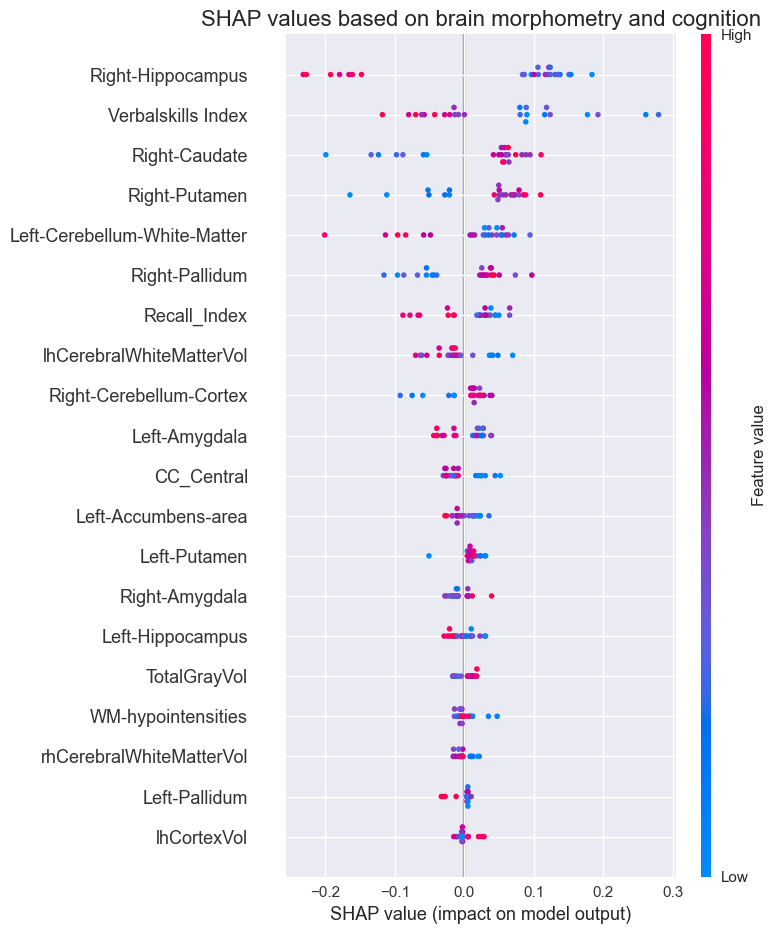

In [152]:
import shap
import matplotlib.pyplot as plt
import os

# Ensure the directory exists
os.makedirs('../figs/', exist_ok=True)

explainer = shap.Explainer(xgb2.predict_proba, get_config('X_train'))
shap_values = explainer(get_config('X_test'))

# When plotting, manually provide feature names
feature_names = get_config('X_test').columns.tolist()

# Function to create and save SHAP summary plot
def create_and_save_shap_plot(file_format):
    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values[:,:,1], get_config('X_test'), feature_names=feature_names, show=False)
    plt.title("SHAP values based on brain morphometry and cognition", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../figs/SHAP_summary_plot_IBS_aseg_and_rbans.{file_format}', dpi=300, bbox_inches='tight')
    
    # Write direct to figs folder on Overleaf
    plt.savefig(f'/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/SHAP_summary_plot_IBS_aseg_and_rbans.{file_format}', dpi=300, bbox_inches='tight')

    plt.close()

# Create and save the SHAP summary plot as PNG and PDF
create_and_save_shap_plot('png')
create_and_save_shap_plot('pdf')

print("Figures saved as 'SHAP_summary_plot_IBS_aseg_and_rbans.png' and 'SHAP_summary_plot_IBS_aseg_and_rbans.pdf'")

# If you want to display the plot in the notebook, create it again
plt.figure(figsize=(10, 12))
shap.summary_plot(shap_values[:,:,1], get_config('X_test'), feature_names=feature_names, show=False)
plt.title("SHAP values based on brain morphometry and cognition", fontsize=16)
plt.tight_layout()
plt.show()

In [154]:
shap_values.shape

(24, 41, 2)

This figure is a SHAP (SHapley Additive exPlanations) summary plot, which shows the impact of different features on the model's output. SHAP values help interpret the importance and effect of each feature in a machine learning model's predictions.

Key points about the figure:

1. Features: The y-axis lists various features used in the model, including brain regions (e.g., Right-Hippocampus, Right-Caudate) and cognitive indices (e.g., Verbalskills Index, Recall_Index).

2. SHAP values: The x-axis represents the SHAP value, which indicates the impact on the model output. Positive values (to the right) increase the prediction, while negative values (to the left) decrease it.

3. Feature importance: Features are ordered by importance, with the most impactful at the top (Right-Hippocampus) and least impactful at the bottom (lhCortexVol).

4. Color coding: The color of each point represents the feature value, with red indicating high values and blue indicating low values.

5. Distribution: The spread of points for each feature shows how the impact varies across different samples.

Interpretation:
- Right-Hippocampus has the highest impact, with higher values (red) generally pushing the prediction higher.
- Verbalskills Index is the second most important, with lower values (blue) generally associated with higher predictions.
- Some features, like Right-Caudate, show a more complex relationship, where both high and low values can have significant impacts in different directions.
- Features at the bottom of the list have relatively little impact on the model's predictions.

This plot helps in understanding which features are most influential in the model's decision-making process and how they affect the predictions.

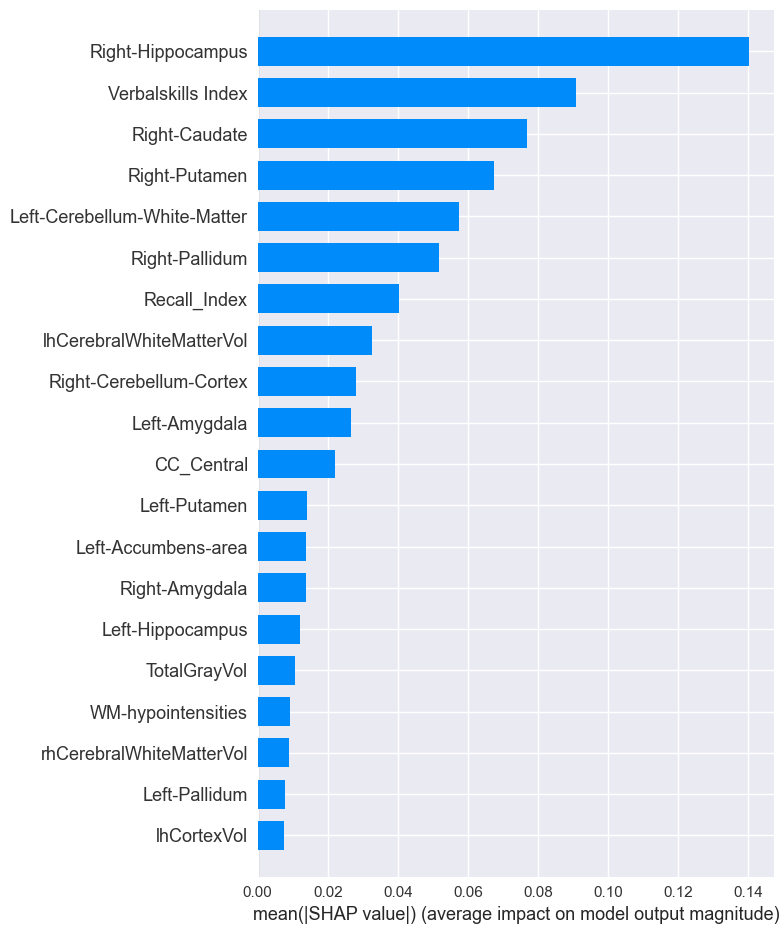

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [155]:
f2, ax = plt.subplots(figsize=(12,8))

f2 = shap.summary_plot(shap_values[:, :, 1], get_config('X_train'), plot_type="bar")   # X_test

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====') 

plt.show()

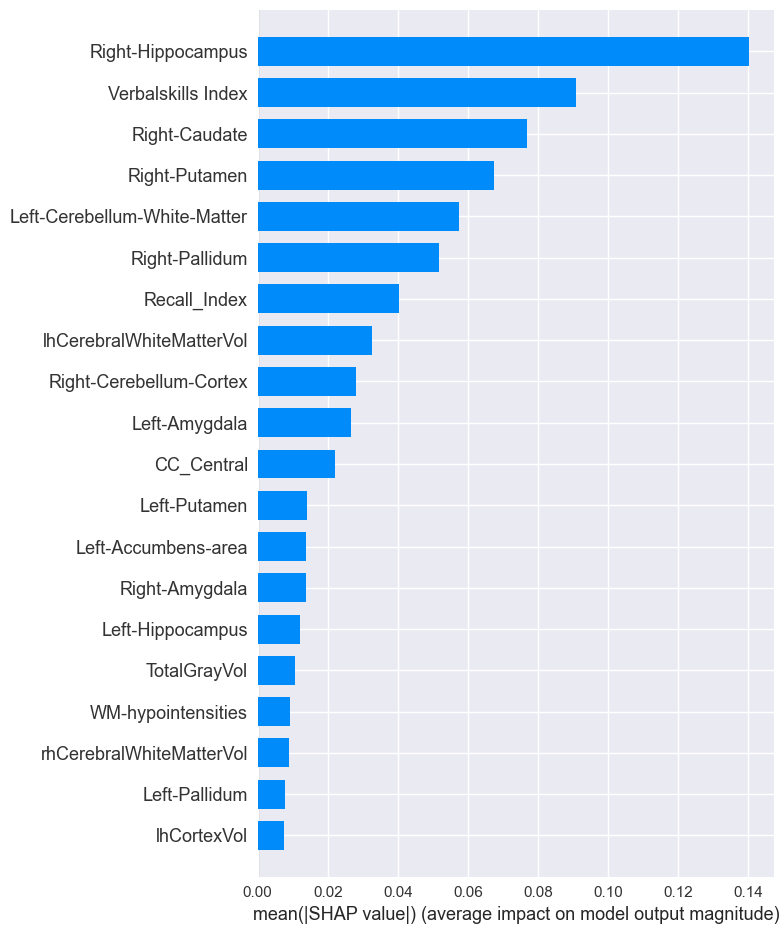

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [156]:
f2, ax = plt.subplots(figsize=(12,8))

f2 = shap.summary_plot(shap_values[:, :, 0], get_config('X_train'), plot_type="bar")   # X_test

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====') 

plt.show()

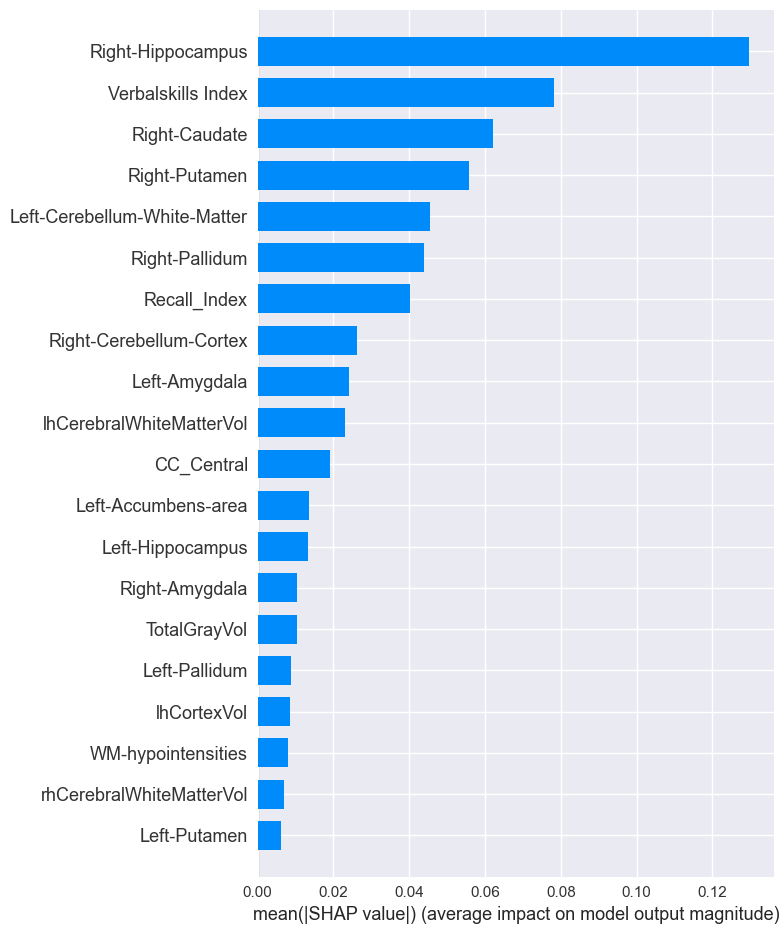

In [157]:
# Assuming best_model is your trained Random Forest model
# and get_config('X_test') returns your test data

# Compute the SHAP values for the test set
explainer = shap.Explainer(xgb2.predict_proba, get_config('X_test'))
shap_values = explainer.shap_values(get_config('X_test'))


# For classification problems, shap_values will be a list of arrays
# (one per class). We need to choose which class to plot.
# Let's assume we want to plot for the IBS class (index 1)

# Plot the SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, :, 1], get_config('X_test'), plot_type="bar", show=False)
plt.tight_layout()
plt.show()

In [158]:
?shap_values

Type:        ndarray
String form:
[[[ 4.22857298e-03 -4.22857283e-03]
           [ 4.34621287e-02 -4.34621289e-02]
           [-1.53039085e-03  1.530 <...> 72e-01 -1.04292874e-01]
           [ 7.93522845e-03 -7.93522821e-03]
           [ 8.75874972e-02 -8.75874959e-02]]]
Length:      24
File:        ~/opt/anaconda3/envs/ibs-mac/lib/python3.10/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information,